# **Sarcasm Classification: Error Analysis and More Visualisation (Part 7)**

**Author: Shanmugam Udhaya**

*Contact:* [@frostbitepillars](https://t.me/frostbitepillars) for any clarifications  

---

We will skip Part 6 (Loss Function Exploration), as we believe that error analysis will provide more meaningful insights into our model’s behavior.

In Part 5, we evaluated different sampling strategies for triplet loss. We found that Distance Weighted Sampling performed best, offering strong results while only requiring batch-wise sampling.

## **Focus**
Now, our goal is to gain deeper insights into model performance rather than chasing state-of-the-art results. To do this, we’ll focus on error analysis, particularly:

- **Misplaced embeddings:** For instance, identifying sarcastic samples (red) that are incorrectly embedded within the non-sarcastic cluster (purple).

- **Logistic Regression (LR) Coefficients:** We’ll analyze the LR classifier trained on BERT CLS embeddings to uncover patterns or trends. Specifically, we aim to visualize how fine-tuning affects the LR coefficients.

- **Human Survey**: We will pick the highest probability but misclassified samples and do a survey to see if humans also struggle to identify them. This might also be a case of questioning human annotated ground-truth labels.

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel # Use AutoModel for hidden states
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

In [ ]:
from tqdm import tqdm

In [ ]:
!gdown 1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G

Downloading...
From: https://drive.google.com/uc?id=1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G
To: /content/archive (7).zip
100% 3.46M/3.46M [00:00<00:00, 25.8MB/s]


In [ ]:
!unzip "archive (7).zip"

Archive:  archive (7).zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [ ]:
import pandas as pd

df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [ ]:
print(df.columns)
print(df.isnull().sum())
print(Counter(df['is_sarcastic']))
print(df.head(10))

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')
is_sarcastic    0
headline        0
article_link    0
dtype: int64
Counter({0: 14985, 1: 13634})
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   
5             0                               my white inheritance   
6             0         5 ways to file your taxes with less stress   
7             1  richard branson's global-warming donation near...   
8             1  shadow government getting too large to meet in...   
9             0                 lots of parents know this scenario   

                                        article_link  
0  https:

## Pre-Processing

### No Pre-Processing at all

In [ ]:
df['clean_headline'] = df['headline']

### With Pre-Processing

In [ ]:
def preprocess_text(text, action, stopword):
  #Lower Caps
  #text = text.lower()
  #Remove Punctuations
  #text = text.translate(str.maketrans('', '', string.punctuation))

  #https://www.geeksforgeeks.org/text-preprocessing-for-nlp-tasks/
    # text = text.lower()  # Lowercase
  #text = re.sub(r'\d+', '', text)  # Remove numbers
    #text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
  #text = re.sub(r'\W', ' ', text)  # Remove special characters
    # text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
  # Tokenize and remove stopwords
  words = word_tokenize(text)
  if stopword:
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

  #If stemming
  if action == "S":
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
  elif action == "L":
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
  return " ".join(words)

# Apply preprocessing to the text column
df['clean_headline'] = df['headline'].apply(lambda text: preprocess_text(text, "", False))

## Linguistic Features from (feature eng1)

In [ ]:
def get_pos_counts(text):
    """
    Returns a dictionary with counts of certain POS tags (NOUN, VERB, ADJ, ADV)
    """
    pos_tags = pos_tag(word_tokenize(text))
    counts = {
        'noun_count': 0,
        'verb_count': 0,
        'adj_count': 0,
        'adv_count': 0
    }
    for word, tag in pos_tags:
        if tag.startswith('NN'):
            counts['noun_count'] += 1
        elif tag.startswith('VB'):
            counts['verb_count'] += 1
        elif tag.startswith('JJ'):
            counts['adj_count'] += 1
        elif tag.startswith('RB'):
            counts['adv_count'] += 1
    return counts

def get_text_length(text):
    return len(word_tokenize(text))

import spacy
nlp = spacy.load("en_core_web_sm")

def get_ner_count(text):
    doc = nlp(text)
    return len(doc.ents)

In [ ]:
df['pos_counts'] = df['clean_headline'].apply(get_pos_counts)
df['text_length'] = df['clean_headline'].apply(get_text_length)

df['noun_count'] = df['pos_counts'].apply(lambda x: x['noun_count'])
df['verb_count'] = df['pos_counts'].apply(lambda x: x['verb_count'])
df['adj_count'] = df['pos_counts'].apply(lambda x: x['adj_count'])
df['adv_count'] = df['pos_counts'].apply(lambda x: x['adv_count'])

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.9 MB/s eta 0:00:00


In [ ]:
import textstat
df['flesch_reading_ease'] = df['clean_headline'].apply(lambda text: textstat.flesch_reading_ease(text))
df['dale_chall_score'] = df['clean_headline'].apply(lambda text: textstat.dale_chall_readability_score(text))

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['clean_headline'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

In [ ]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_chars(text):
  count=0
  for i in text:
    if i.isupper():
      count+=1
  return count

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

def count_unique_words(text):
    return len(set(text.split()))

def count_exclamation(text):
    return text.count("!")

df['char_count'] = df['clean_headline'].apply(count_chars)
df['capital_char_count'] = df["clean_headline"].apply(lambda x:count_capital_chars(x))
df['capital_word_count'] = df["clean_headline"].apply(lambda x:count_capital_words(x))

In [ ]:
df['stopword_count'] = df['clean_headline'].apply(lambda x: len([word for word in x.split() if word in stopwords.words('english')]))
df['word_count'] = df['clean_headline'].apply(count_words)
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [ ]:
def has_contrastive_conjunction(text):
    contrastive_words = {"but", "although", "yet", "however", "though"}
    return int(any(word in text.split() for word in contrastive_words))

df['contrastive_marker'] = df['clean_headline'].apply(has_contrastive_conjunction)

In [ ]:
import numpy as np
import pandas as pd
import textstat
import string
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from textblob import TextBlob
from scipy.stats import entropy

nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from scipy.stats import entropy
def calculate_entropy(text):
    words = word_tokenize(text.lower())
    freq_dist = Counter(words)
    probs = np.array(list(freq_dist.values())) / sum(freq_dist.values())
    return entropy(probs, base=2)  # Shannon Entropy

df["entropy"] = df["clean_headline"].apply(calculate_entropy)

### 2. **Lexical Diversity (Unique Words / Total Words)**
def lexical_diversity(text):
    words = word_tokenize(text.lower())
    return len(set(words)) / len(words) if len(words) > 0 else 0

df["lexical_diversity"] = df["clean_headline"].apply(lexical_diversity)

### 6. **Wrong Words (Words Not in WordNet)**
def count_wrong_words(text):
    words = word_tokenize(text.lower())
    return sum(1 for word in words if not wordnet.synsets(word))

df["wrong_word_count"] = df["clean_headline"].apply(count_wrong_words)

### 7. **Difficult Words (Hard-to-Read Words)**
df["difficult_word_count"] = df["clean_headline"].apply(textstat.difficult_words)

### 8. **Lengthy Words (Words > 2 Characters)**
df["lengthy_word_count"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) > 2))

### 9. **Two-Letter Words**
df["two_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 2))

### 10. **Single-Letter Words**
df["single_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 1))


In [ ]:
def detect_incongruity(text):
    tokens = word_tokenize(text)
    pos_words = 0
    neg_words = 0

    for word in tokens:
        score = analyzer.polarity_scores(word)['compound']
        if score >= 0.5:
            pos_words += 1
        elif score <= -0.5:
            neg_words += 1

    # Return 1 if both positive and negative words exist → sentiment conflict
    return int(pos_words > 0 and neg_words > 0)

# Apply to the DataFrame
df['sentiment_incongruity'] = df['clean_headline'].apply(detect_incongruity)

In [ ]:
None+1

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

## Distance Weighted Sampling w/ Triplet Loss

Loaded data with 28619 samples after cleaning.
Class distribution:
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64
Using device: cuda

Splitting data into train/test sets...
Train set size: 21464, Test set size: 7155

Loading tokenizer and base BERT model: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Generating ORIGINAL BERT [CLS] embeddings (BEFORE fine-tuning)...
  Generating 'Before FT' Test Embeddings for 7155 texts in batches of 32...
    Processed batch 50/224 (22.3%) | ETA: 35.8s
    Processed batch 100/224 (44.6%) | ETA: 24.7s
    Processed batch 150/224 (67.0%) | ETA: 14.6s
    Processed batch 200/224 (89.3%) | ETA: 4.8s
    Processed batch 224/224 (100.0%) | ETA: 0.0s
  Finished generating embeddings in 44.39s.
BERT [CLS] TEST embeddings BEFORE fine-tuning shape: (7155, 768)
  Generating 'Before FT' Train Embeddings for 21464 texts in batches of 32...
    Processed batch 50/671 (7.5%) | ETA: 127.4s
    Processed batch 100/671 (14.9%) | ETA: 118.2s
    Processed batch 150/671 (22.4%) | ETA: 108.8s
    Processed batch 200/671 (29.8%) | ETA: 99.5s
    Processed batch 250/671 (37.3%) | ETA: 90.1s
    Processed batch 300/671 (44.7%) | ETA: 79.9s
    Processed batch 350/671 (52.2%) | ETA: 69.4s
    Processed batch 400/671 (59.6%) | ETA: 58.6s
    Processed batch 450/671 (67.1%

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.757385
[t-SNE] KL divergence after 350 iterations: 1.749960
t-SNE 'before' finished: 7.21s.


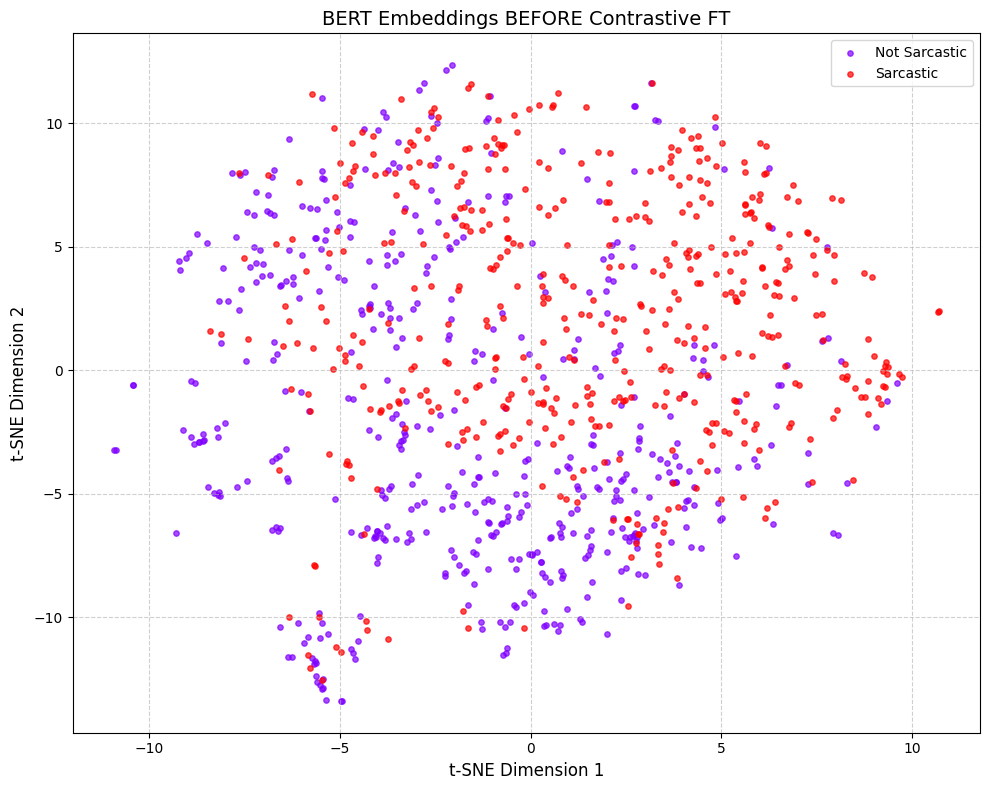


Running t-SNE AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.176044


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.275730
[t-SNE] KL divergence after 350 iterations: 1.319023
t-SNE 'after' finished: 3.71s.


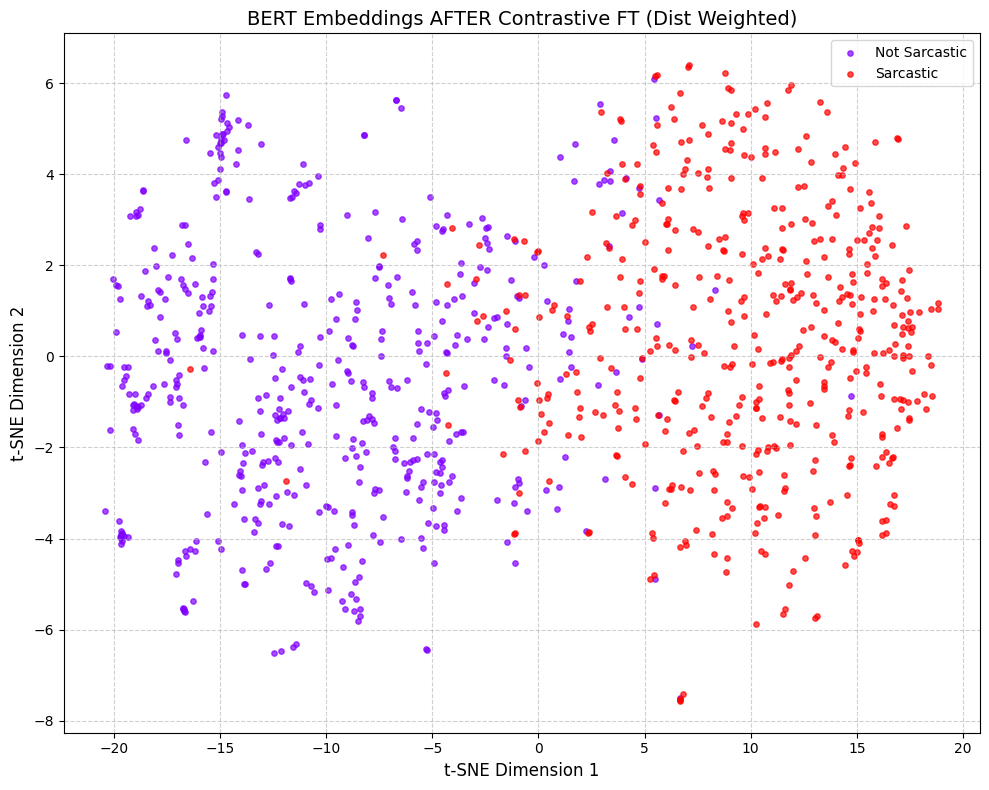

--- Embedding Visualization Finished ---

Extracting linguistic features...


NameError: name 'ling_feature_names' is not defined

In [ ]:
# -*- coding: utf-8 -*-
"""
Sarcasm Detection with Contrastive Fine-tuning using Distance-Weighted Sampling and Visualization

This script demonstrates sarcasm detection using:
1. BERT embeddings fine-tuned with contrastive learning (Triplet Loss)
   using Distance-Weighted Triplet Sampling within batches.
2. Includes t-SNE visualization of BERT embeddings before and after fine-tuning.
3. Trains downstream classifiers on features BEFORE and AFTER fine-tuning
   and visualizes feature importance for comparison.
"""

# --- Essential Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, classification_report, confusion_matrix, pairwise,
                             ConfusionMatrixDisplay) # Added ConfusionMatrixDisplay & pairwise
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix # Needed for combining features
import random
import time
from collections import defaultdict # Can be useful, though not strictly used here
import warnings

# --- Visualization Imports ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 16 # Distance-Weighted can be memory intensive
RANDOM_STATE = 42

# Contrastive Learning Config
CONTRASTIVE_EPOCHS = 1 # Keep low for quick testing, increase for real training (e.g., 3-5)
CONTRASTIVE_LR = 2e-5
CONTRASTIVE_MARGIN = 0.5
PROJECTION_DIM = 256
USE_PROJECTION_HEAD = True # Whether to use projection head during *contrastive* training
DISTANCE_WEIGHTING_BETA = 2.0 # Example value, might need tuning

# Visualization Config
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 350 # Slightly more iterations
VISUALIZATION_SAMPLE_SIZE = 1000

# --- Seed Everything ---
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Basic Validation
if 'is_sarcastic' not in df.columns or 'clean_headline' not in df.columns:
    raise ValueError("DataFrame must contain 'is_sarcastic' and 'clean_headline' columns.")
df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str).fillna('')
df = df[df['clean_headline'].str.len() > 0].copy().reset_index(drop=True)
print(f"Loaded data with {len(df)} samples after cleaning.")
print(f"Class distribution:\n{df['is_sarcastic'].value_counts(normalize=True)}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data Split ---
print("\nSplitting data into train/test sets...")
train_indices, test_indices = train_test_split(
    df.index,
    stratify=df['is_sarcastic'],
    random_state=RANDOM_STATE
)
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.loc[test_indices].reset_index(drop=True)
y_train = df_train['is_sarcastic'].values
y_test = df_test['is_sarcastic'].values
print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")

# --- Load Tokenizer and Base BERT Model ---
print(f"\nLoading tokenizer and base BERT model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model_base = AutoModel.from_pretrained(BERT_MODEL_NAME)
bert_model_base.to(device)

# --- Embedding Generation Function ---
def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size, desc="Generating embeddings"):
    all_cls_embeddings = []
    model.eval()
    num_samples = len(texts)
    print(f"  {desc} for {num_samples} texts in batches of {batch_size}...")
    num_batches = (num_samples + batch_size - 1) // batch_size
    start_time = time.time()
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_texts = texts[i : i + batch_size]
            batch_texts = [t if isinstance(t, str) and len(t) > 0 else "[PAD]" for t in batch_texts]
            if not batch_texts: continue
            inputs = tokenizer(batch_texts, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length).to(device)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_cls_embeddings.append(cls_embeddings)
            if (i // batch_size + 1) % 50 == 0 or (i // batch_size + 1) == num_batches:
                 progress = (i // batch_size + 1) / num_batches; elapsed = time.time() - start_time
                 eta = (elapsed / progress) * (1 - progress) if progress > 0 else 0
                 print(f"    Processed batch {i // batch_size + 1}/{num_batches} ({progress*100:.1f}%) | ETA: {eta:.1f}s")
    print(f"  Finished generating embeddings in {time.time() - start_time:.2f}s.")
    if not all_cls_embeddings:
        hidden_size = model.config.hidden_size if hasattr(model, 'config') else 768
        return np.array([]).reshape(0, hidden_size)
    return np.vstack(all_cls_embeddings)

# --- Generate Embeddings BEFORE Fine-tuning (for Train and Test) ---
print("\nGenerating ORIGINAL BERT [CLS] embeddings (BEFORE fine-tuning)...")
inference_batch_size = BATCH_SIZE * 2 # Can use larger batch for inference
# Generate for TEST set (for t-SNE and 'before' classifier)
X_bert_test_before_ft = get_bert_cls_embeddings(df_test['clean_headline'].tolist(), bert_model_base, tokenizer, device, MAX_LENGTH, inference_batch_size, desc="Generating 'Before FT' Test Embeddings")
print("BERT [CLS] TEST embeddings BEFORE fine-tuning shape:", X_bert_test_before_ft.shape)
# Generate for TRAIN set (needed for 'before' classifier)
X_bert_train_before_ft = get_bert_cls_embeddings(df_train['clean_headline'].tolist(), bert_model_base, tokenizer, device, MAX_LENGTH, inference_batch_size, desc="Generating 'Before FT' Train Embeddings")
print("BERT [CLS] TRAIN embeddings BEFORE fine-tuning shape:", X_bert_train_before_ft.shape)


# --- Contrastive Learning Setup ---

# --- Dataset Class ---
class SarcasmDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe, self.tokenizer, self.max_length = dataframe, tokenizer, max_length
        self.texts, self.labels = dataframe['clean_headline'].tolist(), dataframe['is_sarcastic'].values
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, index):
        text, label = self.texts[index], self.labels[index]
        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()} # Remove batch dim
        return inputs, torch.tensor(label, dtype=torch.long)

# --- Contrastive Model Wrapper ---
class ContrastiveBERT(nn.Module):
    def __init__(self, bert_model, projection_dim=None, use_projection=True): # Added use_projection flag
        super().__init__()
        self.bert = bert_model
        self.use_projection = use_projection # Store the flag
        self.projection_dim = projection_dim
        self.config = bert_model.config
        if self.use_projection and self.projection_dim:
            print(f"Using projection head: {self.config.hidden_size} -> {self.projection_dim}")
            self.projection_head = nn.Sequential(nn.Linear(self.config.hidden_size, self.config.hidden_size), nn.ReLU(), nn.Linear(self.config.hidden_size, self.projection_dim))
        else:
            print("Using direct BERT CLS embeddings (no projection head during contrastive training).")
            self.projection_head = nn.Identity()
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        bert_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
        if token_type_ids is not None and 'token_type_ids' in self.bert.forward.__code__.co_varnames: bert_inputs['token_type_ids'] = token_type_ids
        outputs = self.bert(**bert_inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.projection_head(cls_embedding) # Apply projection head (or identity)

# --- Loss Function: Distance-Weighted Sampling ---
def distance_weighted_triplet_loss(labels, embeddings, margin, beta, squared=False, epsilon=1e-8):
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
    if squared: pairwise_dist = pairwise_dist.pow(2)
    batch_size = labels.size(0); anchor_indices = torch.arange(batch_size, device=labels.device)
    valid_triplets_mask = torch.zeros(batch_size, dtype=torch.bool, device=labels.device)
    final_pos_dist = torch.zeros(batch_size, device=labels.device)
    final_neg_dist = torch.zeros(batch_size, device=labels.device)
    num_valid_anchors = 0
    for i in range(batch_size):
        anchor_label = labels[i]
        pos_mask = (labels == anchor_label) & (anchor_indices != i)
        if not torch.any(pos_mask): continue
        pos_distances = pairwise_dist[i][pos_mask]
        hardest_positive_dist = torch.max(pos_distances) # Farthest positive
        neg_mask = labels != anchor_label
        if not torch.any(neg_mask): continue
        neg_indices = anchor_indices[neg_mask]
        neg_distances = pairwise_dist[i][neg_mask]
        weights = torch.exp(-beta * torch.clamp(neg_distances, min=epsilon))
        if torch.sum(weights) < epsilon:
            print(f"Warning: Anchor {i} near-zero weights, using uniform neg sampling.", end='\r') # Less verbose warning
            sampled_neg_local_idx = torch.randint(0, len(neg_indices), (1,), device=labels.device).item()
        else:
            sampled_neg_local_idx = torch.multinomial(weights, 1).item()
        sampled_neg_dist = neg_distances[sampled_neg_local_idx]
        valid_triplets_mask[i] = True
        final_pos_dist[i] = hardest_positive_dist
        final_neg_dist[i] = sampled_neg_dist
        num_valid_anchors += 1
    if num_valid_anchors == 0: return torch.tensor(0.0, device=embeddings.device, requires_grad=True), 0.0
    valid_mask = valid_triplets_mask
    triplet_loss_values = final_pos_dist[valid_mask] - final_neg_dist[valid_mask] + margin
    triplet_loss = torch.mean(torch.relu(triplet_loss_values))
    fraction_valid_triplets = num_valid_anchors / batch_size
    return triplet_loss, fraction_valid_triplets

# --- Fine-tuning Function ---
def fine_tune_bert_contrastive(model, dataloader, optimizer, scheduler, device, epochs, margin, distance_beta):
    model.train(); start_time = time.time()
    print("\n--- Starting Contrastive Fine-tuning (Distance-Weighted Sampling) ---")
    for epoch in range(epochs):
        epoch_loss, epoch_frac_active, num_batches_processed = 0.0, 0.0, 0
        epoch_start_time = time.time(); print(f"\nEpoch {epoch+1}/{epochs}")
        for i, batch_data in enumerate(dataloader):
            optimizer.zero_grad(); loss, frac_active = None, 0.0
            inputs, labels = batch_data
            if len(labels) <= 1: print(f"Warning: Skipping batch {i+1} size {len(labels)} <= 1."); continue
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            embeddings = model(**inputs)
            loss, frac_active = distance_weighted_triplet_loss(labels, embeddings, margin, beta=distance_beta)
            if loss is not None and not torch.isnan(loss) and loss.item() > 1e-8: # Check loss > 0 with tolerance
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step(); scheduler.step()
                epoch_loss += loss.item(); epoch_frac_active += frac_active
                num_batches_processed += 1
            elif loss is not None and torch.isnan(loss): print(f"Warning: NaN loss batch {i+1}.")
            if (i + 1) % 25 == 0 or i == len(dataloader) - 1:
                current_lr = scheduler.get_last_lr()[0]
                print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item() if loss is not None else 0.0:.4f} | LR: {current_lr:.2e} | Frac Active: {frac_active:.3f}")
        avg_epoch_loss = epoch_loss / num_batches_processed if num_batches_processed > 0 else 0
        avg_frac_active = epoch_frac_active / num_batches_processed if num_batches_processed > 0 else 0
        print(f"Epoch {epoch+1} finished. Avg Loss: {avg_epoch_loss:.4f} | Avg Frac Active: {avg_frac_active:.3f} | Time: {time.time() - epoch_start_time:.2f}s")
    print(f"--- Contrastive Fine-tuning Finished ({time.time() - start_time:.2f}s) ---")

# --- Prepare for Contrastive Fine-tuning ---
print("\nPreparing for contrastive fine-tuning using Distance-Weighted Sampling...")
train_dataset = SarcasmDataset(df_train, tokenizer, MAX_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if device == torch.device("cuda") else False, drop_last=True)
bert_model_to_finetune = AutoModel.from_pretrained(BERT_MODEL_NAME)
contrastive_model = ContrastiveBERT(bert_model_to_finetune, projection_dim=PROJECTION_DIM, use_projection=USE_PROJECTION_HEAD).to(device)
optimizer = optim.AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR, eps=1e-8)
total_steps = len(train_dataloader) * CONTRASTIVE_EPOCHS
num_warmup_steps = int(0.1 * len(train_dataloader)) # Warmup over 10% of first epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# --- Run Contrastive Fine-tuning ---
fine_tune_bert_contrastive(contrastive_model, train_dataloader, optimizer, scheduler, device, CONTRASTIVE_EPOCHS, CONTRASTIVE_MARGIN, DISTANCE_WEIGHTING_BETA)

# Extract the fine-tuned base BERT model (always needed for downstream tasks)
fine_tuned_base_bert_model = contrastive_model.bert
fine_tuned_base_bert_model.eval()
fine_tuned_base_bert_model.to(device)

# --- Generate Embeddings AFTER Fine-tuning ---
print("\nGenerating Fine-tuned BERT [CLS] embeddings (AFTER fine-tuning)...")
X_bert_train_after_ft = get_bert_cls_embeddings(df_train['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, inference_batch_size, desc="Generating 'After FT' Train Embeddings")
print("Fine-tuned BERT [CLS] TRAIN embeddings shape:", X_bert_train_after_ft.shape)
X_bert_test_after_ft = get_bert_cls_embeddings(df_test['clean_headline'].tolist(), fine_tuned_base_bert_model, tokenizer, device, MAX_LENGTH, inference_batch_size, desc="Generating 'After FT' Test Embeddings")
print("Fine-tuned BERT [CLS] TEST embeddings shape:", X_bert_test_after_ft.shape)

# --- Visualization Section (t-SNE) ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")
def plot_embeddings(embeddings_2d, labels, title):
    plt.figure(figsize=(10, 8)); unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}
    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], c=[color], label=label_map.get(label, f"Class {label}"), alpha=0.7, s=15)
    plt.title(title, fontsize=14); plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()

if X_bert_test_before_ft.shape[0] == 0 or X_bert_test_after_ft.shape[0] == 0:
    print("Skipping t-SNE visualization due to empty embeddings.")
else:
    embeddings_to_tsne_before, embeddings_to_tsne_after, labels_for_plot = X_bert_test_before_ft, X_bert_test_after_ft, y_test
    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
        print(f"Using sample of {VISUALIZATION_SAMPLE_SIZE} for t-SNE.")
        actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
        try:
            sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)
            embeddings_to_tsne_before, embeddings_to_tsne_after, labels_for_plot = X_bert_test_before_ft[sample_indices], X_bert_test_after_ft[sample_indices], y_test[sample_indices]
        except ValueError as e: print(f"Error sampling: {e}. Skipping t-SNE."); embeddings_to_tsne_before = None
    if embeddings_to_tsne_before is not None and embeddings_to_tsne_before.shape[0] > 1:
        print("\nRunning t-SNE BEFORE fine-tuning..."); start_tsne = time.time()
        tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(TSNE_PERPLEXITY, embeddings_to_tsne_before.shape[0] - 1), n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try: embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before); print(f"t-SNE 'before' finished: {time.time() - start_tsne:.2f}s."); plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive FT")
        except Exception as e: print(f"Error t-SNE (before): {e}")
        print("\nRunning t-SNE AFTER fine-tuning..."); start_tsne = time.time()
        tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(TSNE_PERPLEXITY, embeddings_to_tsne_after.shape[0] - 1), n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try: embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after); print(f"t-SNE 'after' finished: {time.time() - start_tsne:.2f}s."); plot_embeddings(embeddings_2d_after, labels_for_plot, "BERT Embeddings AFTER Contrastive FT (Dist Weighted)")
        except Exception as e: print(f"Error t-SNE (after): {e}")
    else: print("Insufficient data for t-SNE.")
print("--- Embedding Visualization Finished ---")


# --- Downstream Task: Feature Preparation ---






### Logistic Regression

In [ ]:
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']

# 1. Linguistic Features
print("\nExtracting linguistic features...")
X_ling_train = df_train[ling_feature_names].values
X_ling_test = df_test[ling_feature_names].values
print(f"Linguistic shapes: Train {X_ling_train.shape}, Test {X_ling_test.shape}")

# 2. TF-IDF Features
print("\nGenerating TF-IDF features...")
tfidf = TfidfVectorizer() # Consistent max_features
X_train_tfidf = tfidf.fit_transform(df_train['clean_headline'])
X_test_tfidf = tfidf.transform(df_test['clean_headline'])
print(f"TF-IDF shapes: Train {X_train_tfidf.shape}, Test {X_test_tfidf.shape}")
tfidf_feature_names_ = tfidf.get_feature_names_out() # Store TF-IDF feature names
num_tfidf_features_ = len(tfidf_feature_names_)

# --- Prepare Features for BEFORE Fine-tuning Model ---
print("\nPreparing features for BEFORE Fine-tuning model...")
# Combine Original BERT [CLS] + Linguistic Features
X_gling_train_before = np.hstack([X_bert_train_before_ft, X_ling_train])
X_gling_test_before = np.hstack([X_bert_test_before_ft, X_ling_test])
# Scale Combined BERT+Ling Features (BEFORE)
scaler_before = StandardScaler()
X_gling_train_scaled_before = scaler_before.fit_transform(X_gling_train_before)
X_gling_test_scaled_before = scaler_before.transform(X_gling_test_before)
X_train_sparse_scaled_gling_before = csr_matrix(X_gling_train_scaled_before)
X_test_sparse_scaled_gling_before = csr_matrix(X_gling_test_scaled_before)
# Final Combination (BEFORE)
X_train_combined_before = hstack([X_train_tfidf, X_train_sparse_scaled_gling_before])
X_test_combined_before = hstack([X_test_tfidf, X_test_sparse_scaled_gling_before])
print("Combined features (BEFORE FT) shapes: Train {}, Test {}".format(X_train_combined_before.shape, X_test_combined_before.shape))
num_bert_features_ = X_bert_train_before_ft.shape[1] # Get BERT dim size (should be same before/after)

# --- Prepare Features for AFTER Fine-tuning Model ---
print("\nPreparing features for AFTER Fine-tuning model...")
# Combine Fine-tuned BERT [CLS] + Linguistic Features
X_gling_train_after = np.hstack([X_bert_train_after_ft, X_ling_train])
X_gling_test_after = np.hstack([X_bert_test_after_ft, X_ling_test])
# Scale Combined BERT+Ling Features (AFTER) - Use a SEPARATE scaler
scaler_after = StandardScaler()
X_gling_train_scaled_after = scaler_after.fit_transform(X_gling_train_after)
X_gling_test_scaled_after = scaler_after.transform(X_gling_test_after)
X_train_sparse_scaled_gling_after = csr_matrix(X_gling_train_scaled_after)
X_test_sparse_scaled_gling_after = csr_matrix(X_gling_test_scaled_after)
# Final Combination (AFTER)
X_train_combined_after = hstack([X_train_tfidf, X_train_sparse_scaled_gling_after])
X_test_combined_after = hstack([X_test_tfidf, X_test_sparse_scaled_gling_after])
print("Combined features (AFTER FT) shapes: Train {}, Test {}".format(X_train_combined_after.shape, X_test_combined_after.shape))


Extracting linguistic features...
Linguistic shapes: Train (21464, 17), Test (7155, 17)

Generating TF-IDF features...
TF-IDF shapes: Train (21464, 23183), Test (7155, 23183)

Preparing features for BEFORE Fine-tuning model...
Combined features (BEFORE FT) shapes: Train (21464, 23968), Test (7155, 23968)

Preparing features for AFTER Fine-tuning model...
Combined features (AFTER FT) shapes: Train (21464, 23968), Test (7155, 23968)



--- Training Downstream Classifier (BEFORE Fine-tuning) ---
Training LR model (BEFORE)...
Training finished in 62.34s

Evaluating LR model (BEFORE) on the test set...

Classification Report (BEFORE):
               precision    recall  f1-score   support

Not Sarcastic       0.89      0.90      0.89      3746
    Sarcastic       0.88      0.88      0.88      3409

     accuracy                           0.89      7155
    macro avg       0.89      0.89      0.89      7155
 weighted avg       0.89      0.89      0.89      7155

Macro F1 Score (BEFORE): 0.8898

--- Training Downstream Classifier (AFTER Fine-tuning) ---
Training LR model (AFTER)...
Training finished in 28.39s

Evaluating LR model (AFTER) on the test set...

Classification Report (AFTER):
               precision    recall  f1-score   support

Not Sarcastic       0.93      0.94      0.93      3746
    Sarcastic       0.93      0.92      0.92      3409

     accuracy                           0.93      7155
    macro avg  

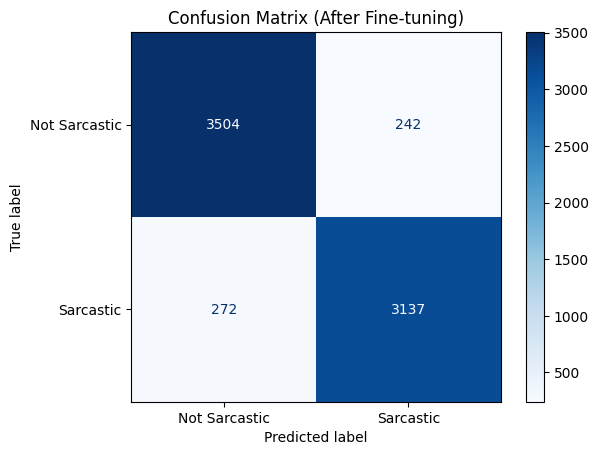


Macro F1 Score (AFTER): 0.9280
Weighted F1 Score (AFTER): 0.9281

--- Visualizing Feature Importance (Before Fine-tuning) ---


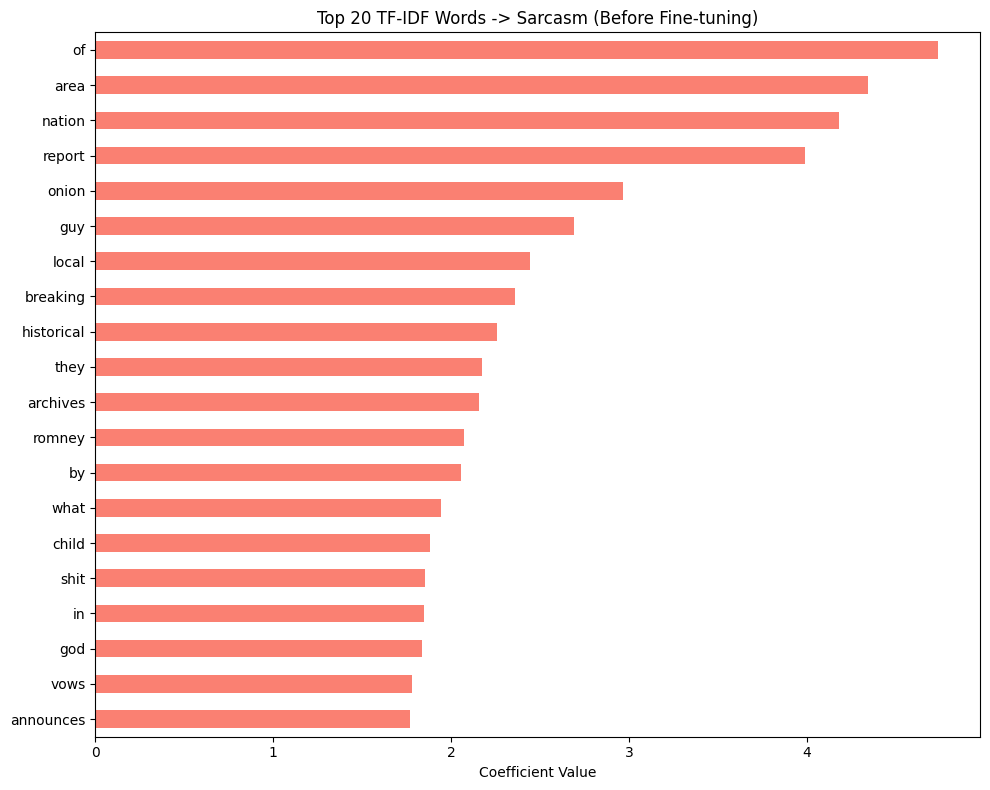

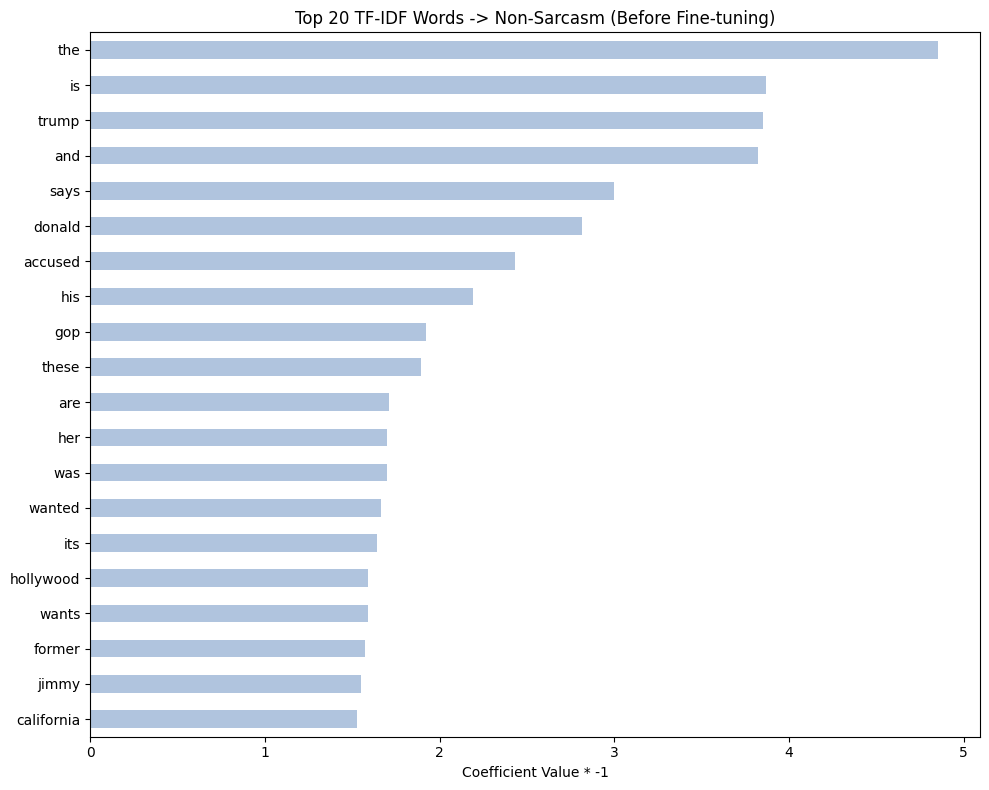

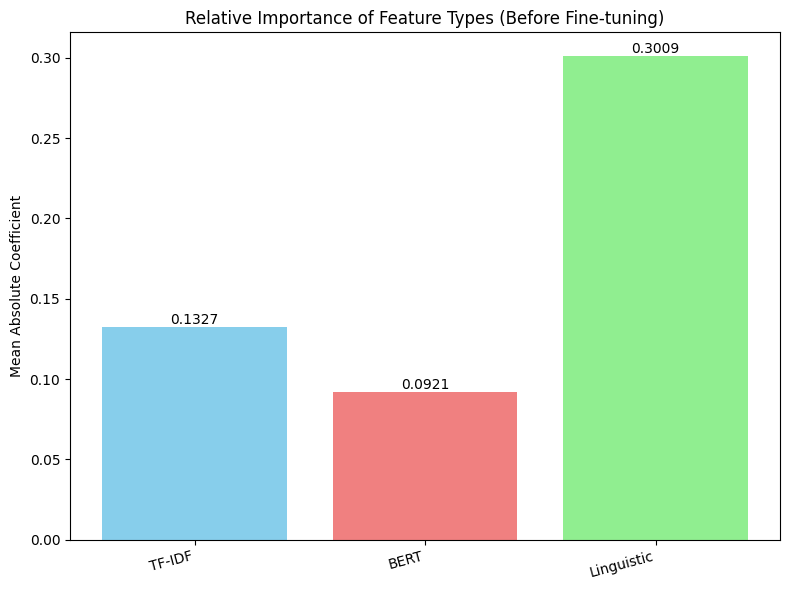

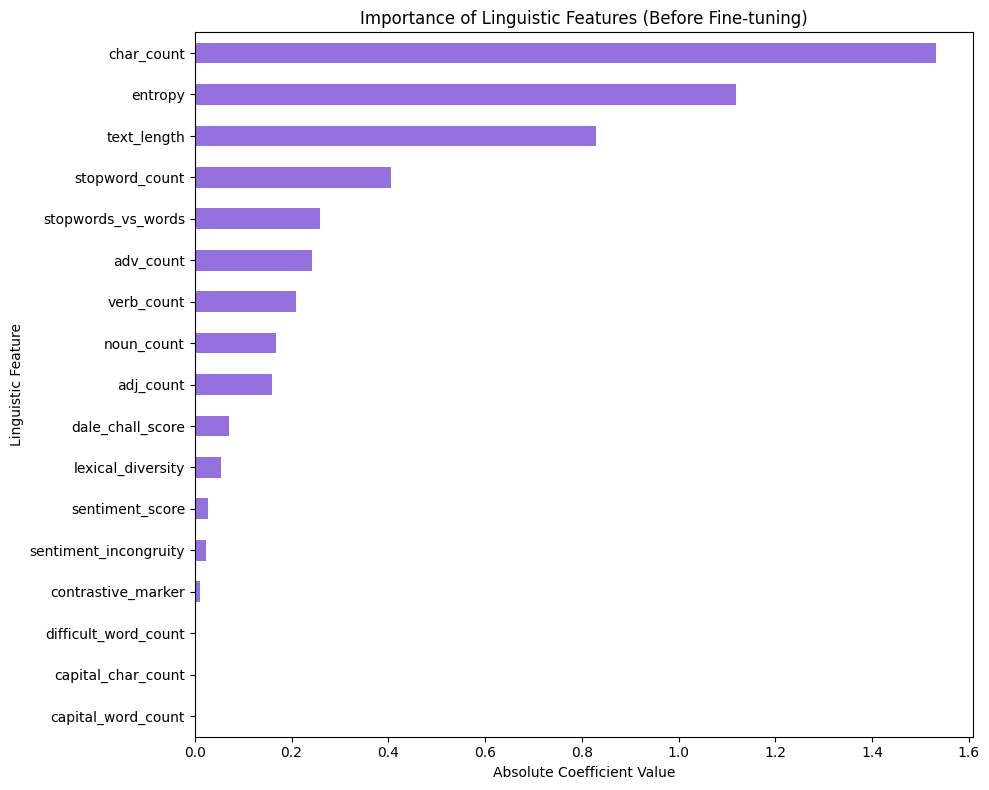


--- Visualizing Feature Importance (After Fine-tuning (Dist Weighted)) ---


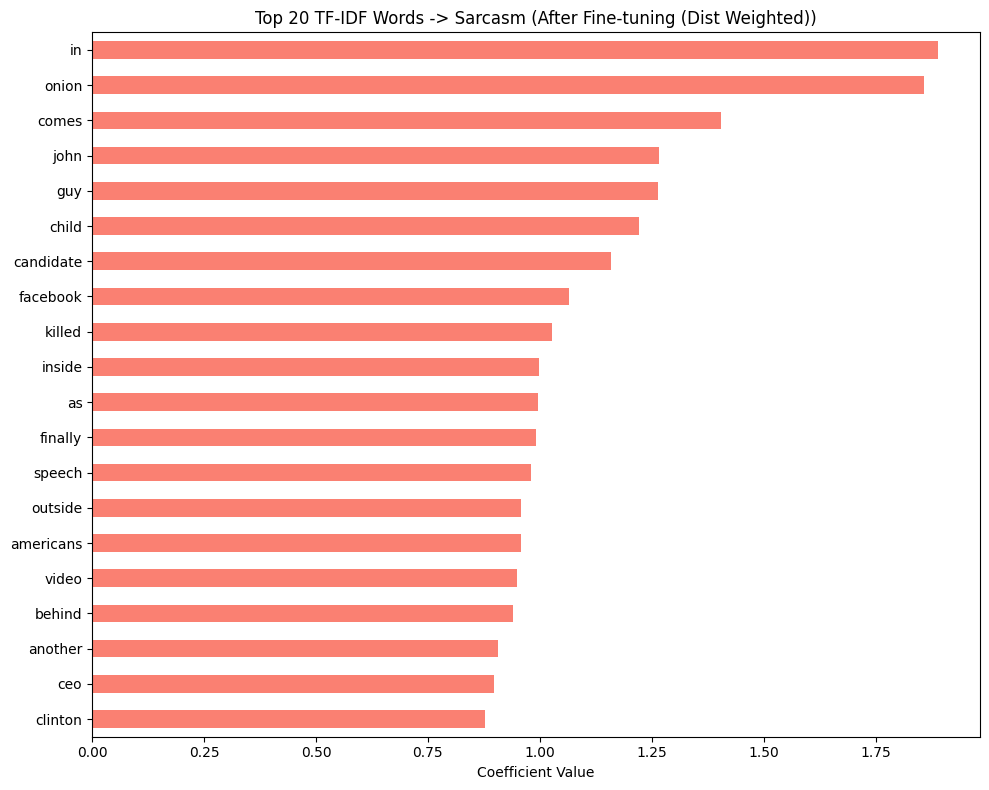

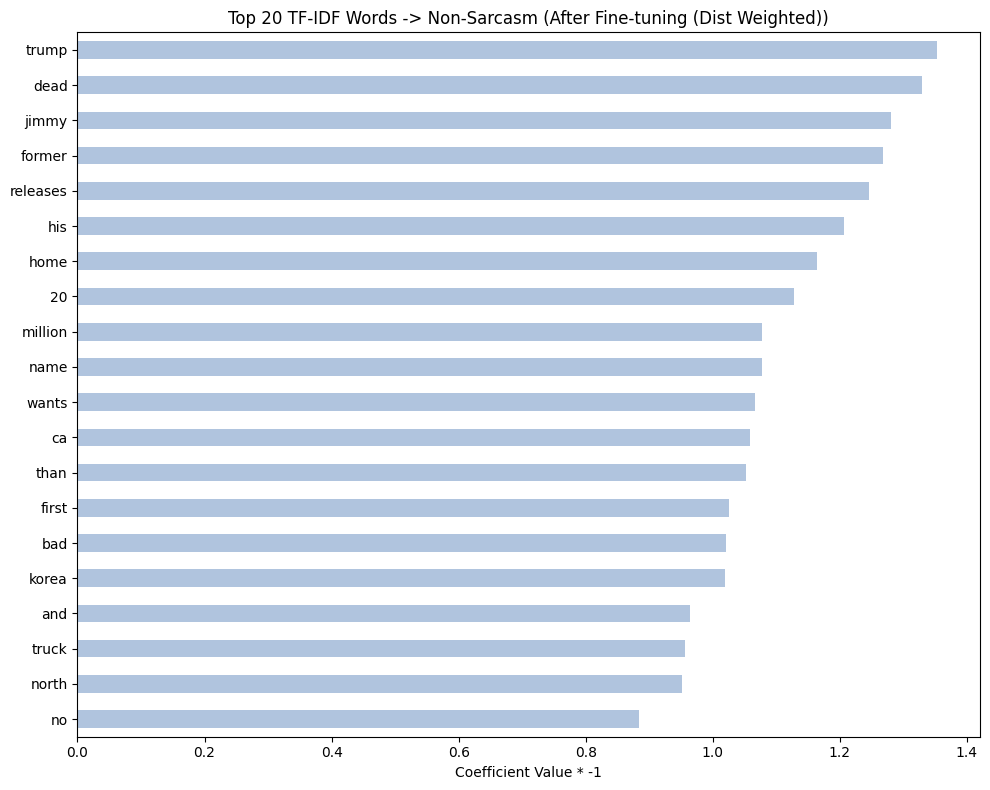

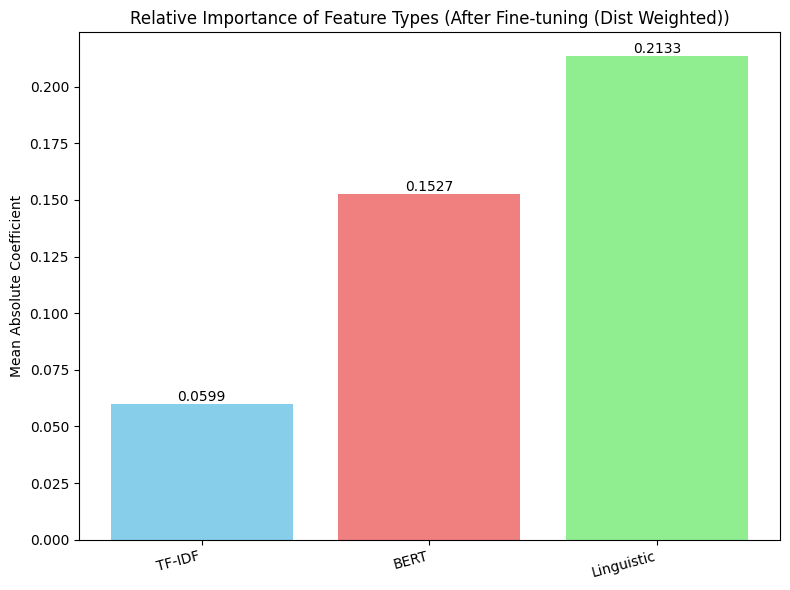

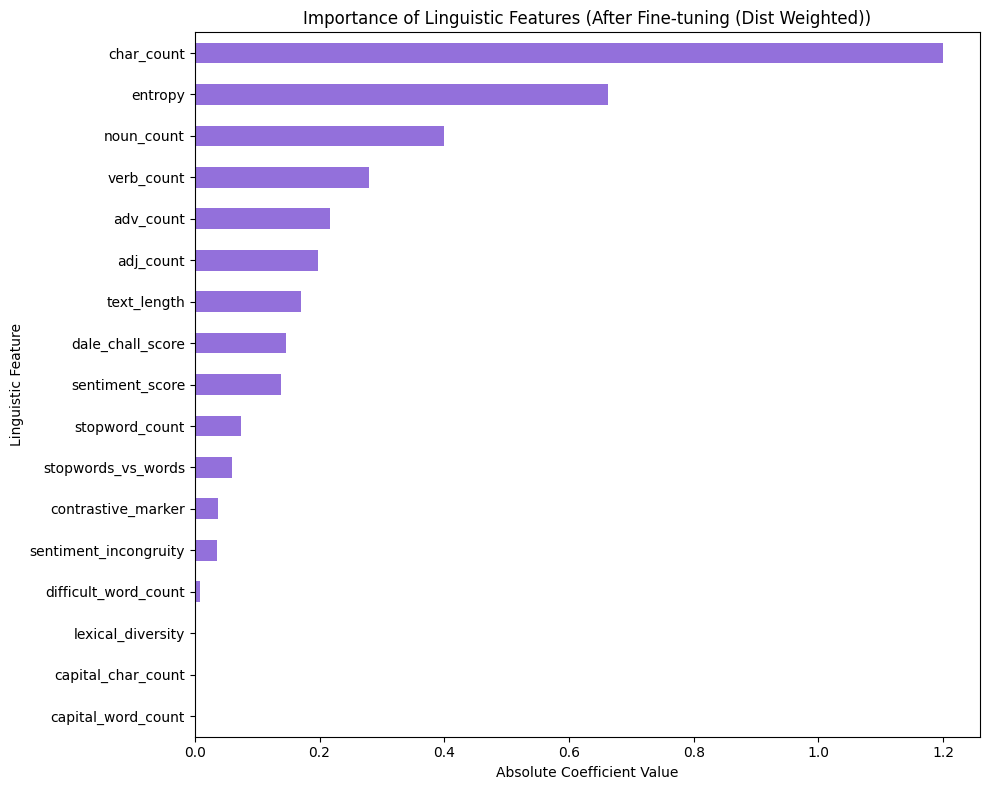


--- Examples of Test Headlines Predicted as Sarcastic (After Fine-tuning) ---
- "bartender going to pretend that last drink was supposed to be served on fire" (Actual: Sarcastic)
- "sat found to be biased in favor of non-hungover" (Actual: Sarcastic)
- "fugitive movie heroine cuts own hair perfectly" (Actual: Sarcastic)
- "barista gets sick little thrill telling coffee shop customers there no restroom" (Actual: Sarcastic)
- "reddi-wip casually announces their nozzles can easily fit into most orifices" (Actual: Sarcastic)
- "capsizing boat passes u.s. in global quality of life rankings" (Actual: Sarcastic)
- "chinese tv show canceled after drawing only 180 million viewers" (Actual: Sarcastic)
- "aretha franklin institute for female entrepreneurship confirms sisters are doin' it for themselves" (Actual: Sarcastic)
- "bush vomiting again" (Actual: Sarcastic)
- "area father remembers when he thought killing family, self was crazy" (Actual: Sarcastic)
- "graffiti artist no longer putting h

In [ ]:
# --- Logistic Regression Model (BEFORE Fine-tuning) ---
print("\n--- Training Downstream Classifier (BEFORE Fine-tuning) ---")
lr_before = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=RANDOM_STATE)
print("Training LR model (BEFORE)...")
train_start_time = time.time()
lr_before.fit(X_train_combined_before, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")



print("\nEvaluating LR model (BEFORE) on the test set...")
y_pred_before = lr_before.predict(X_test_combined_before)
print("\nClassification Report (BEFORE):")
print(classification_report(y_test, y_pred_before, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))
print(f"Macro F1 Score (BEFORE): {f1_score(y_test, y_pred_before, average='macro', zero_division=0):.4f}")

# --- Logistic Regression Model (AFTER Fine-tuning) ---
print("\n--- Training Downstream Classifier (AFTER Fine-tuning) ---")
lr_after = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=RANDOM_STATE)
print("Training LR model (AFTER)...")
train_start_time = time.time()
lr_after.fit(X_train_combined_after, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")

print("\nEvaluating LR model (AFTER) on the test set...")
y_pred_after = lr_after.predict(X_test_combined_after)
y_pred_proba_after = lr_after.predict_proba(X_test_combined_after)[:, 1]
print("\nClassification Report (AFTER):")
print(classification_report(y_test, y_pred_after, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))
print("\nConfusion Matrix (AFTER):")
try:
    cm = confusion_matrix(y_test, y_pred_after, labels=lr_after.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot(cmap=plt.cm.Blues); plt.title("Confusion Matrix (After Fine-tuning)"); plt.show()
except ImportError: print(confusion_matrix(y_test, y_pred_after, labels=lr_after.classes_))
print(f"\nMacro F1 Score (AFTER): {f1_score(y_test, y_pred_after, average='macro', zero_division=0):.4f}")
print(f"Weighted F1 Score (AFTER): {f1_score(y_test, y_pred_after, average='weighted', zero_division=0):.4f}")


# --- Feature Importance Visualization Function ---
def visualize_feature_importance(lr_model, model_label, num_tfidf, num_bert, ling_names, tfidf_names):
    print(f"\n--- Visualizing Feature Importance ({model_label}) ---")
    if not hasattr(lr_model, 'coef_'):
        print(f"Skipping visualization for {model_label}: Model coefficients not found.")
        return

    coefficients = lr_model.coef_[0]
    num_ling = len(ling_names)
    total_expected = num_tfidf + num_bert + num_ling

    if len(coefficients) != total_expected:
        print(f"Error ({model_label}): Coeff count ({len(coefficients)}) != expected ({total_expected}). Cannot visualize.")
        return

    # --- TF-IDF Words ---
    if num_tfidf > 0:
        tfidf_coeffs = coefficients[:num_tfidf]
        tfidf_importance = pd.Series(tfidf_coeffs, index=tfidf_names)
        N_WORDS = 20
        top_sarcastic = tfidf_importance.nlargest(N_WORDS)
        top_non_sarcastic = tfidf_importance.nsmallest(N_WORDS)
        plt.figure(figsize=(10, 8)); top_sarcastic.sort_values().plot(kind='barh', color='salmon')
        plt.title(f'Top {N_WORDS} TF-IDF Words -> Sarcasm ({model_label})'); plt.xlabel('Coefficient Value'); plt.tight_layout(); plt.show()
        plt.figure(figsize=(10, 8)); (top_non_sarcastic * -1).sort_values().plot(kind='barh', color='lightsteelblue')
        plt.title(f'Top {N_WORDS} TF-IDF Words -> Non-Sarcasm ({model_label})'); plt.xlabel('Coefficient Value * -1'); plt.tight_layout(); plt.show()
    else: print(f"No TF-IDF features to visualize for {model_label}.")

    # --- Feature Types ---
    bert_coeffs = coefficients[num_tfidf : num_tfidf + num_bert]
    ling_coeffs = coefficients[num_tfidf + num_bert :]
    mean_abs_tfidf = np.mean(np.abs(tfidf_coeffs)) if num_tfidf > 0 else 0
    mean_abs_bert = np.mean(np.abs(bert_coeffs)) if num_bert > 0 else 0
    mean_abs_ling = np.mean(np.abs(ling_coeffs)) if num_ling > 0 else 0
    feature_types = ['TF-IDF', 'BERT', 'Linguistic']
    mean_abs_coeffs = [mean_abs_tfidf, mean_abs_bert, mean_abs_ling]
    plt.figure(figsize=(8, 6)); bars = plt.bar(feature_types, mean_abs_coeffs, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.ylabel('Mean Absolute Coefficient'); plt.title(f'Relative Importance of Feature Types ({model_label})'); plt.xticks(rotation=15, ha='right')
    for bar in bars: yval = bar.get_height(); plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')
    plt.tight_layout(); plt.show()

    # --- Linguistic Features ---
    if num_ling > 0:
        ling_importance = pd.Series(np.abs(ling_coeffs), index=ling_names).sort_values(ascending=False)
        plt.figure(figsize=(10, 8)); bars = ling_importance.plot(kind='barh', color='mediumpurple')
        plt.xlabel('Absolute Coefficient Value'); plt.ylabel('Linguistic Feature'); plt.title(f'Importance of Linguistic Features ({model_label})')
        plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()
    else: print(f"No linguistic features to visualize for {model_label}.")


# --- Run Visualizations ---
num_ling_features_ = len(ling_feature_names)

# Visualize for BEFORE fine-tuning model
visualize_feature_importance(lr_before, "Before Fine-tuning", num_tfidf_features_, num_bert_features_, ling_feature_names, tfidf_feature_names_)

# Visualize for AFTER fine-tuning model
visualize_feature_importance(lr_after, "After Fine-tuning (Dist Weighted)", num_tfidf_features_, num_bert_features_, ling_feature_names, tfidf_feature_names_)


# Show example predictions (optional - for the 'after' model)
print(f"\n--- Examples of Test Headlines Predicted as Sarcastic ({'After Fine-tuning'}) ---")
predicted_sarcastic_indices = np.where(y_pred_after == 1)[0]
num_examples_to_show = 15
if len(predicted_sarcastic_indices) > 0:
    example_indices = np.random.choice(predicted_sarcastic_indices, min(num_examples_to_show, len(predicted_sarcastic_indices)), replace=False)
    for original_index in example_indices:
         actual_label = y_test[original_index]; label_text = "Sarcastic" if actual_label == 1 else "Not Sarcastic"
         print(f"- \"{df_test.iloc[original_index]['headline']}\" (Actual: {label_text})")
else: print("Model (After) did not predict any test headlines as sarcastic.")


print("\n--- Script Finished ---")

### Iterations of t-sne


--- Starting Embedding Visualization (t-SNE) ---
Using sample of 1000 for t-SNE.
Sampled 1000 points. Mapping created.

Running t-SNE BEFORE fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.149786


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.710510
[t-SNE] KL divergence after 350 iterations: 1.714854
t-SNE 'before' finished: 7.45s.


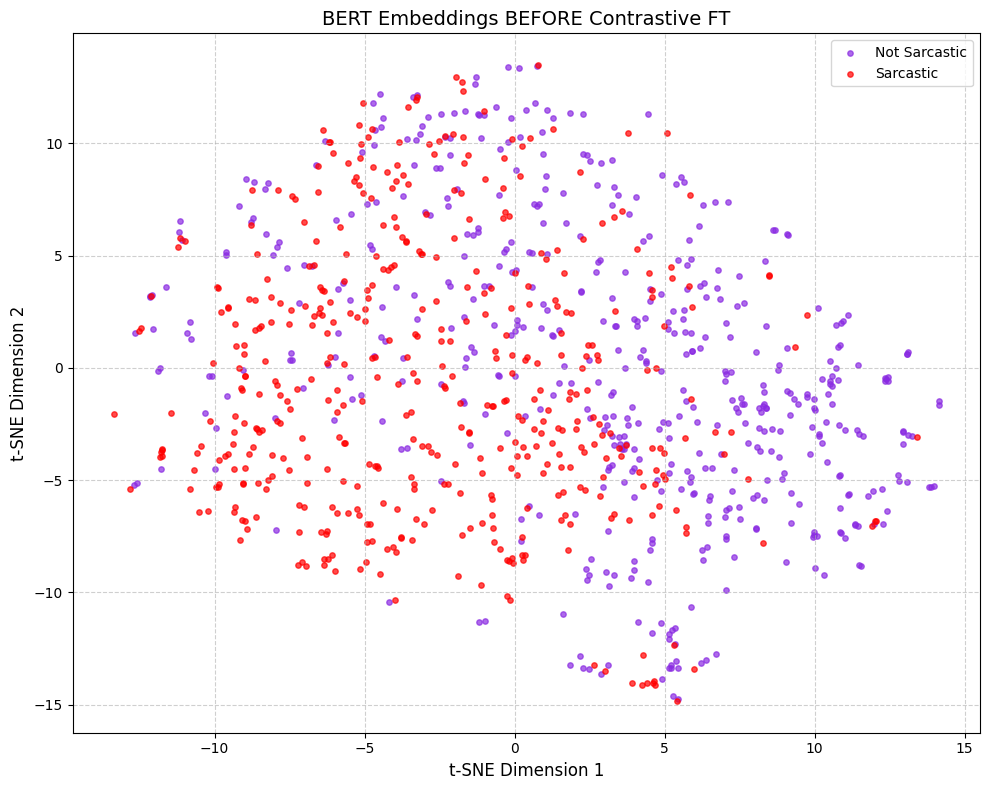


Running t-SNE AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.197185


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.505878
[t-SNE] KL divergence after 350 iterations: 1.276125
t-SNE 'after' finished: 4.15s.

Plotting t-SNE AFTER fine-tuning (Original View)...


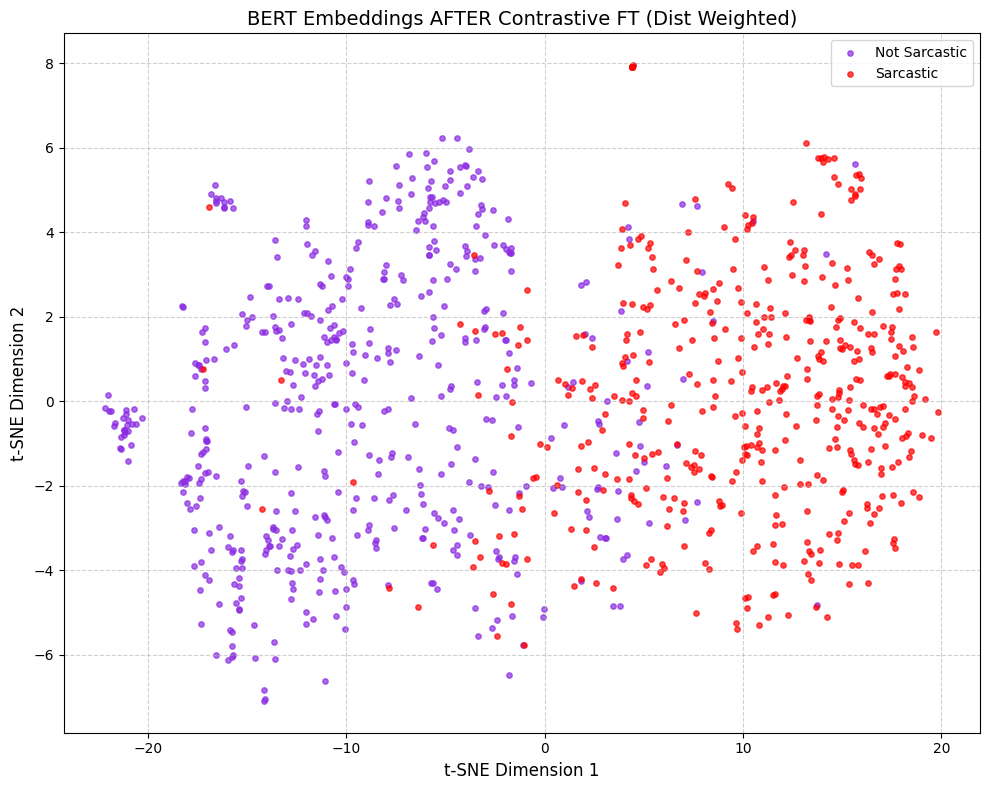


Plotting t-SNE AFTER fine-tuning (Highlighting Misclassified)...
Highlighting 87 misclassified points on the plot.


<ipython-input-26-5a29b8fa291b>:43: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings_2d[valid_misclassified_indices, 0],


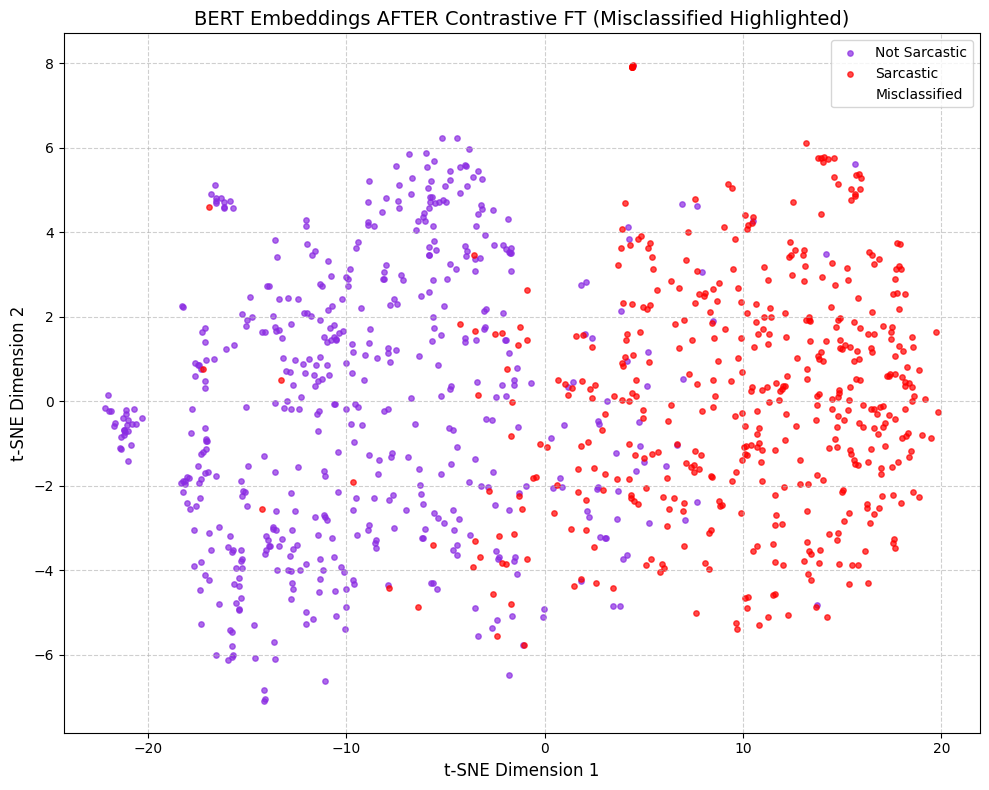


Plotting t-SNE AFTER fine-tuning (Colored by Error Type)...


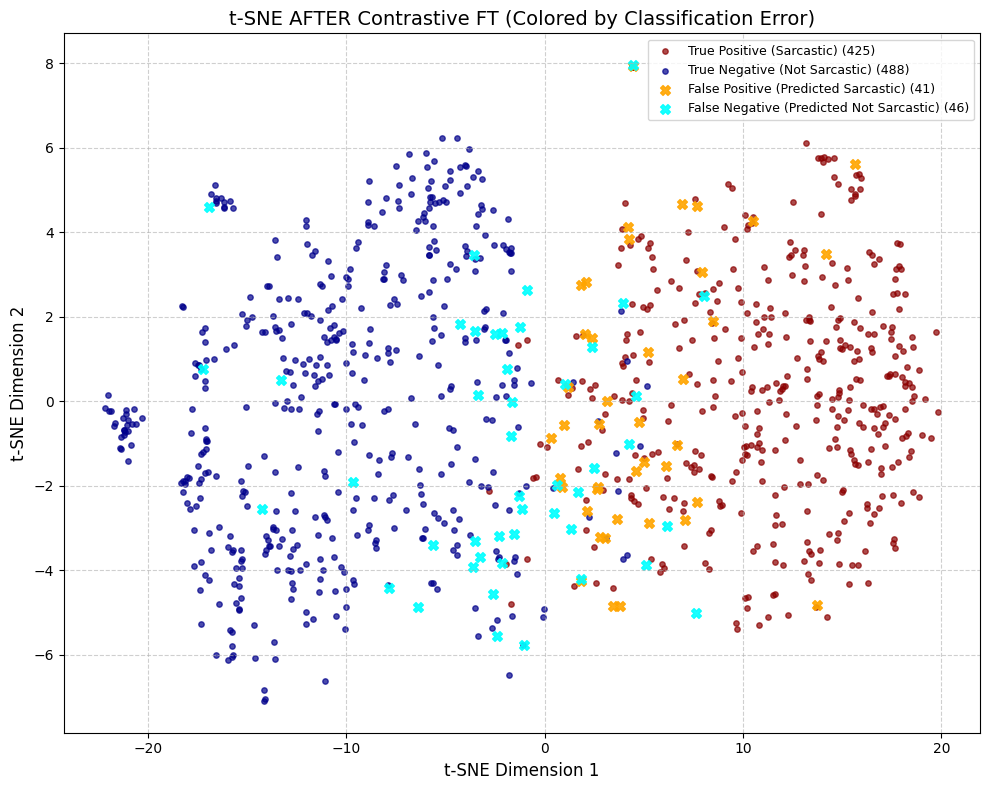

--- Embedding Visualization Finished ---

--- Analyzing Misclassifications (After Fine-tuning) ---
Total misclassified samples in test set: 514

--- False Positives (Predicted Sarcastic, Actual Not Sarcastic) [242 total] ---
(Showing up to 20 examples)
  - Headline: "u.s.-trained syria rebels hand over equipment to al qaeda affiliate"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.996, t-SNE Coords: (6.65, -1.04)
  - Headline: "new united airlines policy scraps last-minute boarding for crew members"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.980, t-SNE Coords: Not Plotted
  - Headline: "kitten valiantly attempts high five"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.750, t-SNE Coords: (8.48, 1.91)
  - Headline: "beauty queen scarfs down 12 krispy kreme doughnuts in no time"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.925, t-SNE Coords: Not Plotted
  - Headline: "man builds rad all-terrain whee

In [ ]:
# --- Visualization Section (t-SNE) ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")

# --- Plotting Function 1: Original with Optional Highlighting ---
def plot_embeddings(embeddings_2d, labels, title, misclassified_indices=None, highlight_color='black', highlight_marker='x', highlight_size=50):
    """
    Plots 2D embeddings, colored by label, with optional highlighting for specific indices.
    Args:
        embeddings_2d: The 2D embedding array (N, 2).
        labels: The true labels for each point (N,).
        title: The plot title.
        misclassified_indices: Optional list or array of indices within embeddings_2d
                               that correspond to misclassified points.
        highlight_color: Color for the highlight marker.
        highlight_marker: Marker style for highlighted points.
        highlight_size: Size of the highlight marker.
    """
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    # Use specific colors for consistency if binary
    if set(unique_labels) == {0, 1}:
        colors = {0: 'blueviolet', 1: 'red'} # Match original plot colors
        label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}
    else: # Fallback for multi-class
        colors_list = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        colors = {label: color for label, color in zip(unique_labels, colors_list)}
        label_map = {label: f"Class {label}" for label in unique_labels}

    # Plot main points
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=[colors[label]], label=label_map.get(label, f"Class {label}"),
                    alpha=0.7, s=15)

    # Plot highlighted misclassified points on top
    if misclassified_indices is not None and len(misclassified_indices) > 0:
        valid_misclassified_indices = [idx for idx in misclassified_indices if idx < embeddings_2d.shape[0]]
        if valid_misclassified_indices:
            # Plot only once for the legend entry
            plt.scatter(embeddings_2d[valid_misclassified_indices, 0],
                        embeddings_2d[valid_misclassified_indices, 1],
                        marker=highlight_marker, s=highlight_size,
                        facecolor='none', edgecolor=highlight_color,
                        linewidth=1.5, label='Misclassified') # Add to legend
            print(f"Highlighting {len(valid_misclassified_indices)} misclassified points on the plot.")
        else:
            print("No valid misclassified indices to highlight.")

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()


# --- Plotting Function 2: Colored by Error Type ---
def plot_embeddings_by_error_type(embeddings_2d, true_labels, predicted_labels, title):
    """Plots 2D embeddings colored by classification outcome (TP, TN, FP, FN)."""
    plt.figure(figsize=(10, 8))
    is_correct = (true_labels == predicted_labels)
    is_sarcastic_true = (true_labels == 1)
    is_sarcastic_pred = (predicted_labels == 1)

    tp_mask = is_correct & is_sarcastic_true
    tn_mask = is_correct & ~is_sarcastic_true
    fp_mask = ~is_correct & is_sarcastic_pred
    fn_mask = ~is_correct & ~is_sarcastic_pred

    masks = {'True Positive (Sarcastic)': tp_mask, 'True Negative (Not Sarcastic)': tn_mask,
             'False Positive (Predicted Sarcastic)': fp_mask, 'False Negative (Predicted Not Sarcastic)': fn_mask}
    colors = {'True Positive (Sarcastic)': 'darkred', 'True Negative (Not Sarcastic)': 'darkblue',
              'False Positive (Predicted Sarcastic)': 'orange', 'False Negative (Predicted Not Sarcastic)': 'cyan'}
    markers = {'True Positive (Sarcastic)': 'o', 'True Negative (Not Sarcastic)': 'o',
               'False Positive (Predicted Sarcastic)': 'X', 'False Negative (Predicted Not Sarcastic)': 'X'}
    sizes = {'True Positive (Sarcastic)': 15, 'True Negative (Not Sarcastic)': 15,
             'False Positive (Predicted Sarcastic)': 50, 'False Negative (Predicted Not Sarcastic)': 50}

    for label, mask in masks.items():
        indices = np.where(mask)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=colors[label], marker=markers[label], s=sizes[label],
                    alpha=0.7 if markers[label] == 'o' else 0.9,
                    label=f"{label} ({len(valid_indices)})")

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(fontsize=9, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(); plt.show()


# --- Run t-SNE and Generate Plots ---
tsne_coords_available = False
embeddings_2d_after = None # Initialize
labels_for_plot = None     # Initialize
plotted_indices_original = None # Initialize
original_to_sample_idx_map = None # Initialize

if X_bert_test_before_ft.shape[0] == 0 or X_bert_test_after_ft.shape[0] == 0:
    print("Skipping t-SNE visualization due to empty embeddings.")
else:
    embeddings_to_tsne_before, embeddings_to_tsne_after, y_labels_for_tsne = X_bert_test_before_ft, X_bert_test_after_ft, y_test
    plotted_indices_original = np.arange(len(y_labels_for_tsne)) # Assume all points plotted initially

    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_labels_for_tsne):
        print(f"Using sample of {VISUALIZATION_SAMPLE_SIZE} for t-SNE.")
        actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_labels_for_tsne))
        try:
            sample_indices = np.random.choice(len(y_labels_for_tsne), actual_sample_size, replace=False)
            embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
            embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
            labels_for_plot = y_labels_for_tsne[sample_indices] # These are the labels for the PLOTTED points
            plotted_indices_original = sample_indices # Store the original indices that were sampled
            # Create mapping from original index to the index within the sampled data
            original_to_sample_idx_map = {orig_idx: sample_idx for sample_idx, orig_idx in enumerate(plotted_indices_original)}
            print(f"Sampled {len(labels_for_plot)} points. Mapping created.")
        except ValueError as e:
            print(f"Error sampling: {e}. Skipping t-SNE.")
            embeddings_to_tsne_before = None # Prevent further processing
            embeddings_to_tsne_after = None
    else:
        print("Using all test points for t-SNE.")
        labels_for_plot = y_labels_for_tsne # Labels for all points
        # Direct mapping if no sampling
        original_to_sample_idx_map = {idx: idx for idx in plotted_indices_original}


    # --- Plot t-SNE BEFORE ---
    if embeddings_to_tsne_before is not None and embeddings_to_tsne_before.shape[0] > 1:
        print("\nRunning t-SNE BEFORE fine-tuning..."); start_tsne = time.time()
        tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(TSNE_PERPLEXITY, embeddings_to_tsne_before.shape[0] - 1), n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try:
            embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
            print(f"t-SNE 'before' finished: {time.time() - start_tsne:.2f}s.")
            plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive FT")
        except Exception as e: print(f"Error running/plotting t-SNE (before): {e}")

    # --- Plot t-SNE AFTER (Multiple Views) ---
    if embeddings_to_tsne_after is not None and embeddings_to_tsne_after.shape[0] > 1:
        print("\nRunning t-SNE AFTER fine-tuning..."); start_tsne = time.time()
        tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(TSNE_PERPLEXITY, embeddings_to_tsne_after.shape[0] - 1), n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try:
            embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
            tsne_coords_available = True # Mark coords as available
            print(f"t-SNE 'after' finished: {time.time() - start_tsne:.2f}s.")

            # --- Get predictions ONLY for the plotted samples ---
            # Ensure y_pred_after exists (should be calculated earlier)
            if 'y_pred_after' not in locals():
                 print("Error: 'y_pred_after' not found. Cannot generate misclassification plots.")
            else:
                predicted_labels_for_plot = y_pred_after[plotted_indices_original]

                # --- Find misclassified indices WITHIN the plotted sample ---
                misclassified_mask_plot = (labels_for_plot != predicted_labels_for_plot)
                misclassified_indices_in_plot_relative = np.where(misclassified_mask_plot)[0] # Indices relative to embeddings_2d_after

                # --- Plot 1: Original view (color by true label) ---
                print("\nPlotting t-SNE AFTER fine-tuning (Original View)...")
                plot_embeddings(embeddings_2d_after, labels_for_plot, "BERT Embeddings AFTER Contrastive FT (Dist Weighted)")

                # --- Plot 2: Original view WITH highlighted errors ---
                print("\nPlotting t-SNE AFTER fine-tuning (Highlighting Misclassified)...")
                plot_embeddings(embeddings_2d_after,
                                labels_for_plot,
                                "BERT Embeddings AFTER Contrastive FT (Misclassified Highlighted)",
                                misclassified_indices=misclassified_indices_in_plot_relative)

                # --- Plot 3: Colored by Error Type ---
                print("\nPlotting t-SNE AFTER fine-tuning (Colored by Error Type)...")
                plot_embeddings_by_error_type(embeddings_2d_after,
                                              labels_for_plot,
                                              predicted_labels_for_plot,
                                              "t-SNE AFTER Contrastive FT (Colored by Classification Error)")

        except Exception as e:
            print(f"Error running/plotting t-SNE (after): {e}")
            tsne_coords_available = False # Reset flag on error

    else: print("Insufficient data for t-SNE (after).")
print("--- Embedding Visualization Finished ---")


# --- Misclassification Analysis (Textual Printout) ---
print("\n--- Analyzing Misclassifications (After Fine-tuning) ---")

# Ensure predictions are available
if 'y_pred_after' not in locals():
    print("Cannot perform misclassification analysis: 'y_pred_after' not found.")
else:
    # 1. Identify all misclassified indices in the original test set
    misclassified_mask_original = (y_test != y_pred_after)
    misclassified_indices_original = np.where(misclassified_mask_original)[0]
    num_misclassified = len(misclassified_indices_original)
    print(f"Total misclassified samples in test set: {num_misclassified}")

    misclassified_samples_info = []
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}

    # 2. Gather information for ALL misclassified samples
    for original_idx in misclassified_indices_original:
        headline_text = df_test.loc[original_idx, 'headline'] # Use original headline
        actual_label = y_test[original_idx]
        predicted_label = y_pred_after[original_idx]
        probability = y_pred_proba_after[original_idx] if 'y_pred_proba_after' in locals() else None

        coords_str = "Not Plotted" # Default
        if tsne_coords_available and original_to_sample_idx_map is not None:
            sample_idx = original_to_sample_idx_map.get(original_idx) # Check if this original index was plotted
            if sample_idx is not None and sample_idx < len(embeddings_2d_after):
                coords = embeddings_2d_after[sample_idx]
                coords_str = f"({coords[0]:.2f}, {coords[1]:.2f})"
            # else: sample was misclassified but not included in the t-SNE sample plot

        misclassified_samples_info.append({
            "original_index": original_idx,
            "headline": headline_text,
            "actual": label_map[actual_label],
            "predicted": label_map[predicted_label],
            "probability_sarcastic": f"{probability:.3f}" if probability is not None else "N/A",
            "tsne_coords": coords_str # Use the determined coordinate string
        })

    # 3. Print the results, separating False Positives and False Negatives
    MAX_EXAMPLES_TO_PRINT = 20 # Limit output length

    false_positives = [s for s in misclassified_samples_info if s["actual"] == 'Not Sarcastic']
    false_negatives = [s for s in misclassified_samples_info if s["actual"] == 'Sarcastic']

    print(f"\n--- False Positives (Predicted Sarcastic, Actual Not Sarcastic) [{len(false_positives)} total] ---")
    if not false_positives:
        print("None found.")
    else:
        print(f"(Showing up to {MAX_EXAMPLES_TO_PRINT} examples)")
        for i, sample in enumerate(false_positives[:MAX_EXAMPLES_TO_PRINT]):
            print(f"  - Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}, t-SNE Coords: {sample['tsne_coords']}")

    print(f"\n--- False Negatives (Predicted Not Sarcastic, Actual Sarcastic) [{len(false_negatives)} total] ---")
    if not false_negatives:
        print("None found.")
    else:
        print(f"(Showing up to {MAX_EXAMPLES_TO_PRINT} examples)")
        for i, sample in enumerate(false_negatives[:MAX_EXAMPLES_TO_PRINT]):
            print(f"  - Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}, t-SNE Coords: {sample['tsne_coords']}")

    print("\n--- End Misclassification Analysis ---")

# (Keep the rest of your script, like feature importance visualization and example predictions)
# ... visualize_feature_importance calls ...
# ... example sarcastic prediction printout ...
# ... print("\n--- Script Finished ---") ...


--- Starting Embedding Visualization (t-SNE) ---
Using sample of 1000 for t-SNE.
Sampled 1000 points. Mapping created.

Running t-SNE BEFORE fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.097237


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.664848
[t-SNE] KL divergence after 350 iterations: 1.736660
t-SNE 'before' finished: 3.29s.
No specific points provided for indexing.


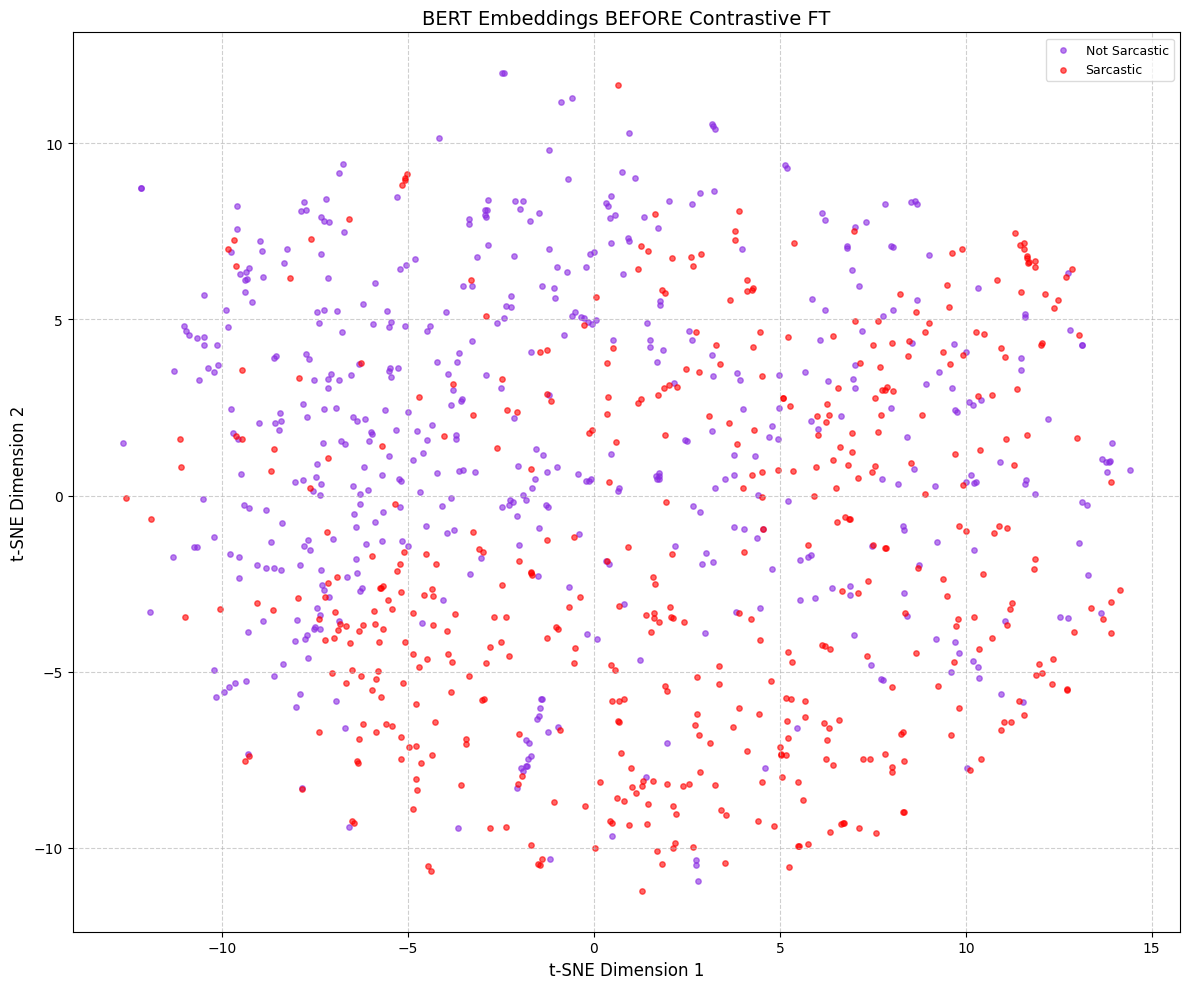


Running t-SNE AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.203641


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.559273
[t-SNE] KL divergence after 350 iterations: 1.285430
t-SNE 'after' finished: 3.04s.
Found 36 False Positives and 52 False Negatives in the plotted data.
Selecting top 10 most confident False Positives for indexing.
Selecting top 10 most confident False Negatives for indexing.

Plotting t-SNE AFTER fine-tuning (Top Confident Misclassified Indexed)...
Adding text indices for 20 points on the plot.


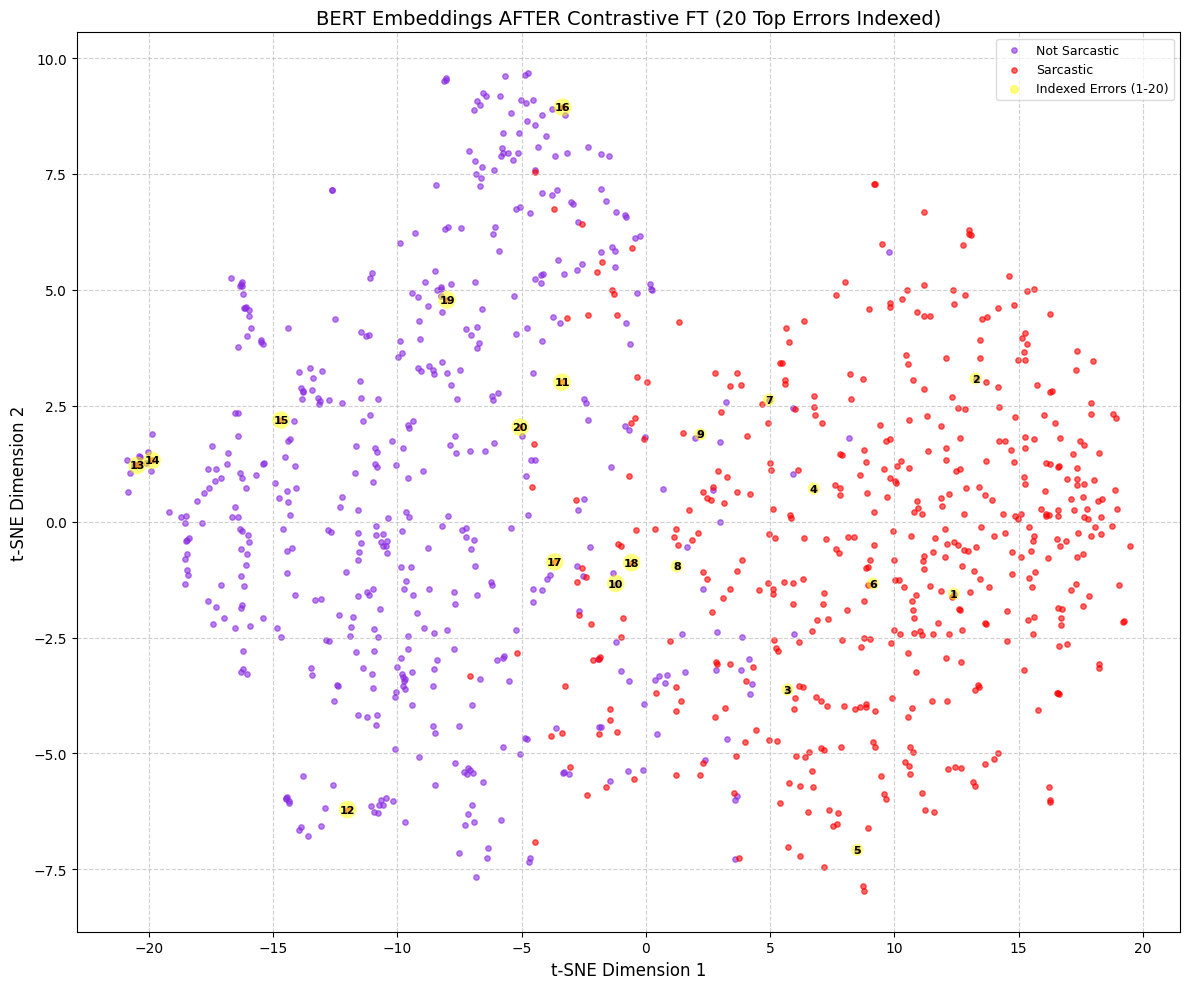


Plotting t-SNE AFTER fine-tuning (Colored by Error Type)...


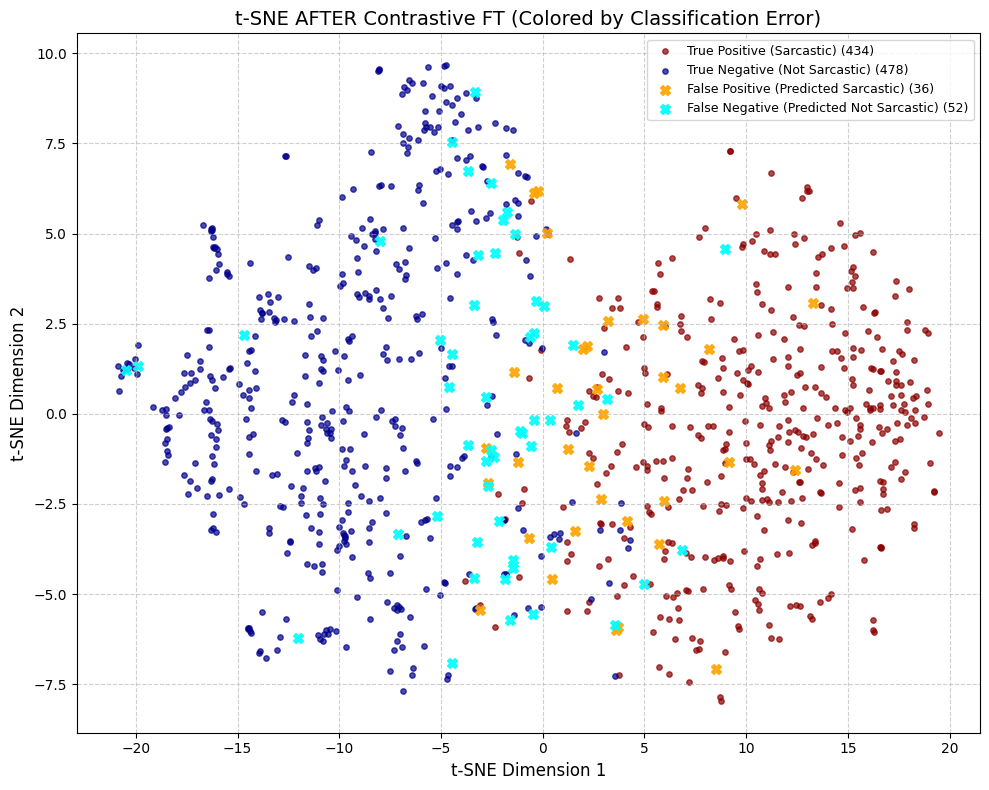

--- Embedding Visualization Finished ---

--- Analysis of INDEXED Top Confident Misclassifications (After Fine-tuning) ---
Details for the 20 points indexed on the plot (sorted by confidence):

--- Indexed Top Confident False Positives (10 shown) ---
  Index 1:
    Headline: "whatsapp finally adds fully-encrypted video calling service"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 1.000
    Confidence in Error: 1.000
    t-SNE Coords: (12.40, -1.55) (Original Index: 4205)
  Index 2:
    Headline: "obamacare repeal possibly going to live on farm upstate"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.996
    Confidence in Error: 0.996
    t-SNE Coords: (13.27, 3.09) (Original Index: 2795)
  Index 3:
    Headline: "jimmy kimmel brings tourists into oscars for highly entertaining bit"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.994
    Confidence in Error: 0.994
    t-SNE Coords: (5.70, -3.62) (Original Index: 4182)
  Index 

In [ ]:
# --- Visualization Section (t-SNE) ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")

# --- Plotting Function 1: Original with Optional INDEXED Highlighting ---
def plot_embeddings(embeddings_2d, labels, title, indexed_points=None, highlight_color='black', text_size=8):
    """
    Plots 2D embeddings, colored by label, with optional text indexing for specific points.

    Args:
        embeddings_2d: The 2D embedding array (N, 2).
        labels: The true labels for each point (N,).
        title: The plot title.
        indexed_points: Optional dictionary where keys are indices within embeddings_2d
                        and values are the text labels (e.g., index numbers) to display.
        highlight_color: Color for the text index.
        text_size: Font size for the text index.
    """
    plt.figure(figsize=(12, 10)) # Slightly larger figure for text
    unique_labels = sorted(np.unique(labels))
    # Use specific colors for consistency if binary
    if set(unique_labels) == {0, 1}:
        colors = {0: 'blueviolet', 1: 'red'} # Match original plot colors
        label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}
    else: # Fallback for multi-class
        colors_list = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        colors = {label: color for label, color in zip(unique_labels, colors_list)}
        label_map = {label: f"Class {label}" for label in unique_labels}

    # Plot main points
    plotted_legend_labels = set() # Track labels added to legend
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        current_label_text = label_map.get(label, f"Class {label}")
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=[colors[label]], label=current_label_text,
                    alpha=0.6, s=15) # Slightly smaller base points?
        plotted_legend_labels.add(current_label_text)

    # Add text index labels for specified points
    indexed_legend_added = False
    if indexed_points is not None and len(indexed_points) > 0:
        plotted_indices_count = 0
        for point_idx, text_label in indexed_points.items():
            if point_idx < embeddings_2d.shape[0]:
                 x, y = embeddings_2d[point_idx, 0], embeddings_2d[point_idx, 1]
                 plt.text(x, y, str(text_label), color=highlight_color, fontsize=text_size,
                          fontweight='bold', ha='center', va='center',
                          bbox=dict(boxstyle='circle,pad=0.1', fc='yellow', alpha=0.5, ec='none')) # Circle background
                 plotted_indices_count += 1
                 # Add a single legend entry for indexed points
                 if not indexed_legend_added :
                      # Add a dummy point outside the axes for the legend
                      plt.scatter([], [], color='yellow', alpha=0.5, s=30, marker='o', label=f'Indexed Errors (1-{len(indexed_points)})')
                      indexed_legend_added = True

        print(f"Adding text indices for {plotted_indices_count} points on the plot.")
    else:
        print("No specific points provided for indexing.")

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    # Combine legends if needed or adjust position
    handles, labels = plt.gca().get_legend_handles_labels()
    # Ensure 'Indexed Errors' appears if added
    unique_labels_in_legend = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels_in_legend:
            unique_labels_in_legend.append(label)
            unique_handles.append(handle)

    plt.legend(unique_handles, unique_labels_in_legend, fontsize=9, loc='best', framealpha=0.7)
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()

# Keep the plot_embeddings_by_error_type function as it was (it's still useful)
def plot_embeddings_by_error_type(embeddings_2d, true_labels, predicted_labels, title):
    """Plots 2D embeddings colored by classification outcome (TP, TN, FP, FN)."""
    plt.figure(figsize=(10, 8))
    is_correct = (true_labels == predicted_labels)
    is_sarcastic_true = (true_labels == 1)
    is_sarcastic_pred = (predicted_labels == 1)

    tp_mask = is_correct & is_sarcastic_true
    tn_mask = is_correct & ~is_sarcastic_true
    fp_mask = ~is_correct & is_sarcastic_pred
    fn_mask = ~is_correct & ~is_sarcastic_pred

    masks = {'True Positive (Sarcastic)': tp_mask, 'True Negative (Not Sarcastic)': tn_mask,
             'False Positive (Predicted Sarcastic)': fp_mask, 'False Negative (Predicted Not Sarcastic)': fn_mask}
    colors = {'True Positive (Sarcastic)': 'darkred', 'True Negative (Not Sarcastic)': 'darkblue',
              'False Positive (Predicted Sarcastic)': 'orange', 'False Negative (Predicted Not Sarcastic)': 'cyan'}
    markers = {'True Positive (Sarcastic)': 'o', 'True Negative (Not Sarcastic)': 'o',
               'False Positive (Predicted Sarcastic)': 'X', 'False Negative (Predicted Not Sarcastic)': 'X'}
    sizes = {'True Positive (Sarcastic)': 15, 'True Negative (Not Sarcastic)': 15,
             'False Positive (Predicted Sarcastic)': 50, 'False Negative (Predicted Not Sarcastic)': 50}

    for label, mask in masks.items():
        indices = np.where(mask)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=colors[label], marker=markers[label], s=sizes[label],
                    alpha=0.7 if markers[label] == 'o' else 0.9,
                    label=f"{label} ({len(valid_indices)})")

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(fontsize=9, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(); plt.show()

# (Keep the plotting function definitions `plot_embeddings` and `plot_embeddings_by_error_type` as defined in the previous step)

# --- Run t-SNE and Generate Plots ---
tsne_coords_available = False
embeddings_2d_after = None # Initialize
labels_for_plot = None     # Initialize
plotted_indices_original = None # Initialize
original_to_sample_idx_map = None # Initialize
N_TO_INDEX = 10 # Number of TOP FPs and FNs to index

if X_bert_test_before_ft.shape[0] == 0 or X_bert_test_after_ft.shape[0] == 0:
    print("Skipping t-SNE visualization due to empty embeddings.")
else:
    # --- Sampling Logic (same as before) ---
    embeddings_to_tsne_before, embeddings_to_tsne_after, y_labels_for_tsne = X_bert_test_before_ft, X_bert_test_after_ft, y_test
    plotted_indices_original = np.arange(len(y_labels_for_tsne)) # Assume all points plotted initially

    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_labels_for_tsne):
        print(f"Using sample of {VISUALIZATION_SAMPLE_SIZE} for t-SNE.")
        actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_labels_for_tsne))
        try:
            sample_indices = np.random.choice(len(y_labels_for_tsne), actual_sample_size, replace=False)
            embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
            embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
            labels_for_plot = y_labels_for_tsne[sample_indices]
            plotted_indices_original = sample_indices
            original_to_sample_idx_map = {orig_idx: sample_idx for sample_idx, orig_idx in enumerate(plotted_indices_original)}
            print(f"Sampled {len(labels_for_plot)} points. Mapping created.")
        except ValueError as e:
            print(f"Error sampling: {e}. Skipping t-SNE.")
            embeddings_to_tsne_before, embeddings_to_tsne_after = None, None
    else:
        print("Using all test points for t-SNE.")
        labels_for_plot = y_labels_for_tsne
        original_to_sample_idx_map = {idx: idx for idx in plotted_indices_original}

    # --- Plot t-SNE BEFORE (same as before) ---
    if embeddings_to_tsne_before is not None and embeddings_to_tsne_before.shape[0] > 1:
        print("\nRunning t-SNE BEFORE fine-tuning..."); start_tsne = time.time()
        tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(TSNE_PERPLEXITY, embeddings_to_tsne_before.shape[0] - 1), n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try:
            embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
            print(f"t-SNE 'before' finished: {time.time() - start_tsne:.2f}s.")
            plot_labels = labels_for_plot if labels_for_plot is not None else y_labels_for_tsne
            plot_embeddings(embeddings_2d_before, plot_labels, "BERT Embeddings BEFORE Contrastive FT")
        except Exception as e: print(f"Error running/plotting t-SNE (before): {e}")


    # --- Run t-SNE AFTER and Prepare for Indexed Plotting (Confidence-Based) ---
    indexed_points_for_plot = {} # Dict: {relative_index: display_index}
    indexed_details = {} # Dict: {display_index: {details}}

    if embeddings_to_tsne_after is not None and embeddings_to_tsne_after.shape[0] > 1:
        print("\nRunning t-SNE AFTER fine-tuning..."); start_tsne = time.time()
        tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(TSNE_PERPLEXITY, embeddings_to_tsne_after.shape[0] - 1), n_iter=TSNE_N_ITER, verbose=1, n_jobs=-1)
        try:
            embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
            tsne_coords_available = True
            print(f"t-SNE 'after' finished: {time.time() - start_tsne:.2f}s.")

            # --- Get predictions and probabilities ONLY for the plotted samples ---
            if 'y_pred_after' not in locals() or 'y_pred_proba_after' not in locals():
                 print("Error: 'y_pred_after' or 'y_pred_proba_after' not found. Cannot generate misclassification plots/analysis.")
            else:
                predicted_labels_for_plot = y_pred_after[plotted_indices_original]
                # Ensure probabilities are for class 1 (Sarcastic)
                if y_pred_proba_after.ndim == 2 and y_pred_proba_after.shape[1] == 2:
                    probabilities_for_plot = y_pred_proba_after[plotted_indices_original, 1]
                elif y_pred_proba_after.ndim == 1: # If predict_proba somehow only returned prob for class 1
                     probabilities_for_plot = y_pred_proba_after[plotted_indices_original]
                else:
                     print("Error: Unexpected shape for y_pred_proba_after. Cannot determine probabilities.")
                     raise ValueError("Incorrect probability shape.")


                # --- Identify misclassified points WITHIN the plotted sample ---
                misclassified_mask_plot = (labels_for_plot != predicted_labels_for_plot)
                misclassified_indices_relative = np.where(misclassified_mask_plot)[0] # Indices relative to embeddings_2d_after

                # --- Separate FPs and FNs within the PLOTTED sample and calculate confidence ---
                fp_confidence_scores = [] # List of (confidence_score, relative_index)
                fn_confidence_scores = [] # List of (confidence_score, relative_index)

                for rel_idx in misclassified_indices_relative:
                    true_label = labels_for_plot[rel_idx]
                    pred_label = predicted_labels_for_plot[rel_idx]
                    prob_sarcastic = probabilities_for_plot[rel_idx]

                    if pred_label == 1 and true_label == 0: # False Positive
                        confidence = prob_sarcastic # Confidence is the high prob of the wrong class (1)
                        fp_confidence_scores.append((confidence, rel_idx))
                    elif pred_label == 0 and true_label == 1: # False Negative
                        confidence = 1.0 - prob_sarcastic # Confidence is the high prob of the wrong class (0)
                        fn_confidence_scores.append((confidence, rel_idx))

                # --- Sort by confidence (descending) ---
                fp_confidence_scores.sort(key=lambda x: x[0], reverse=True)
                fn_confidence_scores.sort(key=lambda x: x[0], reverse=True)

                print(f"Found {len(fp_confidence_scores)} False Positives and {len(fn_confidence_scores)} False Negatives in the plotted data.")

                # --- Select TOP N points to index and gather details ---
                current_display_index = 1
                label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}

                # Index Top N False Positives
                fp_to_index = fp_confidence_scores[:N_TO_INDEX]
                print(f"Selecting top {len(fp_to_index)} most confident False Positives for indexing.")
                for confidence, rel_idx in fp_to_index:
                    original_idx = plotted_indices_original[rel_idx]
                    coords = embeddings_2d_after[rel_idx]
                    indexed_points_for_plot[rel_idx] = current_display_index
                    indexed_details[current_display_index] = {
                        "type": "False Positive",
                        "original_index": original_idx,
                        "headline": df_test.loc[original_idx, 'headline'],
                        "actual": label_map[labels_for_plot[rel_idx]],
                        "predicted": label_map[predicted_labels_for_plot[rel_idx]],
                        "probability_sarcastic": f"{probabilities_for_plot[rel_idx]:.3f}", # High value expected
                        "confidence_in_error": f"{confidence:.3f}",
                        "tsne_coords": f"({coords[0]:.2f}, {coords[1]:.2f})"
                    }
                    current_display_index += 1

                # Index Top N False Negatives
                fn_to_index = fn_confidence_scores[:N_TO_INDEX]
                print(f"Selecting top {len(fn_to_index)} most confident False Negatives for indexing.")
                for confidence, rel_idx in fn_to_index:
                    original_idx = plotted_indices_original[rel_idx]
                    coords = embeddings_2d_after[rel_idx]
                    indexed_points_for_plot[rel_idx] = current_display_index
                    indexed_details[current_display_index] = {
                        "type": "False Negative",
                        "original_index": original_idx,
                        "headline": df_test.loc[original_idx, 'headline'],
                        "actual": label_map[labels_for_plot[rel_idx]],
                        "predicted": label_map[predicted_labels_for_plot[rel_idx]],
                        "probability_sarcastic": f"{probabilities_for_plot[rel_idx]:.3f}", # Low value expected
                        "confidence_in_error": f"{confidence:.3f}", # This is P(Not Sarcastic)
                        "tsne_coords": f"({coords[0]:.2f}, {coords[1]:.2f})"
                    }
                    current_display_index += 1

                # --- Plot 1: Original view WITH indexed TOP errors ---
                print("\nPlotting t-SNE AFTER fine-tuning (Top Confident Misclassified Indexed)...")
                plot_embeddings(embeddings_2d_after,
                                labels_for_plot,
                                f"BERT Embeddings AFTER Contrastive FT ({len(indexed_points_for_plot)} Top Errors Indexed)",
                                indexed_points=indexed_points_for_plot)

                # --- Plot 2: Colored by Error Type (Still useful for overview) ---
                print("\nPlotting t-SNE AFTER fine-tuning (Colored by Error Type)...")
                plot_embeddings_by_error_type(embeddings_2d_after,
                                              labels_for_plot,
                                              predicted_labels_for_plot,
                                              "t-SNE AFTER Contrastive FT (Colored by Classification Error)")

        except Exception as e:
            print(f"Error running/plotting t-SNE (after) or indexing: {e}")
            tsne_coords_available = False # Reset flag on error

    else: print("Insufficient data for t-SNE (after).")
print("--- Embedding Visualization Finished ---")


# --- Misclassification Analysis (Textual Printout for INDEXED points) ---
print("\n--- Analysis of INDEXED Top Confident Misclassifications (After Fine-tuning) ---")

# Ensure indexed details were generated
if not indexed_details:
    print("No points were selected for indexed analysis (or an error occurred).")
else:
    print(f"Details for the {len(indexed_details)} points indexed on the plot (sorted by confidence):")

    # Separate collected details by type
    indexed_fps = {idx: details for idx, details in indexed_details.items() if details["type"] == "False Positive"}
    indexed_fns = {idx: details for idx, details in indexed_details.items() if details["type"] == "False Negative"}

    print(f"\n--- Indexed Top Confident False Positives ({len(indexed_fps)} shown) ---")
    if not indexed_fps:
        print("None selected/found for indexing.")
    else:
        # Sort by display index for consistent printing matching the plot
        for display_idx in sorted(indexed_fps.keys()):
            sample = indexed_fps[display_idx]
            print(f"  Index {display_idx}:")
            print(f"    Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}")
            print(f"    Confidence in Error: {sample['confidence_in_error']}")
            print(f"    t-SNE Coords: {sample['tsne_coords']} (Original Index: {sample['original_index']})")


    print(f"\n--- Indexed Top Confident False Negatives ({len(indexed_fns)} shown) ---")
    if not indexed_fns:
        print("None selected/found for indexing.")
    else:
        # Sort by display index
        for display_idx in sorted(indexed_fns.keys()):
            sample = indexed_fns[display_idx]
            print(f"  Index {display_idx}:")
            print(f"    Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}")
            print(f"    Confidence in Error [P(Not Sarcastic)]: {sample['confidence_in_error']}")
            print(f"    t-SNE Coords: {sample['tsne_coords']} (Original Index: {sample['original_index']})")

print("\n--- End Indexed Misclassification Analysis ---")


# (Keep the rest of your script)
# ... visualize_feature_importance calls ...
# ... print("\n--- Script Finished ---") ...


--- Starting Embedding Visualization (t-SNE) ---
Using sample of 1000 for t-SNE.
Sampled 1000 points. Effective Perplexity: 30. Mapping created.

Running t-SNE BEFORE fine-tuning...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 'before' finished: 4.05s.


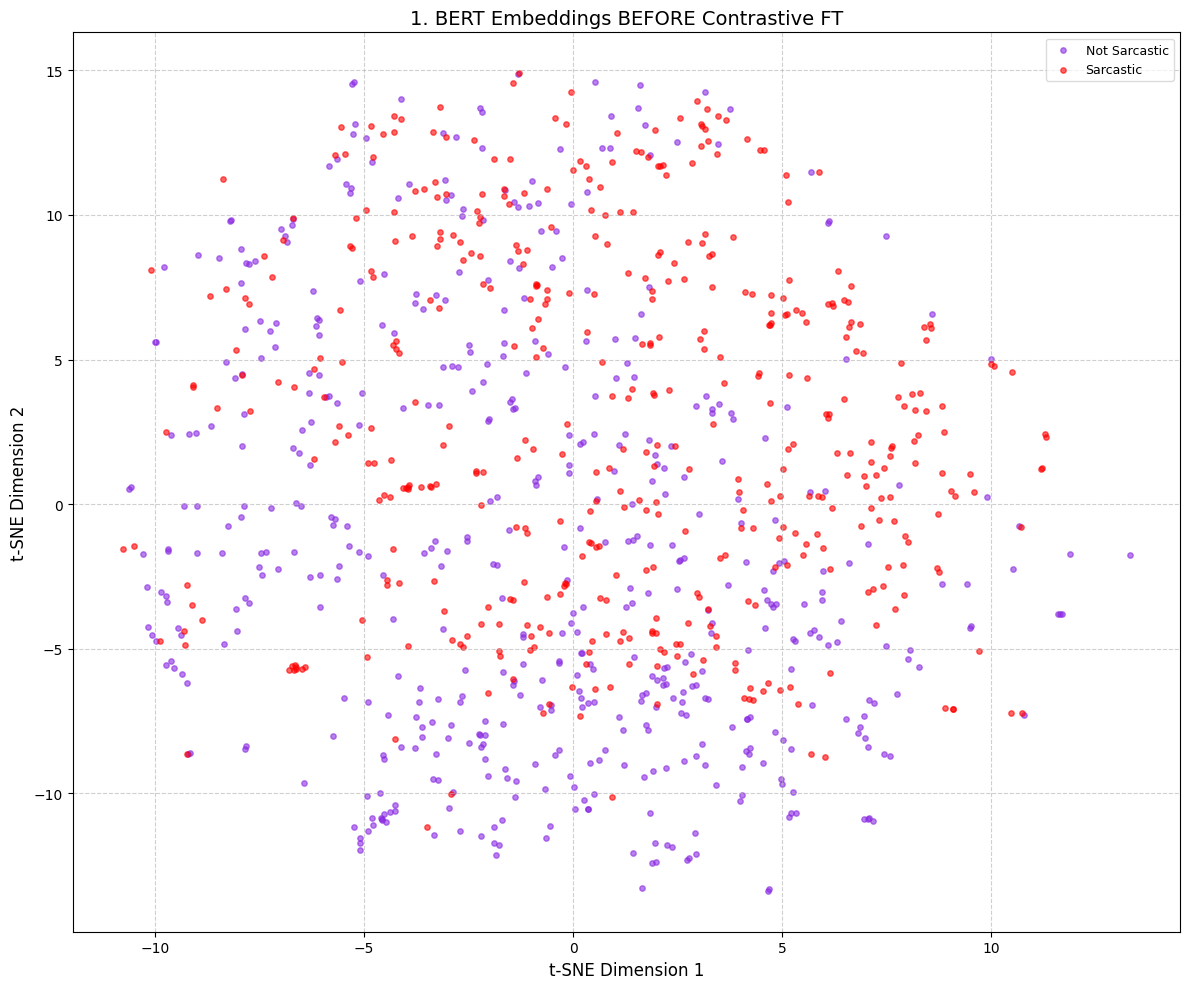


Running t-SNE AFTER fine-tuning...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 'after' finished: 2.20s.

Plotting t-SNE AFTER fine-tuning (Original View)...


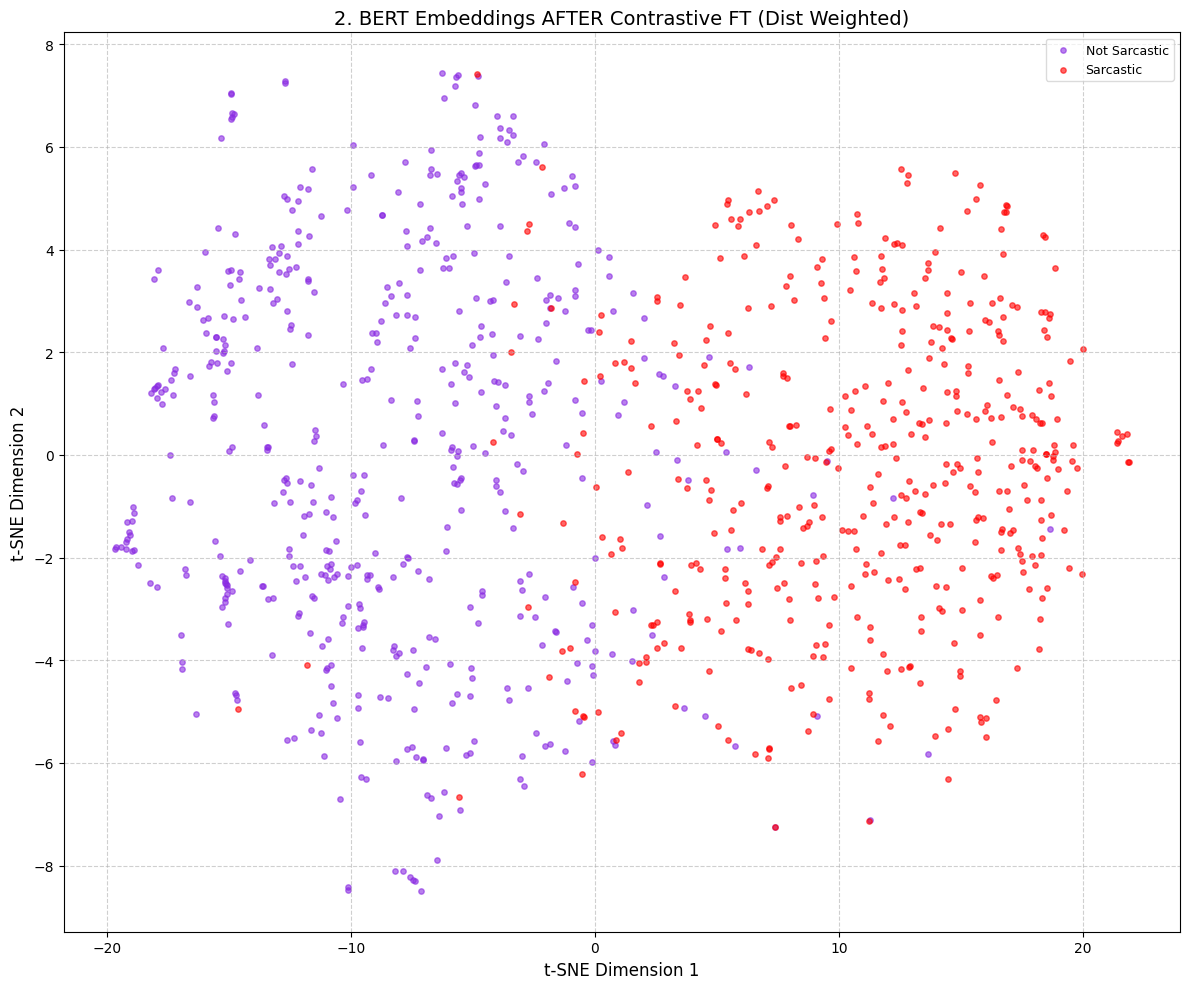


Plotting t-SNE AFTER fine-tuning (Colored by Error Type)...


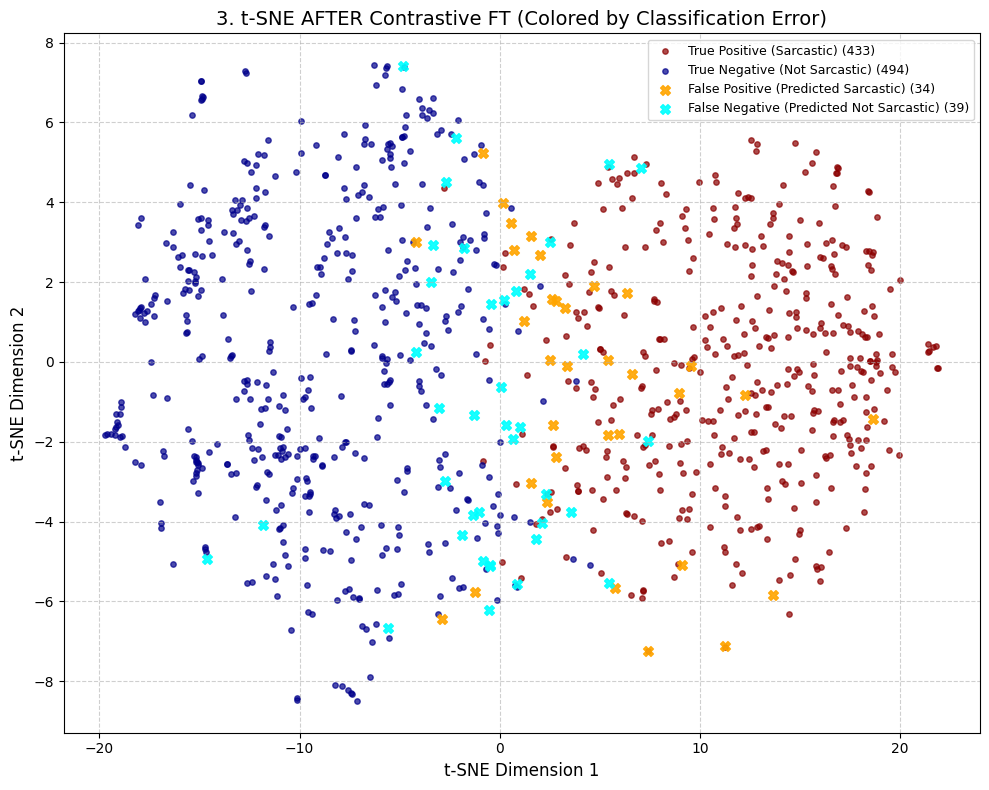

Found 34 FPs and 39 FNs in plotted data for potential indexing.
Selecting top 10 most confident False Positives for indexing.
Selecting top 10 most confident False Negatives for indexing.

Plotting t-SNE AFTER fine-tuning (Top Confident Misclassified Indexed)...
Adding text indices for 20 points on the plot.


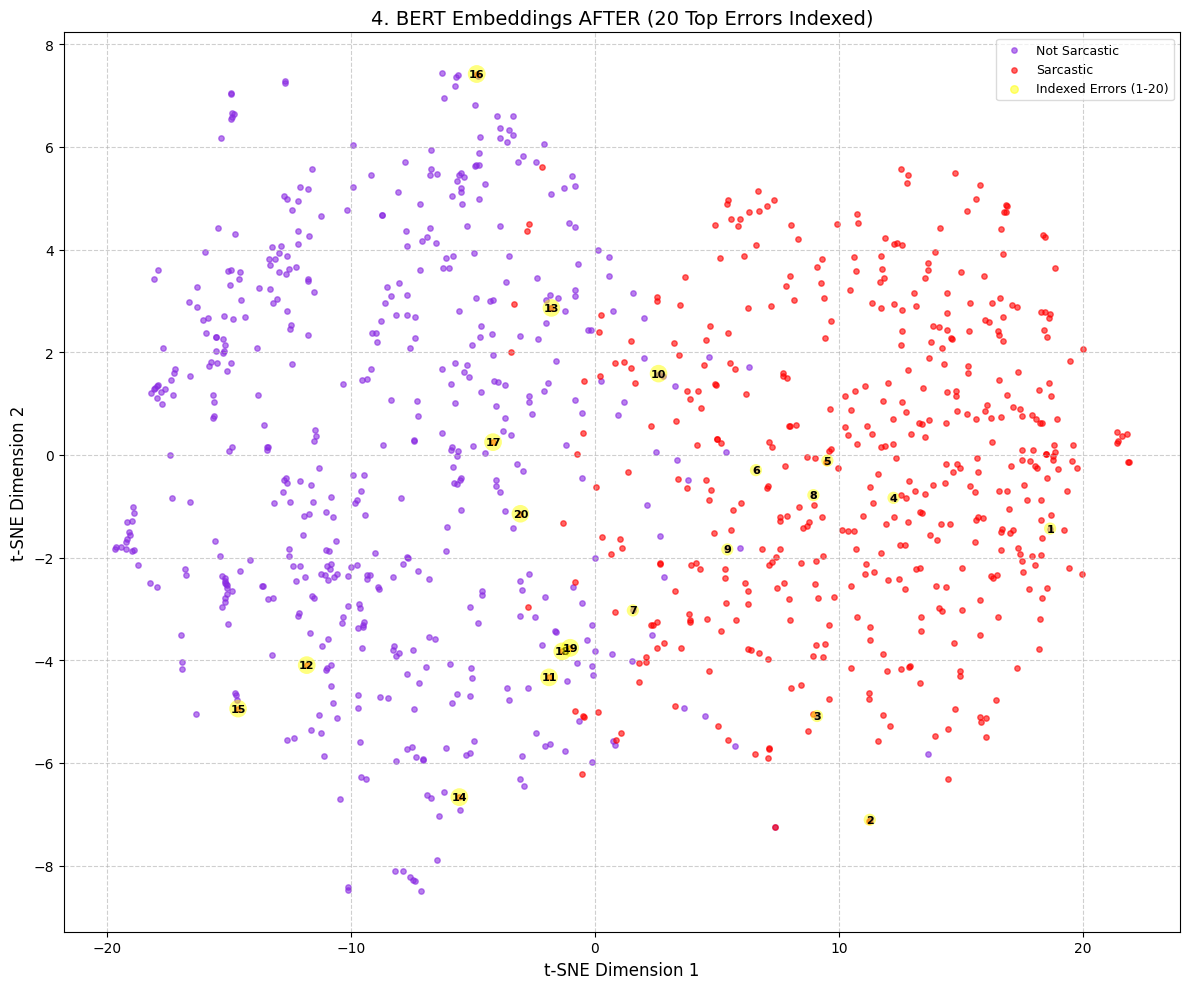

--- Embedding Visualization Finished ---

--- Analysis of INDEXED Top Confident Misclassifications (After Fine-tuning) ---
Details for the 20 points indexed on Plot 4 (sorted by confidence):

--- Indexed Top Confident False Positives (10 shown) ---
  Index 1:
    Headline: "indian country all too familiar with rachel dolezals of the world"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 1.000
    Confidence in Error: 1.000
  Index 2:
    Headline: "rupaul on trump: 'pardon me madame, but the emperor has no clothes!'"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.998
    Confidence in Error: 0.998
  Index 3:
    Headline: "dick van dyke surprises denny's patrons with impromptu performance of 'chitty chitty bang bang'"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.993
    Confidence in Error: 0.993
  Index 4:
    Headline: "guard dog in training notices very suspicious-looking dog in mirror"
    Actual: Not Sarcastic, Predicte

In [ ]:
# --- Visualization Section (t-SNE) ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")

# --- Plotting Function 1: Original with Optional INDEXED Highlighting ---
def plot_embeddings(embeddings_2d, labels, title, indexed_points=None, highlight_color='black', text_size=8):
    """Plots 2D embeddings, colored by label, with optional text indexing for specific points."""
    plt.figure(figsize=(12, 10)) # Slightly larger figure for text
    unique_labels = sorted(np.unique(labels))
    # Use specific colors for consistency if binary
    if set(unique_labels) == {0, 1}:
        colors = {0: 'blueviolet', 1: 'red'} # Match original plot colors
        label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}
    else: # Fallback for multi-class
        colors_list = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        colors = {label: color for label, color in zip(unique_labels, colors_list)}
        label_map = {label: f"Class {label}" for label in unique_labels}

    # Plot main points
    plotted_legend_labels = set()
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        current_label_text = label_map.get(label, f"Class {label}")
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=[colors[label]], label=current_label_text,
                    alpha=0.6, s=15)
        plotted_legend_labels.add(current_label_text)

    # Add text index labels for specified points
    indexed_legend_added = False
    if indexed_points is not None and len(indexed_points) > 0:
        plotted_indices_count = 0
        # Determine max index label length for legend formatting
        max_index = max(indexed_points.values()) if indexed_points else 0

        for point_idx, text_label in indexed_points.items():
            if point_idx < embeddings_2d.shape[0]:
                 x, y = embeddings_2d[point_idx, 0], embeddings_2d[point_idx, 1]
                 plt.text(x, y, str(text_label), color=highlight_color, fontsize=text_size,
                          fontweight='bold', ha='center', va='center',
                          bbox=dict(boxstyle='circle,pad=0.1', fc='yellow', alpha=0.5, ec='none'))
                 plotted_indices_count += 1
                 if not indexed_legend_added :
                      # Add a dummy point for the legend
                      plt.scatter([], [], color='yellow', alpha=0.5, s=30, marker='o', label=f'Indexed Errors (1-{max_index})')
                      indexed_legend_added = True

        if plotted_indices_count > 0:
             print(f"Adding text indices for {plotted_indices_count} points on the plot.")
        else:
             print("Valid indices provided for indexing, but none were within embedding bounds.")

    elif indexed_points is not None:
         print("No specific points provided or found for indexing.")


    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    # Combine legends carefully
    handles, labels_legend = plt.gca().get_legend_handles_labels()
    unique_labels_in_legend = []
    unique_handles = []
    for handle, label in zip(handles, labels_legend):
        if label not in unique_labels_in_legend:
            unique_labels_in_legend.append(label)
            unique_handles.append(handle)

    plt.legend(unique_handles, unique_labels_in_legend, fontsize=9, loc='best', framealpha=0.7)
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()


# --- Plotting Function 2: Colored by Error Type ---
def plot_embeddings_by_error_type(embeddings_2d, true_labels, predicted_labels, title):
    """Plots 2D embeddings colored by classification outcome (TP, TN, FP, FN)."""
    # Ensure predicted_labels have the same length as true_labels and embeddings_2d
    if len(predicted_labels) != len(true_labels) or len(predicted_labels) != embeddings_2d.shape[0]:
        print(f"Warning: Length mismatch in plot_embeddings_by_error_type. "
              f"Embeddings: {embeddings_2d.shape[0]}, True: {len(true_labels)}, Pred: {len(predicted_labels)}. Skipping plot.")
        return

    plt.figure(figsize=(10, 8))
    is_correct = (true_labels == predicted_labels)
    is_sarcastic_true = (true_labels == 1)
    is_sarcastic_pred = (predicted_labels == 1)

    tp_mask = is_correct & is_sarcastic_true
    tn_mask = is_correct & ~is_sarcastic_true
    fp_mask = ~is_correct & is_sarcastic_pred
    fn_mask = ~is_correct & ~is_sarcastic_pred

    masks = {'True Positive (Sarcastic)': tp_mask, 'True Negative (Not Sarcastic)': tn_mask,
             'False Positive (Predicted Sarcastic)': fp_mask, 'False Negative (Predicted Not Sarcastic)': fn_mask}
    colors = {'True Positive (Sarcastic)': 'darkred', 'True Negative (Not Sarcastic)': 'darkblue',
              'False Positive (Predicted Sarcastic)': 'orange', 'False Negative (Predicted Not Sarcastic)': 'cyan'}
    markers = {'True Positive (Sarcastic)': 'o', 'True Negative (Not Sarcastic)': 'o',
               'False Positive (Predicted Sarcastic)': 'X', 'False Negative (Predicted Not Sarcastic)': 'X'}
    sizes = {'True Positive (Sarcastic)': 15, 'True Negative (Not Sarcastic)': 15,
             'False Positive (Predicted Sarcastic)': 50, 'False Negative (Predicted Not Sarcastic)': 50}

    for label, mask in masks.items():
        indices = np.where(mask)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=colors[label], marker=markers[label], s=sizes[label],
                    alpha=0.7 if markers[label] == 'o' else 0.9,
                    label=f"{label} ({len(valid_indices)})")

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(fontsize=9, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(); plt.show()


# --- Run t-SNE and Generate Plots (Reordered) ---
tsne_coords_available = False
embeddings_2d_after = None # Initialize
labels_for_plot = None     # Initialize
plotted_indices_original = None # Initialize
original_to_sample_idx_map = None # Initialize
indexed_points_for_plot = {} # Dict: {relative_index: display_index}
indexed_details = {} # Dict: {display_index: {details}}
N_TO_INDEX = 10


if X_bert_test_before_ft.shape[0] == 0 or X_bert_test_after_ft.shape[0] == 0:
    print("Skipping t-SNE visualization due to empty embeddings.")
else:
    # --- Sampling Logic ---
    embeddings_to_tsne_before_orig, embeddings_to_tsne_after_orig = X_bert_test_before_ft, X_bert_test_after_ft
    y_labels_for_tsne = y_test
    plotted_indices_original = np.arange(len(y_labels_for_tsne)) # Assume all points plotted initially

    embeddings_to_tsne_before = embeddings_to_tsne_before_orig
    embeddings_to_tsne_after = embeddings_to_tsne_after_orig
    labels_for_plot = y_labels_for_tsne # Labels for the plotted points

    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_labels_for_tsne):
        print(f"Using sample of {VISUALIZATION_SAMPLE_SIZE} for t-SNE.")
        actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_labels_for_tsne))
        if actual_sample_size <= 1:
            print(f"Warning: Sample size ({actual_sample_size}) is too small for t-SNE. Skipping sampling.")
        else:
            try:
                sample_indices = np.random.choice(len(y_labels_for_tsne), actual_sample_size, replace=False)
                # Ensure perplexity is valid for the sample size
                effective_perplexity = min(TSNE_PERPLEXITY, actual_sample_size - 1)
                if effective_perplexity < 5: print(f"Warning: Perplexity ({effective_perplexity}) is very low due to small sample size.")

                embeddings_to_tsne_before = embeddings_to_tsne_before_orig[sample_indices]
                embeddings_to_tsne_after = embeddings_to_tsne_after_orig[sample_indices]
                labels_for_plot = y_labels_for_tsne[sample_indices]
                plotted_indices_original = sample_indices
                original_to_sample_idx_map = {orig_idx: sample_idx for sample_idx, orig_idx in enumerate(plotted_indices_original)}
                print(f"Sampled {len(labels_for_plot)} points. Effective Perplexity: {effective_perplexity}. Mapping created.")
            except ValueError as e:
                print(f"Error sampling: {e}. Using full dataset for t-SNE.")
                # Reset to use full data if sampling fails
                embeddings_to_tsne_before = embeddings_to_tsne_before_orig
                embeddings_to_tsne_after = embeddings_to_tsne_after_orig
                labels_for_plot = y_labels_for_tsne
                plotted_indices_original = np.arange(len(y_labels_for_tsne))
                original_to_sample_idx_map = {idx: idx for idx in plotted_indices_original}
    else:
        print("Using all test points for t-SNE.")
        original_to_sample_idx_map = {idx: idx for idx in plotted_indices_original}
        effective_perplexity = min(TSNE_PERPLEXITY, len(labels_for_plot) - 1) if len(labels_for_plot) > 1 else 5

    # --- Plot 1: t-SNE BEFORE ---
    if embeddings_to_tsne_before is not None and embeddings_to_tsne_before.shape[0] > 1:
        print("\nRunning t-SNE BEFORE fine-tuning..."); start_tsne = time.time()
        tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=effective_perplexity, n_iter=TSNE_N_ITER, verbose=0, n_jobs=-1)
        try:
            embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
            print(f"t-SNE 'before' finished: {time.time() - start_tsne:.2f}s.")
            plot_embeddings(embeddings_2d_before, labels_for_plot, "1. BERT Embeddings BEFORE Contrastive FT") # Pass labels_for_plot
        except Exception as e: print(f"Error running/plotting t-SNE (before): {e}")
    else:
        print("Skipping t-SNE BEFORE plot (insufficient data or error).")


    # --- Run t-SNE AFTER ---
    if embeddings_to_tsne_after is not None and embeddings_to_tsne_after.shape[0] > 1:
        print("\nRunning t-SNE AFTER fine-tuning..."); start_tsne = time.time()
        tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=effective_perplexity, n_iter=TSNE_N_ITER, verbose=0, n_jobs=-1)
        try:
            embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
            tsne_coords_available = True
            print(f"t-SNE 'after' finished: {time.time() - start_tsne:.2f}s.")

            # --- Get predictions and probabilities for the plotted samples ---
            if 'y_pred_after' not in locals() or y_pred_after is None or len(y_pred_after) != len(y_test):
                 print("Error: Predictions 'y_pred_after' not available or mismatched. Cannot generate classification-based plots.")
                 # Set dummy values to allow basic plot (Plot 2) but skip others
                 predicted_labels_for_plot = labels_for_plot # Fallback: show true labels
                 can_do_error_analysis = False
            elif 'y_pred_proba_after' not in locals() or y_pred_proba_after is None or y_pred_proba_after.shape[0] != len(y_test):
                 print("Error: Probabilities 'y_pred_proba_after' not available or mismatched. Cannot perform confidence-based indexing.")
                 predicted_labels_for_plot = y_pred_after[plotted_indices_original]
                 can_do_error_analysis = True # Can still do basic error coloring
                 # Skip confidence indexing later
            else:
                predicted_labels_for_plot = y_pred_after[plotted_indices_original]
                 # Ensure probabilities are for class 1 (Sarcastic)
                if y_pred_proba_after.ndim == 2 and y_pred_proba_after.shape[1] >= 2:
                    probabilities_for_plot = y_pred_proba_after[plotted_indices_original, 1]
                    can_do_error_analysis = True
                elif y_pred_proba_after.ndim == 1: # Check if it's already class 1 prob
                     if len(y_pred_proba_after) == len(y_test):
                         probabilities_for_plot = y_pred_proba_after[plotted_indices_original]
                         can_do_error_analysis = True
                     else: # Mismatched length even if 1D
                         print("Error: 1D Probabilities 'y_pred_proba_after' length mismatch. Cannot perform confidence-based indexing.")
                         can_do_error_analysis = True # Can still use predictions if available
                         probabilities_for_plot = np.full_like(labels_for_plot, 0.5, dtype=float) # Dummy probs
                else:
                     print("Error: Unexpected shape for y_pred_proba_after. Cannot determine probabilities.")
                     can_do_error_analysis = True # Can potentially still use predictions
                     probabilities_for_plot = np.full_like(labels_for_plot, 0.5, dtype=float) # Dummy probs


            # --- Plot 2: t-SNE AFTER (Original View) ---
            print("\nPlotting t-SNE AFTER fine-tuning (Original View)...")
            plot_embeddings(embeddings_2d_after,
                            labels_for_plot,
                            "2. BERT Embeddings AFTER Contrastive FT (Dist Weighted)")


            # --- Plot 3: t-SNE AFTER (Colored by Error Type) ---
            if can_do_error_analysis:
                 print("\nPlotting t-SNE AFTER fine-tuning (Colored by Error Type)...")
                 plot_embeddings_by_error_type(embeddings_2d_after,
                                              labels_for_plot,
                                              predicted_labels_for_plot,
                                              "3. t-SNE AFTER Contrastive FT (Colored by Classification Error)")
            else:
                 print("Skipping Plot 3 (Colored by Error Type) due to missing predictions.")


            # --- Prepare for and Plot 4: t-SNE AFTER (Indexed Top Errors) ---
            if can_do_error_analysis and 'probabilities_for_plot' in locals() and probabilities_for_plot is not None:
                # --- Identify misclassified points WITHIN the plotted sample ---
                misclassified_mask_plot = (labels_for_plot != predicted_labels_for_plot)
                misclassified_indices_relative = np.where(misclassified_mask_plot)[0]

                # --- Separate FPs and FNs and calculate confidence ---
                fp_confidence_scores = []
                fn_confidence_scores = []
                for rel_idx in misclassified_indices_relative:
                    true_label = labels_for_plot[rel_idx]
                    pred_label = predicted_labels_for_plot[rel_idx]
                    prob_sarcastic = probabilities_for_plot[rel_idx]
                    if pred_label == 1 and true_label == 0: # FP
                        confidence = prob_sarcastic
                        fp_confidence_scores.append((confidence, rel_idx))
                    elif pred_label == 0 and true_label == 1: # FN
                        confidence = 1.0 - prob_sarcastic
                        fn_confidence_scores.append((confidence, rel_idx))

                # --- Sort by confidence (descending) ---
                fp_confidence_scores.sort(key=lambda x: x[0], reverse=True)
                fn_confidence_scores.sort(key=lambda x: x[0], reverse=True)
                print(f"Found {len(fp_confidence_scores)} FPs and {len(fn_confidence_scores)} FNs in plotted data for potential indexing.")


                # --- Select TOP N points to index and gather details ---
                current_display_index = 1
                label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}

                # Index Top N False Positives
                fp_to_index = fp_confidence_scores[:N_TO_INDEX]
                print(f"Selecting top {len(fp_to_index)} most confident False Positives for indexing.")
                for confidence, rel_idx in fp_to_index:
                    original_idx = plotted_indices_original[rel_idx]
                    coords = embeddings_2d_after[rel_idx]
                    indexed_points_for_plot[rel_idx] = current_display_index
                    indexed_details[current_display_index] = {
                        "type": "False Positive", "original_index": original_idx,
                        "headline": df_test.loc[original_idx, 'headline'],
                        "actual": label_map[labels_for_plot[rel_idx]],
                        "predicted": label_map[predicted_labels_for_plot[rel_idx]],
                        "probability_sarcastic": f"{probabilities_for_plot[rel_idx]:.3f}",
                        "confidence_in_error": f"{confidence:.3f}",
                        "tsne_coords": f"({coords[0]:.2f}, {coords[1]:.2f})"
                    }
                    current_display_index += 1

                # Index Top N False Negatives
                fn_to_index = fn_confidence_scores[:N_TO_INDEX]
                print(f"Selecting top {len(fn_to_index)} most confident False Negatives for indexing.")
                for confidence, rel_idx in fn_to_index:
                    # Check if max index is reached (N_TO_INDEX FPs + N_TO_INDEX FNs)
                    if current_display_index > N_TO_INDEX * 2 : break

                    original_idx = plotted_indices_original[rel_idx]
                    coords = embeddings_2d_after[rel_idx]
                    indexed_points_for_plot[rel_idx] = current_display_index
                    indexed_details[current_display_index] = {
                        "type": "False Negative", "original_index": original_idx,
                        "headline": df_test.loc[original_idx, 'headline'],
                        "actual": label_map[labels_for_plot[rel_idx]],
                        "predicted": label_map[predicted_labels_for_plot[rel_idx]],
                        "probability_sarcastic": f"{probabilities_for_plot[rel_idx]:.3f}",
                        "confidence_in_error": f"{confidence:.3f}", # P(Not Sarcastic)
                        "tsne_coords": f"({coords[0]:.2f}, {coords[1]:.2f})"
                    }
                    current_display_index += 1

                # --- Plot 4: Original view WITH indexed TOP errors ---
                print("\nPlotting t-SNE AFTER fine-tuning (Top Confident Misclassified Indexed)...")
                plot_embeddings(embeddings_2d_after,
                                labels_for_plot,
                                f"4. BERT Embeddings AFTER ({len(indexed_points_for_plot)} Top Errors Indexed)",
                                indexed_points=indexed_points_for_plot)
            else:
                print("\nSkipping Plot 4 (Indexed Errors) due to missing predictions/probabilities.")


        except Exception as e:
            print(f"Error running/plotting t-SNE (after) or indexing: {e}")
            tsne_coords_available = False # Reset flag on error

    else: print("Insufficient data or error during sampling prevented t-SNE (after).")
print("--- Embedding Visualization Finished ---")


# --- Misclassification Analysis (Textual Printout for INDEXED points) ---
print("\n--- Analysis of INDEXED Top Confident Misclassifications (After Fine-tuning) ---")

# Ensure indexed details were generated
if not indexed_details:
    print("No points were selected for indexed analysis (likely due to lack of errors in sample, missing probabilities, or other error).")
else:
    print(f"Details for the {len(indexed_details)} points indexed on Plot 4 (sorted by confidence):")
    indexed_fps = {idx: details for idx, details in indexed_details.items() if details["type"] == "False Positive"}
    indexed_fns = {idx: details for idx, details in indexed_details.items() if details["type"] == "False Negative"}

    print(f"\n--- Indexed Top Confident False Positives ({len(indexed_fps)} shown) ---")
    if not indexed_fps: print("None selected/found for indexing.")
    else:
        for display_idx in sorted(indexed_fps.keys()):
            sample = indexed_fps[display_idx]
            print(f"  Index {display_idx}:")
            print(f"    Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}")
            print(f"    Confidence in Error: {sample['confidence_in_error']}")
            # print(f"    t-SNE Coords: {sample['tsne_coords']} (Original Index: {sample['original_index']})") # Optional details

    print(f"\n--- Indexed Top Confident False Negatives ({len(indexed_fns)} shown) ---")
    if not indexed_fns: print("None selected/found for indexing.")
    else:
        for display_idx in sorted(indexed_fns.keys()):
            sample = indexed_fns[display_idx]
            print(f"  Index {display_idx}:")
            print(f"    Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}")
            print(f"    Confidence in Error [P(Not Sarcastic)]: {sample['confidence_in_error']}")
            # print(f"    t-SNE Coords: {sample['tsne_coords']} (Original Index: {sample['original_index']})") # Optional details

print("\n--- End Indexed Misclassification Analysis ---")

### Latest


--- Starting Embedding Visualization (t-SNE) ---
Using sample of 1000 for t-SNE.
Sampled 1000 points. Effective Perplexity: 30. Mapping created.

Running t-SNE BEFORE fine-tuning...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 'before' finished: 16.79s.


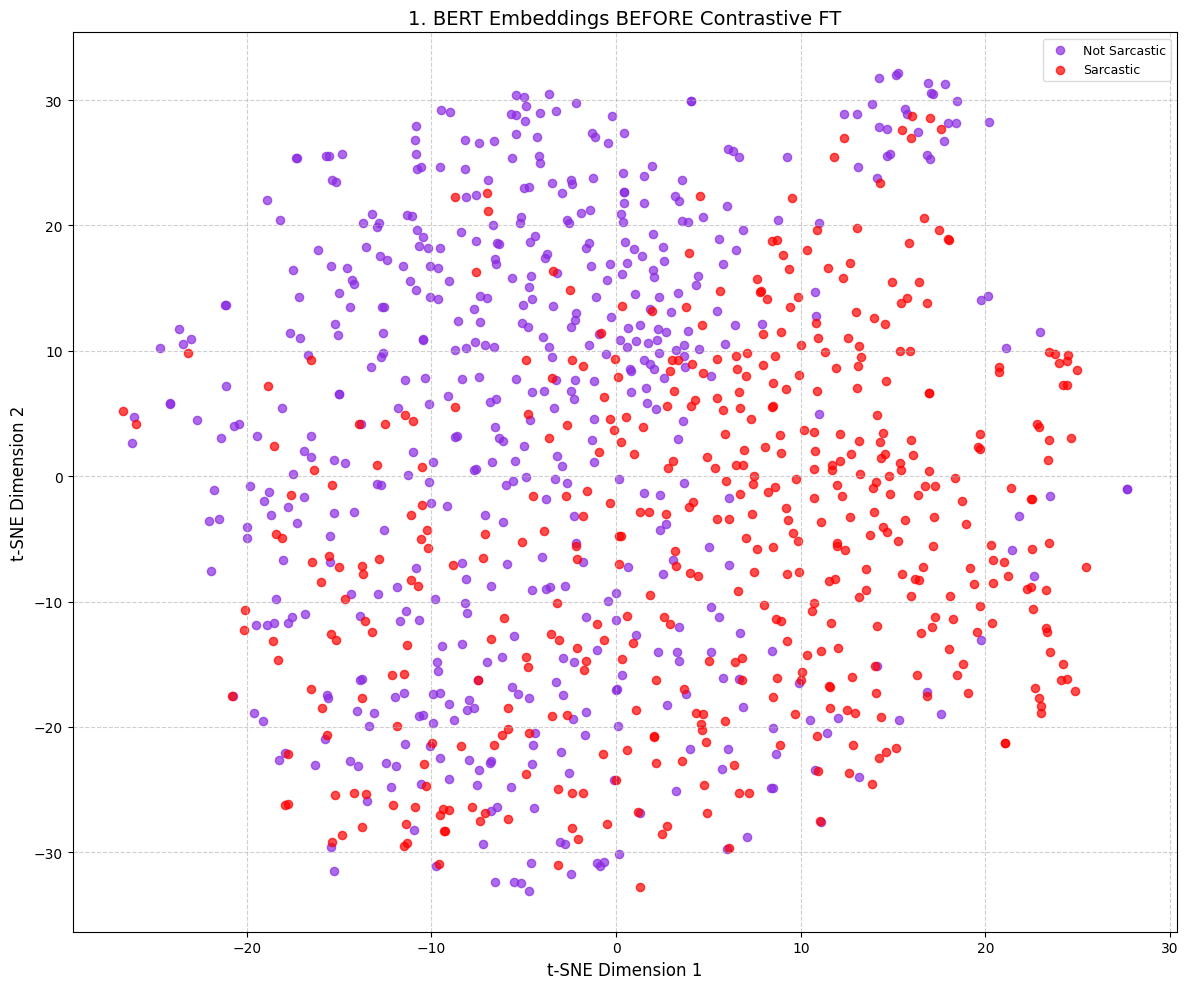


Running t-SNE AFTER fine-tuning...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 'after' finished: 12.88s.

Plotting t-SNE AFTER fine-tuning (Original View)...


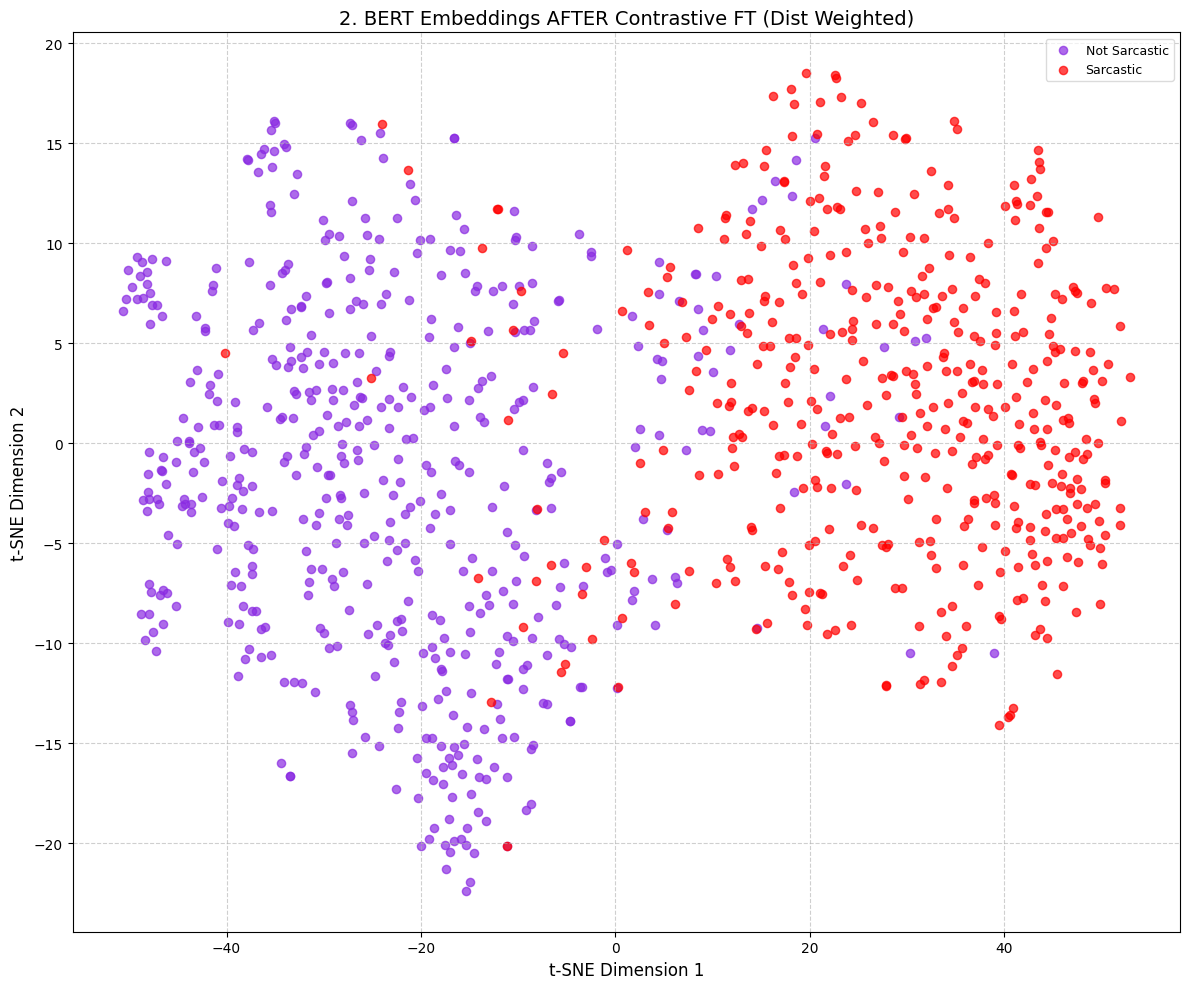


Plotting t-SNE AFTER fine-tuning (Colored by Error Type)...


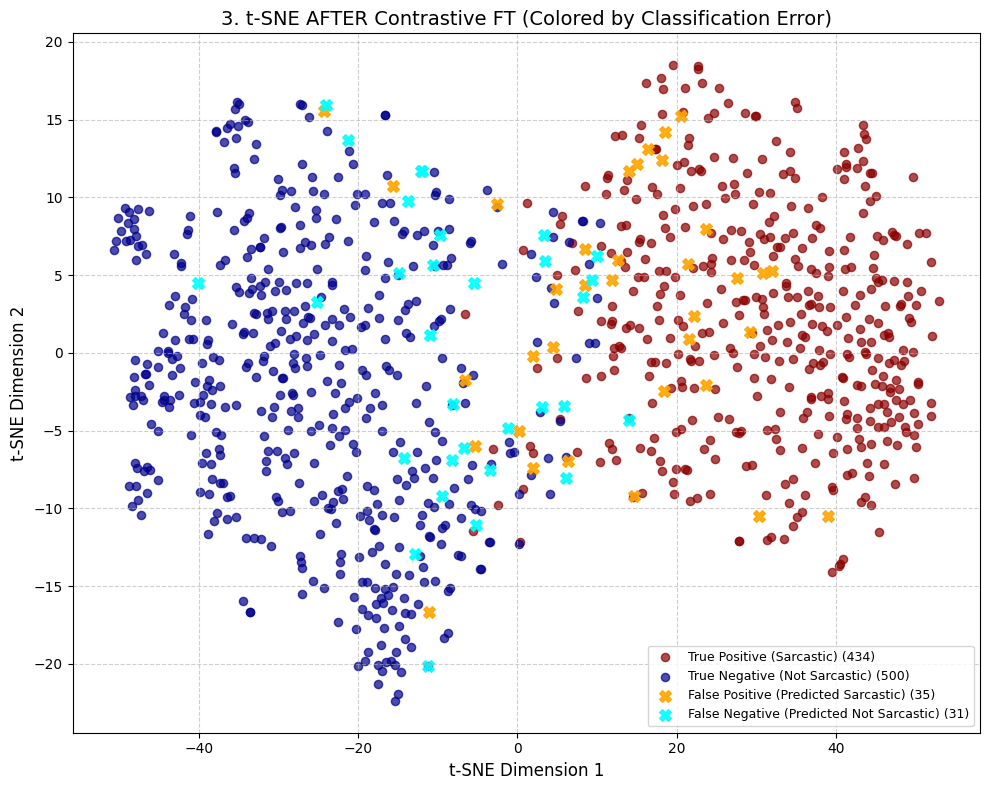

Found 35 FPs and 31 FNs in plotted data for potential indexing.
Selecting top 20 most confident False Positives for indexing.
Selecting top 20 most confident False Negatives for indexing.

Plotting t-SNE AFTER fine-tuning (Top Confident Misclassified Indexed)...
Adding text indices for 40 points on the plot (colored by FP/FN).


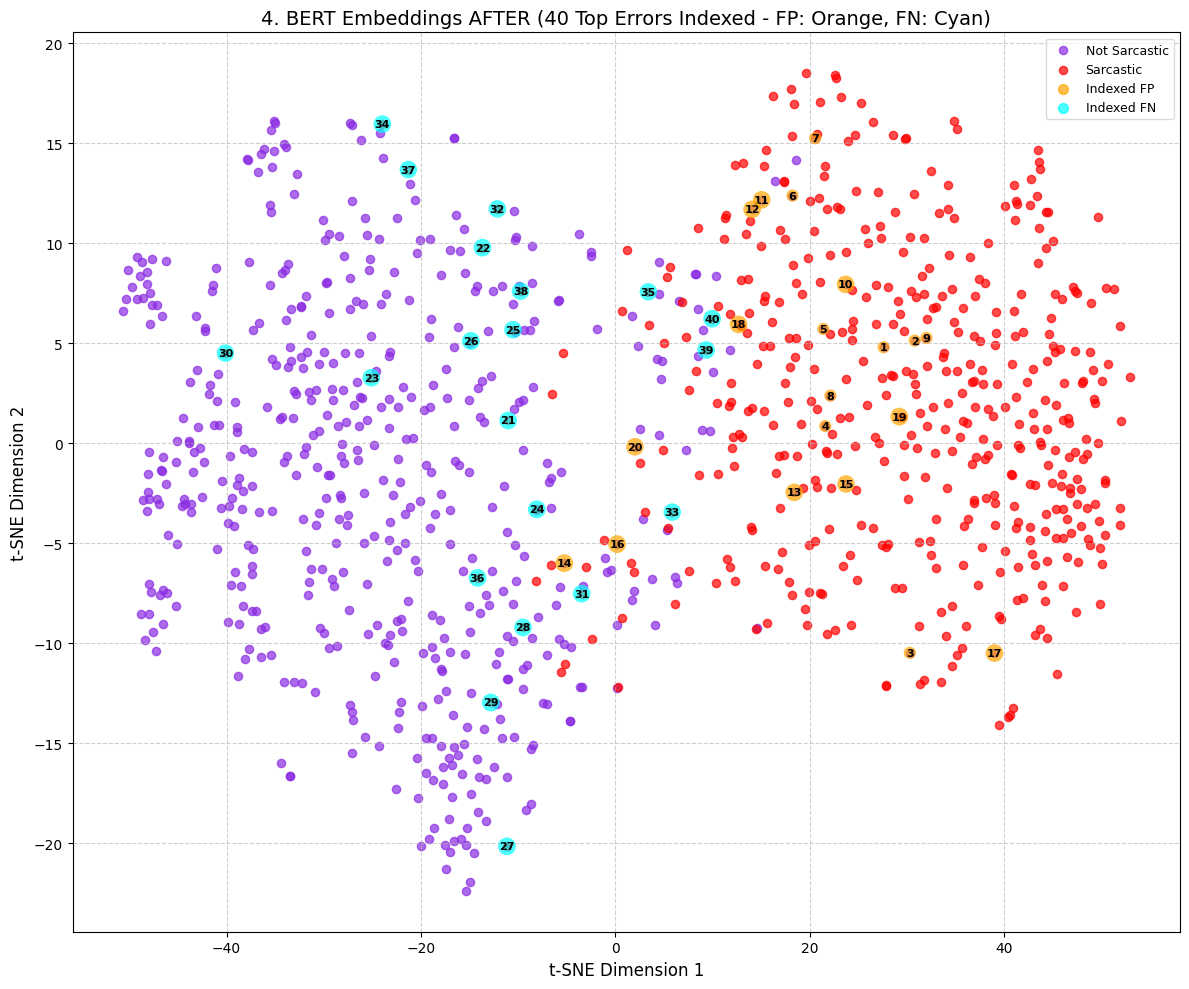

--- Embedding Visualization Finished ---

--- Analysis of INDEXED Top Confident Misclassifications (After Fine-tuning) ---
Details for the 40 points indexed on Plot 4 (sorted by confidence within type):

--- Indexed Top Confident False Positives (20 shown) ---
  Index 1:
    Headline: "oscars line up five non-white presenters"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.999
    Confidence in Error [P(Sarcastic)]: 0.999
  Index 2:
    Headline: "bigfoot unveiling turns into huge toe job"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.997
    Confidence in Error [P(Sarcastic)]: 0.997
  Index 3:
    Headline: "fake melania trump dreams of day she'll retire role as donald's wife on 'colbert'"
    Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.996
    Confidence in Error [P(Sarcastic)]: 0.996
  Index 4:
    Headline: "father of theater shooting victim now sits in son's row at movies"
    Actual: Not Sarcastic, Predicted: Sarcasti

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.manifold import TSNE
# Assume necessary variables like X_bert_test_before_ft, X_bert_test_after_ft,
# y_test, y_pred_after, y_pred_proba_after, df_test, etc., are already defined
# and populated from the previous parts of your script.
# Also assume plt, np, time, TSNE are imported.

# Dummy data for testing if needed:
# N_SAMPLES = 500
# N_FEATURES = 768
# X_bert_test_before_ft = np.random.rand(N_SAMPLES, N_FEATURES)
# X_bert_test_after_ft = np.random.rand(N_SAMPLES, N_FEATURES) * 0.8 # Simulate change
# y_test = np.random.randint(0, 2, N_SAMPLES)
# y_pred_after = np.random.randint(0, 2, N_SAMPLES)
# # Simulate probabilities (ensure shape matches expected usage)
# y_pred_proba_after_raw = np.random.rand(N_SAMPLES)
# y_pred_proba_after = np.vstack([1 - y_pred_proba_after_raw, y_pred_proba_after_raw]).T # Shape (N_SAMPLES, 2)
# class DummyDF: # Minimal mock df_test
#      def __init__(self, size):
#          self.data = {'headline': [f'Headline {i}' for i in range(size)]}
#          self.index = list(range(size))
#      def loc(self, index, column):
#          if isinstance(index, int):
#              return self.data[column][index]
#          # Basic handling for boolean mask or list of indices if needed elsewhere
#          return [self.data[column][i] for i in index]
# df_test = DummyDF(N_SAMPLES)

# --- Configuration ---
VISUALIZATION_SAMPLE_SIZE = 1000 # Set to None or a large number to use all data
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 1000
RANDOM_STATE = 42
N_TO_INDEX = 20 # Number of top FPs and FNs to index

# --- Visualization Section (t-SNE) ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")

# --- Plotting Function 1: Original with Optional INDEXED Highlighting ---
def plot_embeddings(embeddings_2d, labels, title, indexed_points=None, indexed_details=None, text_size=8):
    """
    Plots 2D embeddings, colored by label, with optional text indexing
    for specific points, distinguishing FP and FN visually.
    """
    plt.figure(figsize=(12, 10)) # Slightly larger figure for text
    unique_labels = sorted(np.unique(labels))
    # Use specific colors for consistency if binary
    if set(unique_labels) == {0, 1}:
        colors = {0: 'blueviolet', 1: 'red'} # Match original plot colors
        label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}
    else: # Fallback for multi-class
        colors_list = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        colors = {label: color for label, color in zip(unique_labels, colors_list)}
        label_map = {label: f"Class {label}" for label in unique_labels}

    # Plot main points - Made dots thicker (increased 's')
    plotted_legend_labels = set()
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        current_label_text = label_map.get(label, f"Class {label}")
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=[colors[label]], label=current_label_text,
                    alpha=0.7, s=35) # Increased size
        plotted_legend_labels.add(current_label_text)

    # Add text index labels for specified points, colored by error type
    fp_legend_added = False
    fn_legend_added = False
    fp_color_bg = 'orange'
    fn_color_bg = 'cyan'
    text_color = 'black' # Keep text black for contrast

    # Add dummy points for indexed legend entries BEFORE the loop
    # Check if there are any FPs or FNs to be indexed first
    has_fps = False
    has_fns = False
    if indexed_points and indexed_details:
       has_fps = any(details['type'] == 'False Positive' for details in indexed_details.values())
       has_fns = any(details['type'] == 'False Negative' for details in indexed_details.values())

    if has_fps:
        plt.scatter([], [], color=fp_color_bg, alpha=0.7, s=50, marker='o', label='Indexed FP')
        fp_legend_added = True # Mark as added conceptually
    if has_fns:
        plt.scatter([], [], color=fn_color_bg, alpha=0.7, s=50, marker='o', label='Indexed FN')
        fn_legend_added = True # Mark as added conceptually


    if indexed_points is not None and indexed_details is not None and len(indexed_points) > 0:
        plotted_indices_count = 0
        for point_idx, display_index in indexed_points.items():
            if point_idx < embeddings_2d.shape[0]:
                details = indexed_details.get(display_index)
                if details:
                    x, y = embeddings_2d[point_idx, 0], embeddings_2d[point_idx, 1]
                    error_type = details.get("type", "Unknown")

                    # Determine background color based on error type
                    if error_type == "False Positive":
                        bg_color = fp_color_bg
                    elif error_type == "False Negative":
                        bg_color = fn_color_bg
                    else:
                        bg_color = 'yellow' # Fallback

                    plt.text(x, y, str(display_index), color=text_color, fontsize=text_size,
                             fontweight='bold', ha='center', va='center',
                             bbox=dict(boxstyle='circle,pad=0.1', fc=bg_color, alpha=0.7, ec='none')) # Use determined color
                    plotted_indices_count += 1
                else:
                     print(f"Warning: Details not found for display index {display_index} (relative index {point_idx}). Skipping text.")


        if plotted_indices_count > 0:
             print(f"Adding text indices for {plotted_indices_count} points on the plot (colored by FP/FN).")
        elif len(indexed_points) > 0 : # If points were provided but none were in bounds
             print("Valid indices provided for indexing, but none were within embedding bounds.")
        # else: No points provided, do nothing.

    elif indexed_points is not None: # Handles case where indexed_points is empty or None
         print("No specific points provided or found for indexing.")


    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    # Combine legends carefully
    handles, labels_legend = plt.gca().get_legend_handles_labels()
    unique_labels_in_legend = []
    unique_handles = []
    for handle, label in zip(handles, labels_legend):
        if label not in unique_labels_in_legend:
            unique_labels_in_legend.append(label)
            unique_handles.append(handle)

    plt.legend(unique_handles, unique_labels_in_legend, fontsize=9, loc='best', framealpha=0.7)
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()


# --- Plotting Function 2: Colored by Error Type ---
def plot_embeddings_by_error_type(embeddings_2d, true_labels, predicted_labels, title):
    """Plots 2D embeddings colored by classification outcome (TP, TN, FP, FN)."""
    # Ensure predicted_labels have the same length as true_labels and embeddings_2d
    if len(predicted_labels) != len(true_labels) or len(predicted_labels) != embeddings_2d.shape[0]:
        print(f"Warning: Length mismatch in plot_embeddings_by_error_type. "
              f"Embeddings: {embeddings_2d.shape[0]}, True: {len(true_labels)}, Pred: {len(predicted_labels)}. Skipping plot.")
        return

    plt.figure(figsize=(10, 8))
    is_correct = (true_labels == predicted_labels)
    is_sarcastic_true = (true_labels == 1)
    is_sarcastic_pred = (predicted_labels == 1)

    tp_mask = is_correct & is_sarcastic_true
    tn_mask = is_correct & ~is_sarcastic_true
    fp_mask = ~is_correct & is_sarcastic_pred
    fn_mask = ~is_correct & ~is_sarcastic_pred

    masks = {'True Positive (Sarcastic)': tp_mask, 'True Negative (Not Sarcastic)': tn_mask,
             'False Positive (Predicted Sarcastic)': fp_mask, 'False Negative (Predicted Not Sarcastic)': fn_mask}
    colors = {'True Positive (Sarcastic)': 'darkred', 'True Negative (Not Sarcastic)': 'darkblue',
              'False Positive (Predicted Sarcastic)': 'orange', 'False Negative (Predicted Not Sarcastic)': 'cyan'}
    markers = {'True Positive (Sarcastic)': 'o', 'True Negative (Not Sarcastic)': 'o',
               'False Positive (Predicted Sarcastic)': 'X', 'False Negative (Predicted Not Sarcastic)': 'X'}
    # Increased sizes for thicker points
    sizes = {'True Positive (Sarcastic)': 35, 'True Negative (Not Sarcastic)': 35,
             'False Positive (Predicted Sarcastic)': 70, 'False Negative (Predicted Not Sarcastic)': 70}
    # Adjusted alpha slightly for better visibility
    alphas = {'True Positive (Sarcastic)': 0.7, 'True Negative (Not Sarcastic)': 0.7,
             'False Positive (Predicted Sarcastic)': 0.9, 'False Negative (Predicted Not Sarcastic)': 0.9}


    for label, mask in masks.items():
        indices = np.where(mask)[0]
        valid_indices = [idx for idx in indices if idx < embeddings_2d.shape[0]]
        if not valid_indices: continue
        plt.scatter(embeddings_2d[valid_indices, 0], embeddings_2d[valid_indices, 1],
                    c=colors[label], marker=markers[label], s=sizes[label],
                    alpha=alphas[label], # Use defined alphas
                    label=f"{label} ({len(valid_indices)})")

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12); plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(fontsize=9, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(); plt.show()


# --- Run t-SNE and Generate Plots (Reordered) ---
tsne_coords_available = False
embeddings_2d_after = None # Initialize
labels_for_plot = None     # Initialize
plotted_indices_original = None # Initialize
original_to_sample_idx_map = None # Initialize
indexed_points_for_plot = {} # Dict: {relative_index: display_index}
indexed_details = {} # Dict: {display_index: {details}}


if X_bert_test_before_ft.shape[0] == 0 or X_bert_test_after_ft.shape[0] == 0:
    print("Skipping t-SNE visualization due to empty embeddings.")
else:
    # --- Sampling Logic ---
    embeddings_to_tsne_before_orig, embeddings_to_tsne_after_orig = X_bert_test_before_ft, X_bert_test_after_ft
    # Ensure y_test is a numpy array for consistent indexing
    y_labels_for_tsne = np.array(y_test)
    plotted_indices_original = np.arange(len(y_labels_for_tsne)) # Assume all points plotted initially

    embeddings_to_tsne_before = embeddings_to_tsne_before_orig
    embeddings_to_tsne_after = embeddings_to_tsne_after_orig
    labels_for_plot = y_labels_for_tsne # Labels for the plotted points

    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_labels_for_tsne):
        print(f"Using sample of {VISUALIZATION_SAMPLE_SIZE} for t-SNE.")
        actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_labels_for_tsne))
        if actual_sample_size <= 1:
            print(f"Warning: Sample size ({actual_sample_size}) is too small for t-SNE. Skipping sampling.")
            effective_perplexity = min(TSNE_PERPLEXITY, len(labels_for_plot) - 1) if len(labels_for_plot) > 1 else 5 # For full data
            original_to_sample_idx_map = {idx: idx for idx in plotted_indices_original}
        else:
            try:
                sample_indices = np.random.choice(len(y_labels_for_tsne), actual_sample_size, replace=False)
                # Ensure perplexity is valid for the sample size
                effective_perplexity = min(TSNE_PERPLEXITY, actual_sample_size - 1)
                if effective_perplexity < 5: print(f"Warning: Perplexity ({effective_perplexity}) is very low due to small sample size.")

                embeddings_to_tsne_before = embeddings_to_tsne_before_orig[sample_indices]
                embeddings_to_tsne_after = embeddings_to_tsne_after_orig[sample_indices]
                labels_for_plot = y_labels_for_tsne[sample_indices]
                plotted_indices_original = sample_indices # Store the original indices of the samples
                original_to_sample_idx_map = {orig_idx: sample_idx for sample_idx, orig_idx in enumerate(plotted_indices_original)}
                print(f"Sampled {len(labels_for_plot)} points. Effective Perplexity: {effective_perplexity}. Mapping created.")
            except ValueError as e:
                print(f"Error sampling: {e}. Using full dataset for t-SNE.")
                # Reset to use full data if sampling fails
                embeddings_to_tsne_before = embeddings_to_tsne_before_orig
                embeddings_to_tsne_after = embeddings_to_tsne_after_orig
                labels_for_plot = y_labels_for_tsne
                plotted_indices_original = np.arange(len(y_labels_for_tsne))
                original_to_sample_idx_map = {idx: idx for idx in plotted_indices_original}
                effective_perplexity = min(TSNE_PERPLEXITY, len(labels_for_plot) - 1) if len(labels_for_plot) > 1 else 5
    else:
        print("Using all test points for t-SNE.")
        original_to_sample_idx_map = {idx: idx for idx in plotted_indices_original}
        effective_perplexity = min(TSNE_PERPLEXITY, len(labels_for_plot) - 1) if len(labels_for_plot) > 1 else 5

    # --- Plot 1: t-SNE BEFORE ---
    if embeddings_to_tsne_before is not None and embeddings_to_tsne_before.shape[0] > 1:
        print("\nRunning t-SNE BEFORE fine-tuning..."); start_tsne = time.time()
        # Adjust perplexity if it's still too high for the (potentially sampled) data size
        final_perplexity_before = min(effective_perplexity, embeddings_to_tsne_before.shape[0] - 1)
        if final_perplexity_before < 5 : print(f"Warning: Final perplexity for 'before' plot is low ({final_perplexity_before})")
        tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=max(5, final_perplexity_before), n_iter=TSNE_N_ITER, verbose=0, n_jobs=-1) # Ensure perplexity >= 1
        try:
            embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
            print(f"t-SNE 'before' finished: {time.time() - start_tsne:.2f}s.")
            plot_embeddings(embeddings_2d_before, labels_for_plot, "1. BERT Embeddings BEFORE Contrastive FT") # Pass labels_for_plot
        except Exception as e: print(f"Error running/plotting t-SNE (before): {e}")
    else:
        print("Skipping t-SNE BEFORE plot (insufficient data or error).")


    # --- Run t-SNE AFTER ---
    if embeddings_to_tsne_after is not None and embeddings_to_tsne_after.shape[0] > 1:
        print("\nRunning t-SNE AFTER fine-tuning..."); start_tsne = time.time()
        # Adjust perplexity if it's still too high for the (potentially sampled) data size
        final_perplexity_after = min(effective_perplexity, embeddings_to_tsne_after.shape[0] - 1)
        if final_perplexity_after < 5 : print(f"Warning: Final perplexity for 'after' plot is low ({final_perplexity_after})")
        tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=max(5, final_perplexity_after), n_iter=TSNE_N_ITER, verbose=0, n_jobs=-1) # Ensure perplexity >= 1
        try:
            embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
            tsne_coords_available = True
            print(f"t-SNE 'after' finished: {time.time() - start_tsne:.2f}s.")

            # --- Get predictions and probabilities for the plotted samples ---
            # Ensure predictions/probabilities exist and align with the original y_test length
            probabilities_for_plot = None # Initialize
            can_do_error_analysis = False
            can_do_confidence_indexing = False

            if 'y_pred_after' not in locals() or y_pred_after is None or len(y_pred_after) != len(y_test):
                 print("Error: Predictions 'y_pred_after' not available or mismatched length. Cannot generate classification-based plots.")
                 predicted_labels_for_plot = labels_for_plot # Fallback: show true labels only for Plot 2
            else:
                # Use the original indices (potentially sampled) to get the correct predictions for the points being plotted
                predicted_labels_for_plot = np.array(y_pred_after)[plotted_indices_original]
                can_do_error_analysis = True # Basic error plot (Plot 3) is possible

                if 'y_pred_proba_after' not in locals() or y_pred_proba_after is None or y_pred_proba_after.shape[0] != len(y_test):
                     print("Warning: Probabilities 'y_pred_proba_after' not available or mismatched length. Cannot perform confidence-based indexing for Plot 4.")
                else:
                    # Extract probabilities corresponding to the plotted samples
                    y_pred_proba_after_np = np.array(y_pred_proba_after) # Ensure numpy array

                    # Ensure probabilities are for class 1 (Sarcastic)
                    if y_pred_proba_after_np.ndim == 2 and y_pred_proba_after_np.shape[1] >= 2:
                        probabilities_original = y_pred_proba_after_np[:, 1] # Prob of class 1
                        probabilities_for_plot = probabilities_original[plotted_indices_original]
                        can_do_confidence_indexing = True
                    elif y_pred_proba_after_np.ndim == 1: # Check if it's already class 1 prob
                        probabilities_original = y_pred_proba_after_np
                        probabilities_for_plot = probabilities_original[plotted_indices_original]
                        can_do_confidence_indexing = True
                    else:
                         print("Warning: Unexpected shape for y_pred_proba_after. Cannot determine probabilities for confidence indexing.")


            # --- Plot 2: t-SNE AFTER (Original View) ---
            print("\nPlotting t-SNE AFTER fine-tuning (Original View)...")
            plot_embeddings(embeddings_2d_after,
                            labels_for_plot,
                            "2. BERT Embeddings AFTER Contrastive FT (Dist Weighted)")


            # --- Plot 3: t-SNE AFTER (Colored by Error Type) ---
            if can_do_error_analysis:
                 print("\nPlotting t-SNE AFTER fine-tuning (Colored by Error Type)...")
                 plot_embeddings_by_error_type(embeddings_2d_after,
                                              labels_for_plot, # True labels for the plotted points
                                              predicted_labels_for_plot, # Predicted labels for the plotted points
                                              "3. t-SNE AFTER Contrastive FT (Colored by Classification Error)")
            else:
                 print("Skipping Plot 3 (Colored by Error Type) due to missing/mismatched predictions.")


            # --- Prepare for and Plot 4: t-SNE AFTER (Indexed Top Errors) ---
            if can_do_error_analysis and can_do_confidence_indexing:
                # --- Identify misclassified points WITHIN the plotted sample ---
                misclassified_mask_plot = (labels_for_plot != predicted_labels_for_plot)
                # Get relative indices (indices within the 'labels_for_plot' array)
                misclassified_indices_relative = np.where(misclassified_mask_plot)[0]

                # --- Separate FPs and FNs and calculate confidence ---
                fp_confidence_scores = [] # List of (confidence, relative_index)
                fn_confidence_scores = [] # List of (confidence, relative_index)

                if probabilities_for_plot is not None:
                    for rel_idx in misclassified_indices_relative:
                        # Check index bounds for safety, though 'where' should guarantee validity
                        if rel_idx < len(labels_for_plot) and rel_idx < len(predicted_labels_for_plot) and rel_idx < len(probabilities_for_plot):
                            true_label = labels_for_plot[rel_idx]
                            pred_label = predicted_labels_for_plot[rel_idx]
                            prob_sarcastic = probabilities_for_plot[rel_idx]

                            if pred_label == 1 and true_label == 0: # FP
                                confidence = prob_sarcastic # Confidence is P(Sarcastic)
                                fp_confidence_scores.append((confidence, rel_idx))
                            elif pred_label == 0 and true_label == 1: # FN
                                confidence = 1.0 - prob_sarcastic # Confidence is P(Not Sarcastic)
                                fn_confidence_scores.append((confidence, rel_idx))
                        else:
                            print(f"Warning: Index {rel_idx} out of bounds during confidence calculation. Skipping.")

                    # --- Sort by confidence (descending) ---
                    fp_confidence_scores.sort(key=lambda x: x[0], reverse=True)
                    fn_confidence_scores.sort(key=lambda x: x[0], reverse=True)
                    print(f"Found {len(fp_confidence_scores)} FPs and {len(fn_confidence_scores)} FNs in plotted data for potential indexing.")

                    # --- Select TOP N points to index and gather details ---
                    indexed_points_for_plot.clear() # Reset for this plot
                    indexed_details.clear()        # Reset for this plot
                    current_display_index = 1
                    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'}

                    # Index Top N False Positives
                    fp_to_index = fp_confidence_scores[:N_TO_INDEX]
                    print(f"Selecting top {min(len(fp_to_index), N_TO_INDEX)} most confident False Positives for indexing.")
                    for confidence, rel_idx in fp_to_index:
                        original_idx = plotted_indices_original[rel_idx] # Map back to original df index
                        coords = embeddings_2d_after[rel_idx]
                        indexed_points_for_plot[rel_idx] = current_display_index
                        indexed_details[current_display_index] = {
                            "type": "False Positive", "original_index": original_idx,
                            # Ensure df_test.loc works correctly (might need iloc if index isn't sequential int)
                            "headline": df_test.loc[original_idx, 'headline'] if original_idx in df_test.index else "Headline not found",
                            "actual": label_map[labels_for_plot[rel_idx]],
                            "predicted": label_map[predicted_labels_for_plot[rel_idx]],
                            "probability_sarcastic": f"{probabilities_for_plot[rel_idx]:.3f}",
                            "confidence_in_error": f"{confidence:.3f}", # P(Sarcastic) for FP
                            "tsne_coords": f"({coords[0]:.2f}, {coords[1]:.2f})"
                        }
                        current_display_index += 1

                    # Index Top N False Negatives
                    fn_to_index = fn_confidence_scores[:N_TO_INDEX]
                    print(f"Selecting top {min(len(fn_to_index), N_TO_INDEX)} most confident False Negatives for indexing.")
                    max_total_indexed = N_TO_INDEX * 2 # Allow up to N FPs and N FNs
                    for confidence, rel_idx in fn_to_index:
                        # Check if max total index count is reached
                        if len(indexed_points_for_plot) >= max_total_indexed : break

                        original_idx = plotted_indices_original[rel_idx] # Map back to original df index
                        coords = embeddings_2d_after[rel_idx]
                        indexed_points_for_plot[rel_idx] = current_display_index
                        indexed_details[current_display_index] = {
                            "type": "False Negative", "original_index": original_idx,
                            "headline": df_test.loc[original_idx, 'headline'] if original_idx in df_test.index else "Headline not found",
                            "actual": label_map[labels_for_plot[rel_idx]],
                            "predicted": label_map[predicted_labels_for_plot[rel_idx]],
                            "probability_sarcastic": f"{probabilities_for_plot[rel_idx]:.3f}",
                            "confidence_in_error": f"{confidence:.3f}", # P(Not Sarcastic) for FN
                            "tsne_coords": f"({coords[0]:.2f}, {coords[1]:.2f})"
                        }
                        current_display_index += 1

                    # --- Plot 4: Original view WITH indexed TOP errors ---
                    print("\nPlotting t-SNE AFTER fine-tuning (Top Confident Misclassified Indexed)...")
                    plot_embeddings(embeddings_2d_after,
                                    labels_for_plot,
                                    f"4. BERT Embeddings AFTER ({len(indexed_points_for_plot)} Top Errors Indexed - FP: Orange, FN: Cyan)",
                                    indexed_points=indexed_points_for_plot,
                                    indexed_details=indexed_details) # Pass details for coloring
                else:
                    # This case should be covered by can_do_confidence_indexing check, but added for safety
                    print("\nSkipping Plot 4 (Indexed Errors) because probabilities_for_plot could not be determined.")

            elif not can_do_error_analysis:
                 print("\nSkipping Plot 4 (Indexed Errors) due to missing/mismatched predictions (required for error identification).")
            else: # Error analysis possible, but confidence indexing not possible
                 print("\nSkipping Plot 4 (Indexed Errors) due to missing/mismatched probabilities (required for confidence sorting).")


        except Exception as e:
            print(f"Error running/plotting t-SNE (after) or indexing: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for debugging
            tsne_coords_available = False # Reset flag on error

    else: print("Insufficient data or error during sampling prevented t-SNE (after).")
print("--- Embedding Visualization Finished ---")


# --- Misclassification Analysis (Textual Printout for INDEXED points) ---
print("\n--- Analysis of INDEXED Top Confident Misclassifications (After Fine-tuning) ---")

# Ensure indexed details were generated (which implies Plot 4 was attempted)
if not indexed_details:
    print("No points were selected for indexed analysis (likely due to lack of errors in sample, missing probabilities, or other error).")
else:
    print(f"Details for the {len(indexed_details)} points indexed on Plot 4 (sorted by confidence within type):")
    indexed_fps = {idx: details for idx, details in indexed_details.items() if details["type"] == "False Positive"}
    indexed_fns = {idx: details for idx, details in indexed_details.items() if details["type"] == "False Negative"}

    # Sort FPs by display index (which corresponds to confidence rank)
    sorted_fp_indices = sorted(indexed_fps.keys())
    print(f"\n--- Indexed Top Confident False Positives ({len(sorted_fp_indices)} shown) ---")
    if not sorted_fp_indices: print("None selected/found for indexing.")
    else:
        for display_idx in sorted_fp_indices:
            sample = indexed_fps[display_idx]
            print(f"  Index {display_idx}:")
            print(f"    Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}")
            print(f"    Confidence in Error [P(Sarcastic)]: {sample['confidence_in_error']}")
            # print(f"    t-SNE Coords: {sample['tsne_coords']} (Original Index: {sample['original_index']})") # Optional details

    # Sort FNs by display index (which corresponds to confidence rank)
    sorted_fn_indices = sorted(indexed_fns.keys())
    print(f"\n--- Indexed Top Confident False Negatives ({len(sorted_fn_indices)} shown) ---")
    if not sorted_fn_indices: print("None selected/found for indexing.")
    else:
        for display_idx in sorted_fn_indices:
            sample = indexed_fns[display_idx]
            print(f"  Index {display_idx}:")
            print(f"    Headline: \"{sample['headline']}\"")
            print(f"    Actual: {sample['actual']}, Predicted: {sample['predicted']}, Prob(Sarcastic): {sample['probability_sarcastic']}")
            print(f"    Confidence in Error [P(Not Sarcastic)]: {sample['confidence_in_error']}")
            # print(f"    t-SNE Coords: {sample['tsne_coords']} (Original Index: {sample['original_index']})") # Optional details

print("\n--- End Indexed Misclassification Analysis ---")


--- Detailed Analysis of INDIVIDUAL Indexed Misclassifications ---

Attempting detailed analysis for up to 6 indexed points...

--- Analyzing Indexed Point 1 (Original Index: 1860) ---
Type: False Positive, Headline: "indian country all too familiar with rachel dolezals of the world"
Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 1.000
  Total TF-IDF Contribution: -0.4323
  Total BERT Contribution:   9.5805
  Total Linguistic Contribution: -0.2903
  Model Intercept:           -0.4060
  Calculated Log-Odds:       8.4517
  Calculated Prob(Sarcastic):0.9998 (Should approx match model output)


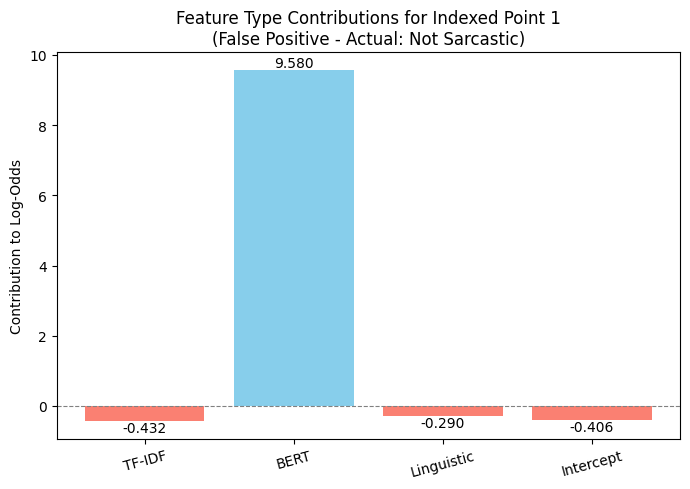

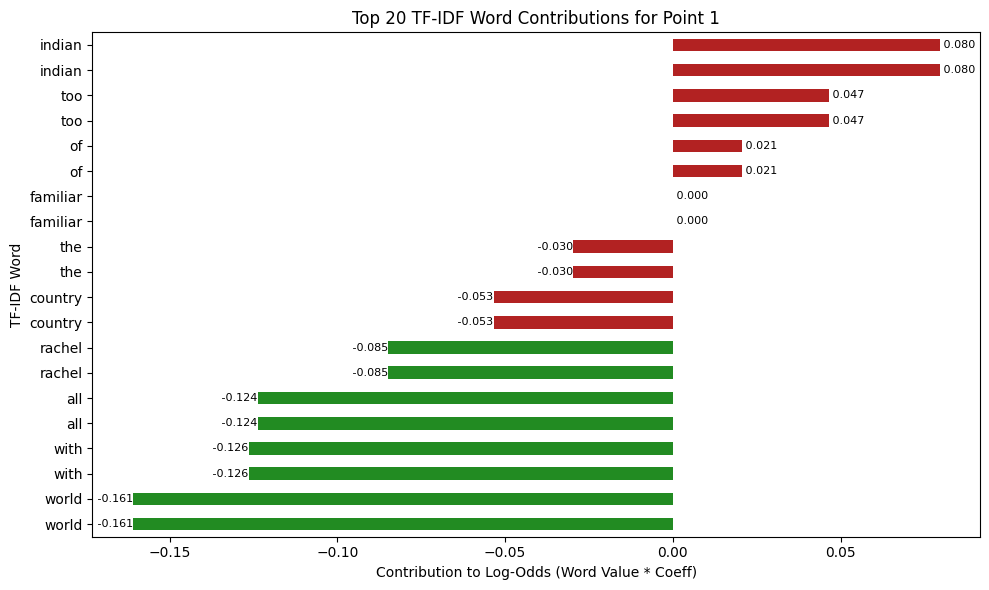

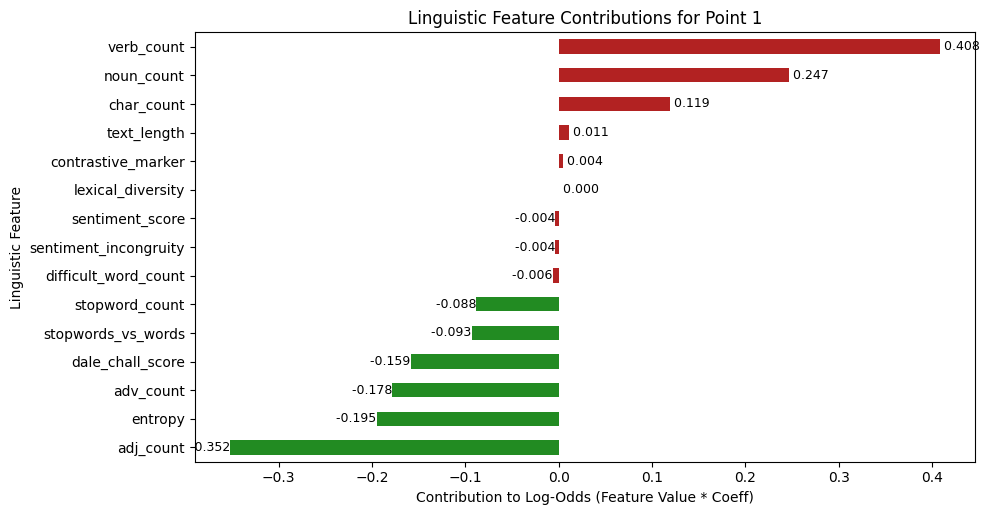


--- Analyzing Indexed Point 2 (Original Index: 1913) ---
Type: False Positive, Headline: "rupaul on trump: 'pardon me madame, but the emperor has no clothes!'"
Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.998
  Total TF-IDF Contribution: -0.1487
  Total BERT Contribution:   7.4562
  Total Linguistic Contribution: -0.4017
  Model Intercept:           -0.4060
  Calculated Log-Odds:       6.4997
  Calculated Prob(Sarcastic):0.9985 (Should approx match model output)


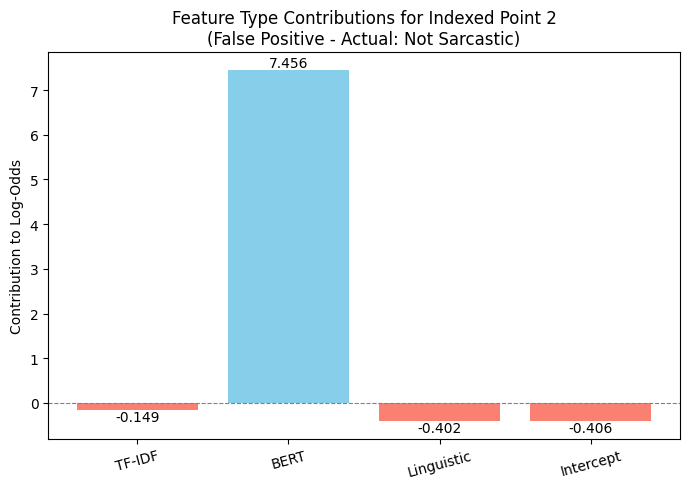

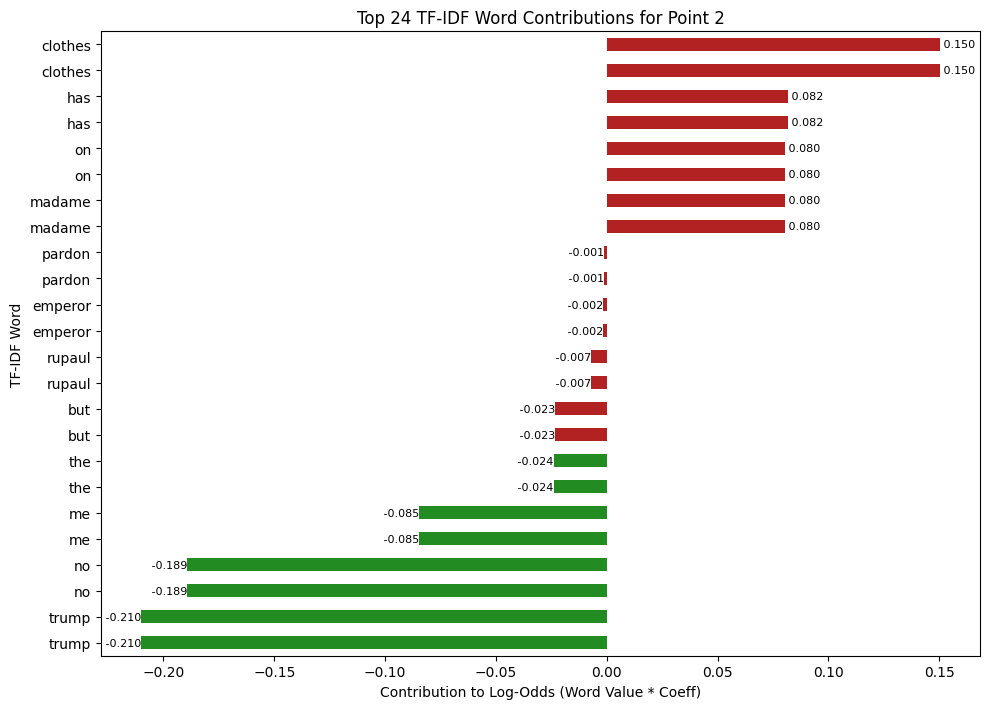

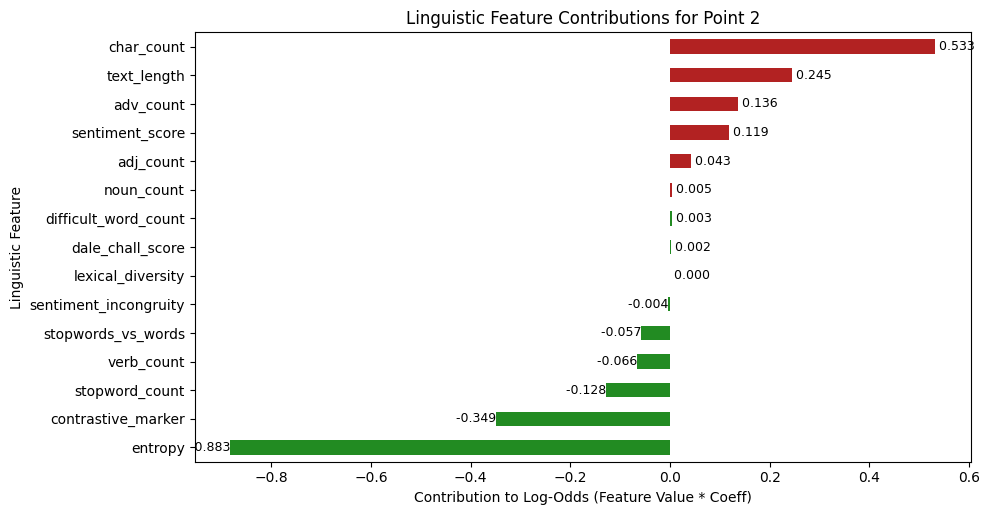


--- Analyzing Indexed Point 3 (Original Index: 2795) ---
Type: False Positive, Headline: "obamacare repeal possibly going to live on farm upstate"
Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.996
  Total TF-IDF Contribution: -0.1685
  Total BERT Contribution:   6.4377
  Total Linguistic Contribution: -0.3357
  Model Intercept:           -0.4060
  Calculated Log-Odds:       5.5274
  Calculated Prob(Sarcastic):0.9960 (Should approx match model output)


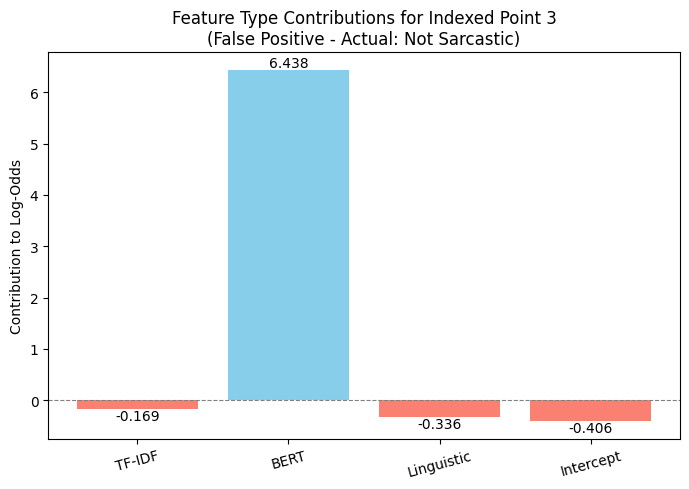

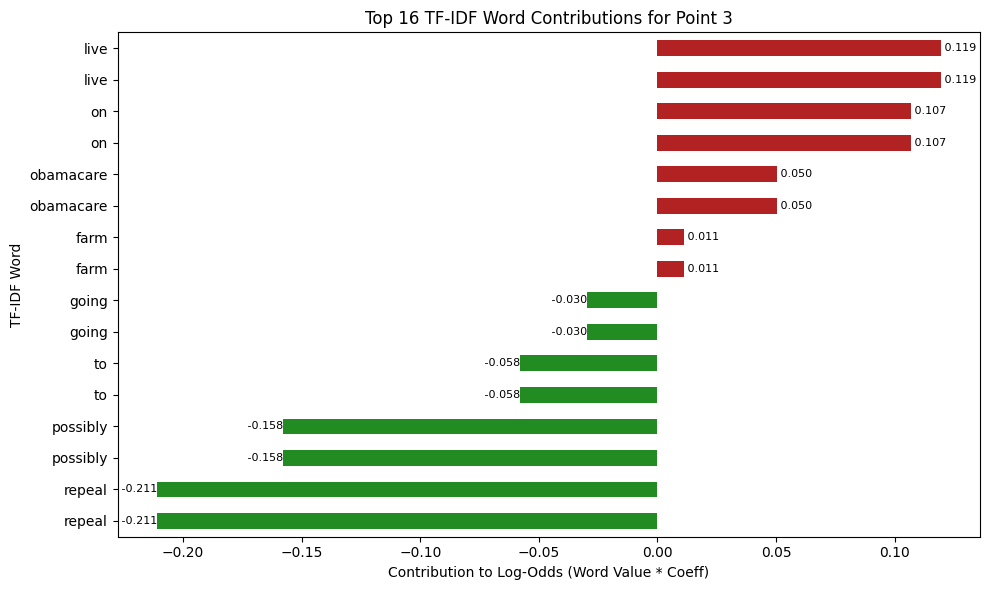

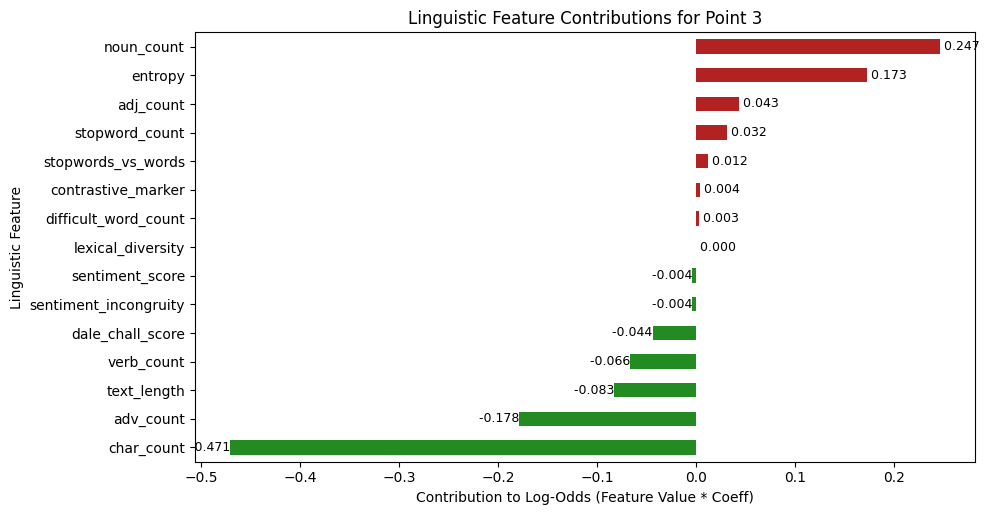


--- Analyzing Indexed Point 4 (Original Index: 1669) ---
Type: False Positive, Headline: "farting teen sparks fight"
Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.994
  Total TF-IDF Contribution: 0.0808
  Total BERT Contribution:   4.9625
  Total Linguistic Contribution: 0.4484
  Model Intercept:           -0.4060
  Calculated Log-Odds:       5.0857
  Calculated Prob(Sarcastic):0.9939 (Should approx match model output)


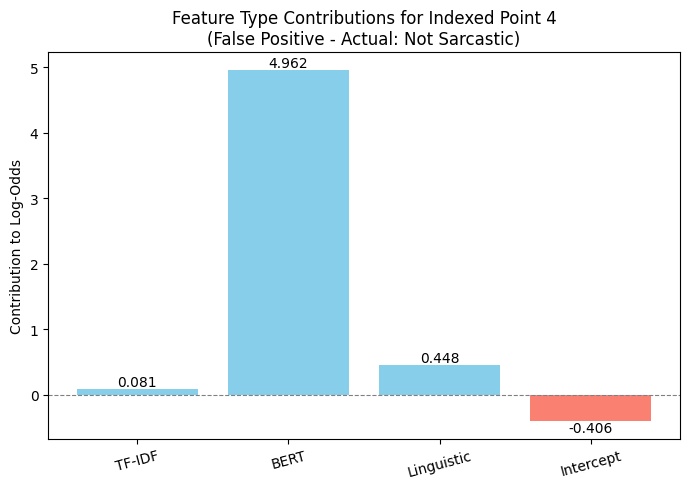

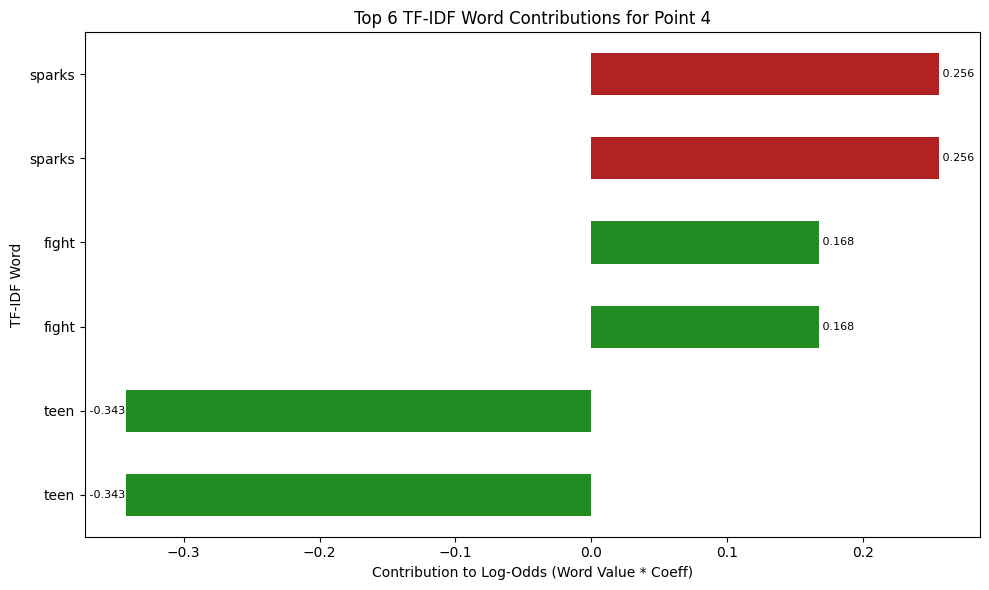

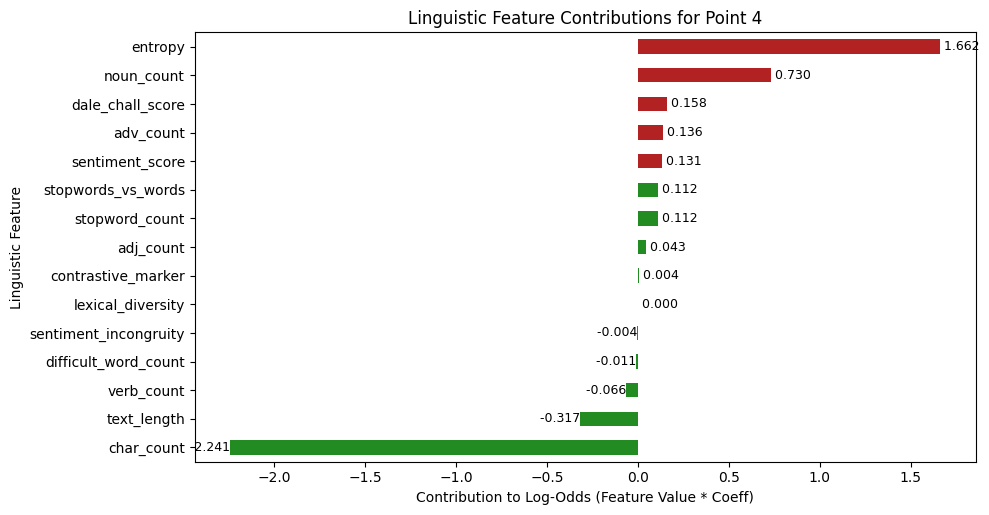


--- Analyzing Indexed Point 5 (Original Index: 186) ---
Type: False Positive, Headline: "man builds rad all-terrain wheelchair that looks like a tank for war hero dad"
Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.993
  Total TF-IDF Contribution: -0.4503
  Total BERT Contribution:   5.8420
  Total Linguistic Contribution: -0.0956
  Model Intercept:           -0.4060
  Calculated Log-Odds:       4.8900
  Calculated Prob(Sarcastic):0.9925 (Should approx match model output)


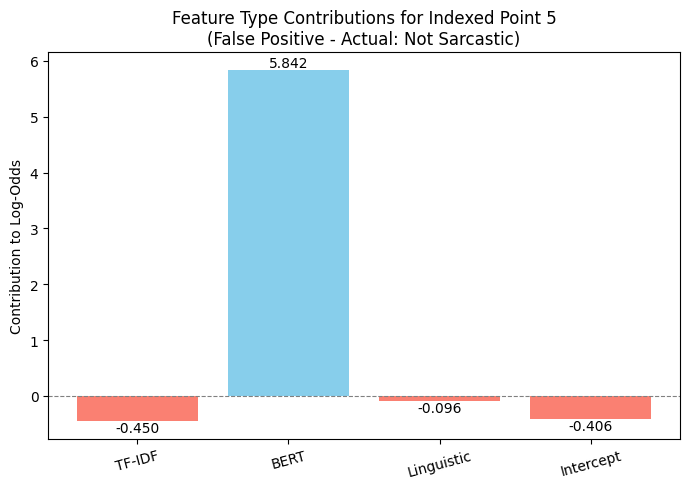

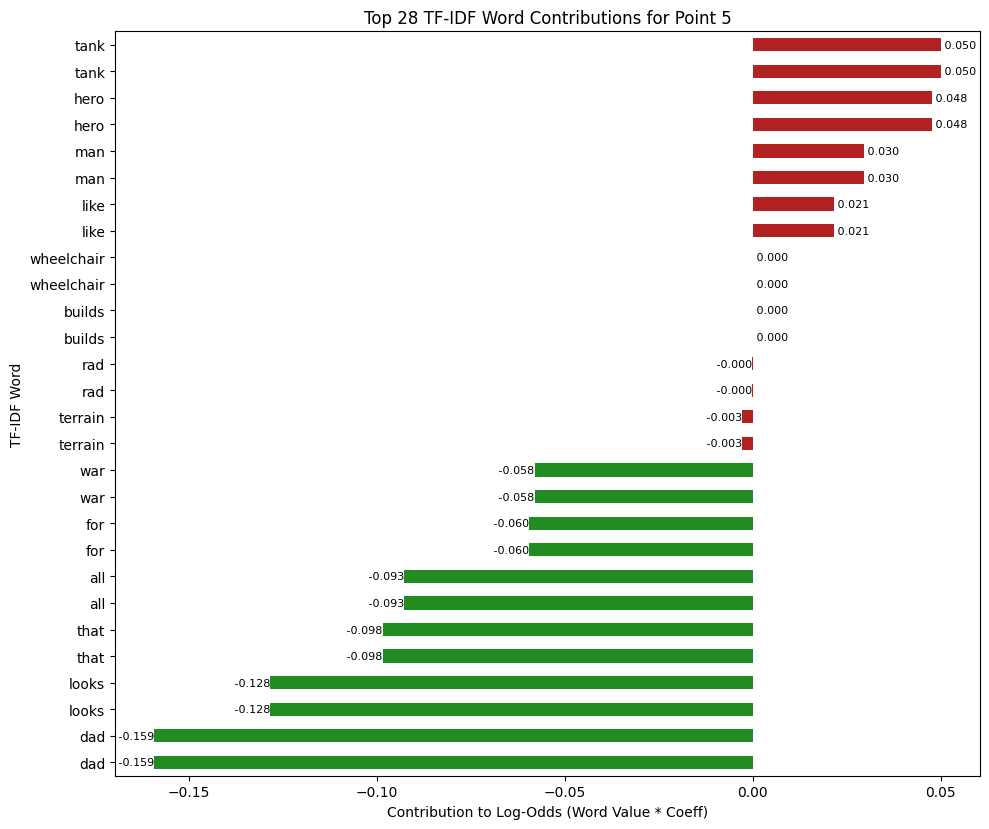

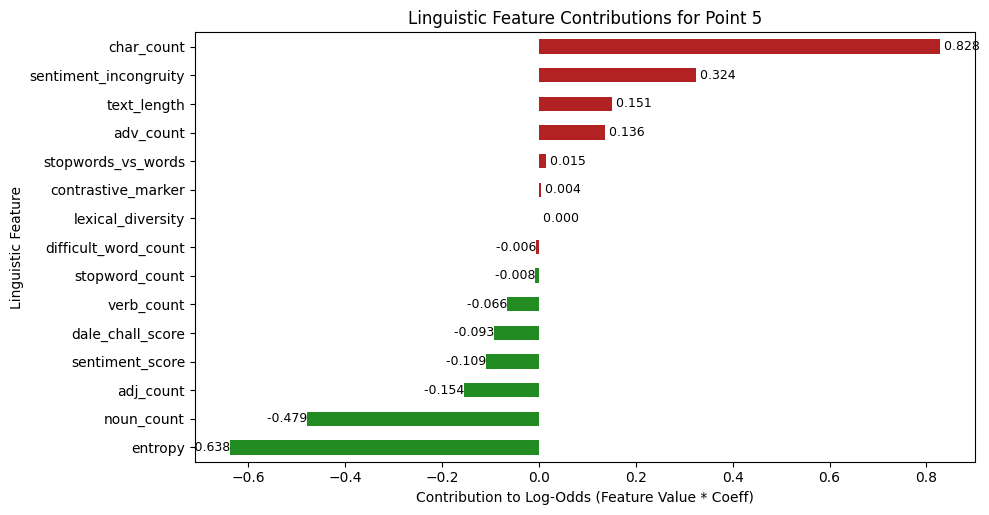


--- Analyzing Indexed Point 6 (Original Index: 900) ---
Type: False Positive, Headline: "man confronts n.j. officer searching van apparently without permission"
Actual: Not Sarcastic, Predicted: Sarcastic, Prob(Sarcastic): 0.986
  Total TF-IDF Contribution: -0.3725
  Total BERT Contribution:   4.2671
  Total Linguistic Contribution: 0.7858
  Model Intercept:           -0.4060
  Calculated Log-Odds:       4.2744
  Calculated Prob(Sarcastic):0.9863 (Should approx match model output)


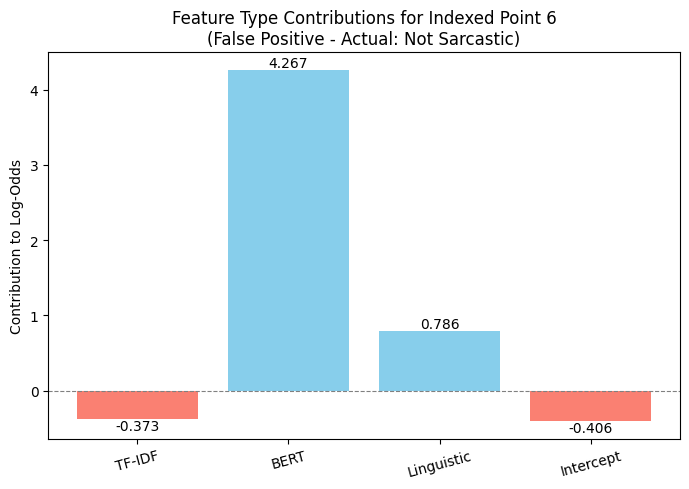

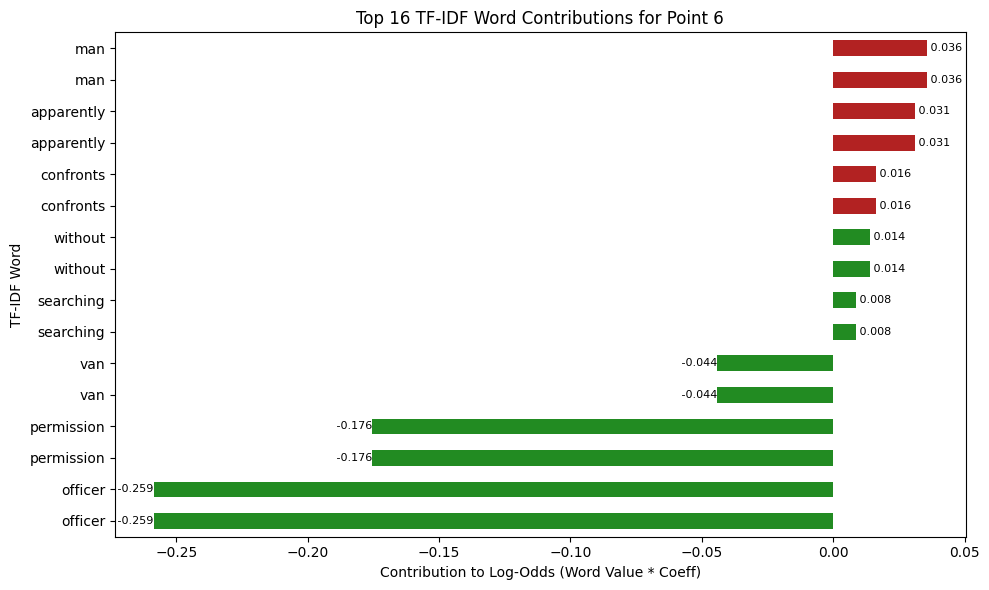

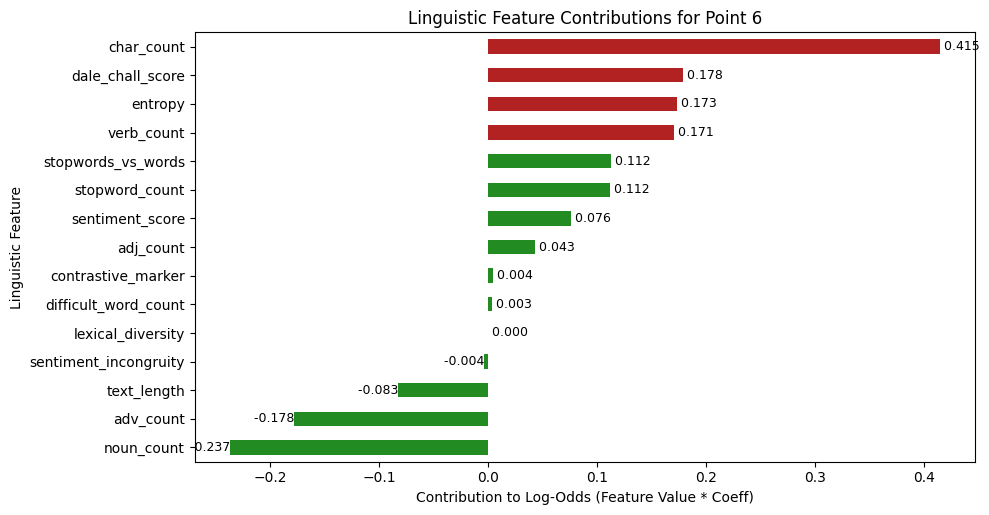


--- End Detailed Misclassification Analysis ---


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix # Ensure these are imported

# --- Detailed Misclassification Analysis for INDEXED Points ---

print("\n--- Detailed Analysis of INDIVIDUAL Indexed Misclassifications ---")

# --- Helper Function to Analyze a Single Misclassification ---

def analyze_misclassification(original_index, display_index, details, lr_model,
                              tfidf_vectorizer, bert_embeddings_after, ling_features_test,
                              scaler_after, feature_names_dict, top_n=15):
    """
    Analyzes and visualizes the feature contributions for a single misclassified instance.

    Args:
        original_index (int): The index of the instance in the original df_test.
        display_index (int): The index number shown on the t-SNE plot (1, 2, ...).
        details (dict): The dictionary containing info about this indexed point.
        lr_model: The trained Logistic Regression model (lr_after).
        tfidf_vectorizer: The fitted TF-IDF vectorizer.
        bert_embeddings_after: The full array of BERT embeddings after FT (X_bert_test_after_ft).
        ling_features_test: The full array of linguistic features for the test set (X_ling_test).
        scaler_after: The fitted StandardScaler for the BERT+Ling features (after FT).
        feature_names_dict (dict): Contains keys 'tfidf', 'bert', 'ling' with lists of names.
        top_n (int): Number of top features to show in plots.
    """
    print(f"\n--- Analyzing Indexed Point {display_index} (Original Index: {original_index}) ---")
    print(f"Type: {details['type']}, Headline: \"{details['headline']}\"")
    print(f"Actual: {details['actual']}, Predicted: {details['predicted']}, Prob(Sarcastic): {details['probability_sarcastic']}")

    if not hasattr(lr_model, 'coef_'):
        print("Model coefficients not found. Cannot perform detailed analysis.")
        return

    coefficients = lr_model.coef_[0]
    num_tfidf = len(feature_names_dict['tfidf'])
    num_bert = len(feature_names_dict['bert'])
    num_ling = len(feature_names_dict['ling'])

    # 1. Reconstruct the exact feature vector for this instance
    headline_text = [details['headline']] # Needs to be iterable for transform
    instance_tfidf = tfidf_vectorizer.transform(headline_text) # Sparse

    # Ensure indices are valid before accessing arrays
    if original_index >= bert_embeddings_after.shape[0] or original_index >= ling_features_test.shape[0]:
         print(f"Error: Original index {original_index} is out of bounds for embeddings or linguistic features.")
         return

    instance_bert = bert_embeddings_after[original_index].reshape(1, -1) # Dense (1, num_bert)
    instance_ling = ling_features_test[original_index].reshape(1, -1)   # Dense (1, num_ling)

    # Combine BERT + Ling and scale using the *correct* scaler
    instance_bert_ling = np.hstack([instance_bert, instance_ling]) # Dense (1, num_bert + num_ling)
    instance_bert_ling_scaled = scaler_after.transform(instance_bert_ling) # Dense (1, num_bert + num_ling)
    instance_bert_ling_scaled_sparse = csr_matrix(instance_bert_ling_scaled)

    # Combine all features (sparse) - This is what the model saw
    # instance_combined = hstack([instance_tfidf, instance_bert_ling_scaled_sparse]) # Not strictly needed if calculating contributions separately

    # 2. Calculate contributions (feature_value * coefficient)
    tfidf_coeffs = coefficients[:num_tfidf]
    bert_ling_coeffs = coefficients[num_tfidf:] # Coeffs for BERT + Ling combined

    # TF-IDF Contributions (handle sparse matrix multiplication)
    tfidf_contributions_sparse = instance_tfidf.multiply(tfidf_coeffs)
    tfidf_contributions = tfidf_contributions_sparse.toarray()[0] # Convert row to dense array
    total_tfidf_contribution = np.sum(tfidf_contributions)

    # BERT + Ling Contributions (dense calculation is easier here)
    bert_ling_contributions = instance_bert_ling_scaled[0] * bert_ling_coeffs # Element-wise
    total_bert_ling_contribution = np.sum(bert_ling_contributions)

    # Separate BERT and Ling contributions from the combined scaled vector
    bert_contributions = bert_ling_contributions[:num_bert]
    ling_contributions = bert_ling_contributions[num_bert:]
    total_bert_contribution = np.sum(bert_contributions)
    total_ling_contribution = np.sum(ling_contributions)

    # Log-odds score predicted by the model (should match probability)
    log_odds = total_tfidf_contribution + total_bert_ling_contribution + lr_model.intercept_[0]
    predicted_prob_from_contributions = 1 / (1 + np.exp(-log_odds))

    print(f"  Total TF-IDF Contribution: {total_tfidf_contribution:.4f}")
    print(f"  Total BERT Contribution:   {total_bert_contribution:.4f}")
    print(f"  Total Linguistic Contribution: {total_ling_contribution:.4f}")
    print(f"  Model Intercept:           {lr_model.intercept_[0]:.4f}")
    print(f"  Calculated Log-Odds:       {log_odds:.4f}")
    print(f"  Calculated Prob(Sarcastic):{predicted_prob_from_contributions:.4f} (Should approx match model output)")

    # --- Visualization ---

    # a) Contribution by Feature Type
    plt.figure(figsize=(7, 5))
    types = ['TF-IDF', 'BERT', 'Linguistic', 'Intercept']
    values = [total_tfidf_contribution, total_bert_contribution, total_ling_contribution, lr_model.intercept_[0]]
    colors = ['skyblue' if v >= 0 else 'salmon' for v in values]
    bars = plt.bar(types, values, color=colors)
    plt.ylabel("Contribution to Log-Odds")
    plt.title(f"Feature Type Contributions for Indexed Point {display_index}\n({details['type']} - Actual: {details['actual']})")
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.xticks(rotation=15)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom' if yval >= 0 else 'top', ha='center')
    plt.tight_layout()
    plt.show()

    # b) Top Individual TF-IDF Contributions
    if num_tfidf > 0:
        tfidf_contrib_series = pd.Series(tfidf_contributions, index=feature_names_dict['tfidf'])
        # Select non-zero contributions only for meaningful sorting
        tfidf_contrib_series = tfidf_contrib_series[tfidf_contrib_series.abs() > 1e-6]
        if not tfidf_contrib_series.empty:
            top_positive_tfidf = tfidf_contrib_series.nlargest(top_n)
            top_negative_tfidf = tfidf_contrib_series.nsmallest(top_n)
            combined_top_tfidf = pd.concat([top_positive_tfidf, top_negative_tfidf]).sort_values(ascending=False)

            plt.figure(figsize=(10, max(6, len(combined_top_tfidf) * 0.3))) # Adjust height
            colors = ['forestgreen' if v >= 0 else 'firebrick' for v in combined_top_tfidf]
            bars = combined_top_tfidf.sort_values().plot(kind='barh', color=colors)
            plt.xlabel("Contribution to Log-Odds (Word Value * Coeff)")
            plt.ylabel("TF-IDF Word")
            plt.title(f"Top {len(combined_top_tfidf)} TF-IDF Word Contributions for Point {display_index}")
            # Add value labels
            for i, v in enumerate(combined_top_tfidf.sort_values()):
                 plt.text(v, i, f' {v:.3f}', va='center', ha='left' if v >= 0 else 'right', fontsize=8)
            plt.tight_layout()
            plt.show()
        else:
            print("  No significant TF-IDF contributions found for this instance.")


    # c) Top Individual Linguistic Contributions
    if num_ling > 0:
        ling_contrib_series = pd.Series(ling_contributions, index=feature_names_dict['ling'])
        # Select non-zero contributions
        ling_contrib_series = ling_contrib_series[ling_contrib_series.abs() > 1e-6]
        if not ling_contrib_series.empty:
             ling_contrib_series = ling_contrib_series.sort_values(ascending=False)
             plt.figure(figsize=(10, max(5, len(ling_contrib_series) * 0.35))) # Adjust height
             colors = ['forestgreen' if v >= 0 else 'firebrick' for v in ling_contrib_series]
             bars = ling_contrib_series.sort_values().plot(kind='barh', color=colors)
             plt.xlabel("Contribution to Log-Odds (Feature Value * Coeff)")
             plt.ylabel("Linguistic Feature")
             plt.title(f"Linguistic Feature Contributions for Point {display_index}")
             # Add value labels
             for i, v in enumerate(ling_contrib_series.sort_values()):
                 plt.text(v, i, f' {v:.3f}', va='center', ha='left' if v >= 0 else 'right', fontsize=9)
             plt.tight_layout()
             plt.show()
        else:
            print("  No significant Linguistic contributions found for this instance.")

    # Note: Visualizing individual BERT dimension contributions is usually not very interpretable.
    # The aggregate BERT contribution is more informative.


# --- Prepare Feature Names for Analysis Function ---
try:
    # BERT feature names (generic)
    bert_feature_names = [f'bert_dim_{i}' for i in range(num_bert_features_)]

    all_feature_names = {
        'tfidf': tfidf_feature_names_, # From earlier TF-IDF fitting
        'bert': bert_feature_names,
        'ling': ling_feature_names    # From definition earlier
    }
    can_analyze_details = True
except NameError as e:
    print(f"Error: A required feature name list or count (like tfidf_feature_names_) is not defined. Skipping detailed analysis. Error: {e}")
    can_analyze_details = False

# --- Loop Through Indexed Misclassifications and Analyze ---
if can_analyze_details and indexed_details:
    num_to_analyze = 6 # Analyze the top few FPs and FNs for brevity
    analyzed_count = 0
    print(f"\nAttempting detailed analysis for up to {num_to_analyze} indexed points...")

    # Analyze top FPs first
    sorted_fp_indices = sorted([idx for idx, details in indexed_details.items() if details["type"] == "False Positive"])
    for display_idx in sorted_fp_indices:
        if analyzed_count >= num_to_analyze: break
        details = indexed_details[display_idx]
        analyze_misclassification(
            original_index=details['original_index'],
            display_index=display_idx,
            details=details,
            lr_model=lr_after, # Use the model trained AFTER FT
            tfidf_vectorizer=tfidf,
            bert_embeddings_after=X_bert_test_after_ft, # Embeddings AFTER FT
            ling_features_test=X_ling_test, # Linguistic features for test set
            scaler_after=scaler_after,      # Scaler used for AFTER FT model
            feature_names_dict=all_feature_names
        )
        analyzed_count += 1

    # Analyze top FNs next
    sorted_fn_indices = sorted([idx for idx, details in indexed_details.items() if details["type"] == "False Negative"])
    for display_idx in sorted_fn_indices:
        if analyzed_count >= num_to_analyze: break
        details = indexed_details[display_idx]
        analyze_misclassification(
            original_index=details['original_index'],
            display_index=display_idx,
            details=details,
            lr_model=lr_after, # Use the model trained AFTER FT
            tfidf_vectorizer=tfidf,
            bert_embeddings_after=X_bert_test_after_ft, # Embeddings AFTER FT
            ling_features_test=X_ling_test, # Linguistic features for test set
            scaler_after=scaler_after,      # Scaler used for AFTER FT model
            feature_names_dict=all_feature_names
        )
        analyzed_count += 1

    if analyzed_count == 0:
        print("No indexed points were analyzed in detail (check `num_to_analyze` or if `indexed_details` is populated).")

elif not indexed_details:
    print("Skipping detailed misclassification analysis because no points were indexed.")
else:
    # can_analyze_details must be False
    pass # Error message printed earlier

print("\n--- End Detailed Misclassification Analysis ---")